# Imports

In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import requests
import math
from PIL import Image
from io import BytesIO
from collections import Counter
from sklearn.model_selection import train_test_split


import wandb
from wandb.keras import WandbCallback

# Tensorflow imports

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, GaussianNoise
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Check if GPU/CPU is connected

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2506836324481999521
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13793026665811526691
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4973462816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8927879526511985372
physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:26:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2423903752055548983
physical_device_desc: "device: XLA_GPU device"
]


In [4]:
path = 'dataset/'
classes = os.listdir(path) # List of all classes
counts = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(path, c)))    
imbalanced = sorted(counts.items(), key = lambda x: x[1], reverse = True)[:5]
imbalanced = [i[0] for i in imbalanced]

In [5]:
def getImages(size_x, size_y, grayScale=False, datagenEnabled=True):
    channels = 3
    if grayScale:
        channels = 1
    X = [] 
    Y = [] 
    for c in classes:
        if c in imbalanced:
            dir_path = os.path.join(path, c)
            label = imbalanced.index(c)        
            for i in os.listdir(dir_path):
                if grayScale:
                    img = cv.imread(os.path.join(dir_path, i))
                    image = cv.cvtColor(img, cv.COLOR_BGRA2GRAY)
                else:
                    image = cv.imread(os.path.join(dir_path, i))            
                try:
                    resized = cv.resize(image, (size_x, size_y))
                    X.append(resized)
                    Y.append(label)            
                except:
                    print(os.path.join(dir_path, i), '[ERROR] can\'t read the file')
                    continue
    X = np.array(X).reshape(-1, size_x, size_y, channels)
    X = X / 255.0
    y = to_categorical(Y, num_classes = len(imbalanced))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, shuffle = True, random_state = 666)
    if datagenEnabled:
        datagen = ImageDataGenerator(rotation_range = 45, # Degree range for random rotations
                            zoom_range = 0.2, # Range for random zoom 
                            horizontal_flip = True, # Randomly flip inputs horizontally
                            width_shift_range = 0.15, # Range for horizontal shift 
                            height_shift_range = 0.15, # Range for vertical shift 
                            shear_range = 0.2,
                                    )
    else:
        datagen = ImageDataGenerator()
    datagen.fit(X_train)
    img = X_test[293]
    img = img.reshape([-1, size_x, size_y, channels])

    fig = plt.figure(figsize = (18, 8))
    for i, flow in enumerate(datagen.flow(img, batch_size = 1)):
        fig.add_subplot(2, 5, i+1)
        plt.imshow(np.squeeze(flow[:, :, ::-1]))
        plt.axis('off')
        i += 1    
        if i >= 10:
            break
    
    return X_train, X_test, y_train, y_test, datagen

In [6]:
sweep_config = {
  "method": "random",
  "metric" : {
    'name': 'loss',
    'goal': 'minimize'   
    },
 "parameters" : {
    'optimizer': {
        'values': ['Adam', 'SGD', 'RMSprop','Adagrad']
        },

    'loss': {
        'values': ['categorical_crossentropy','poisson']
        },


    'learning_rate': {
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
        },

    'batch_size': {
        'distribution': 'q_log_uniform',
        'q': 1,
        'min': math.log(16),
        'max': math.log(64),
      },

    'epochs': {
        'distribution': 'int_uniform',
        'min':20,
        'max': 100,
        },
    'dropout_layers':{
       'values': [0.1, 0.25, 0.4, 0.5]
    },
     'pooling':{
         'values' : [2,3]
     },
     'gauss':{
        'distribution': 'uniform',
        'min': 0,
        'max': 0.5
        }
     }
  }   


In [7]:
def getOpt(name,rl):
    if name ==  'Adam':
        return keras.optimizers.Adam(learning_rate=rl)
    elif name =='SGD':
        return keras.optimizers.SGD(learning_rate=rl)
    elif name =='RMSprop':
        return keras.optimizers.RMSprop(learning_rate=rl)
    else:
        return keras.optimizers.Adagrad(learning_rate=rl)

# RGB 96x96 - benchmark, no transformation

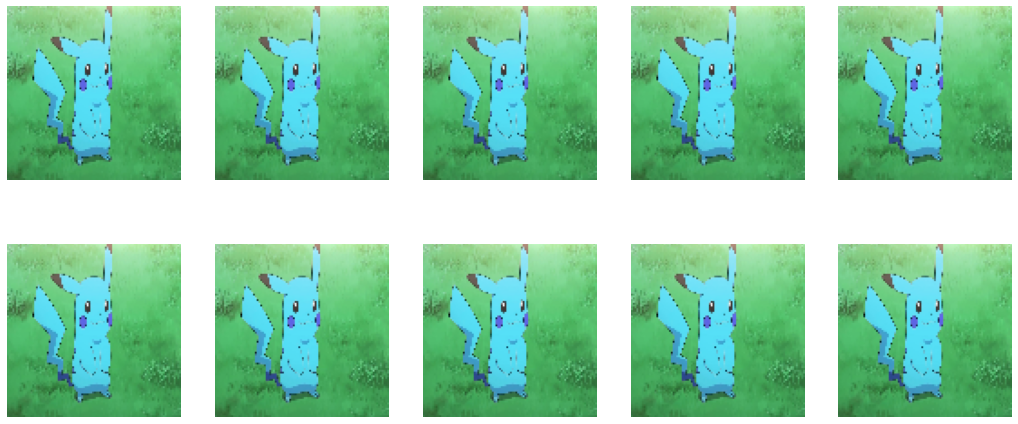

In [8]:
X_train, X_test, y_train, y_test, datagen = getImages(96,96,grayScale=False,datagenEnabled=False)

In [9]:
def train1():
        with wandb.init(config=sweep_config):
            config = wandb.config
            if wandb.run:
                model = Sequential()
                #model.add(GaussianNoise(0,input_shape = (96, 96, 1)))
                model.add(Conv2D(32, 3, padding = 'same', activation = 'relu',input_shape = (96, 96, 3),  kernel_initializer = 'he_normal'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Flatten())
                model.add(Dense(512, activation = 'relu'))
                model.add(BatchNormalization())
                model.add(Dropout(0.5))
                model.add(Dense(256, activation = 'relu'))
                model.add(BatchNormalization())
                model.add(Dropout(0.5))
                model.add(Dense(len(imbalanced), activation = 'softmax'))

                checkpoint = ModelCheckpoint('../working/model_9696_notransformation.hdf5', verbose = 1, monitor = 'val_accuracy', save_best_only = True)
                earlyStoppingCallback = EarlyStopping(monitor='loss', patience=3)

                opt = getOpt(config.optimizer, config.learning_rate)
            
                model.compile(optimizer = opt, loss = config.loss, metrics = ['accuracy'])
                history = model.fit(
                    datagen.flow(X_train, y_train, batch_size = config.batch_size),
                    epochs = config.epochs,
                    validation_data = (X_test, y_test),steps_per_epoch=len(X_train) // config.batch_size, 
                    callbacks = [WandbCallback(),earlyStoppingCallback]
                    )   


In [10]:
%%time
wandb.init(project="NN-zadanie2")
sweep_config['name'] = "NN-zadanie2-sweep-9696notransformation"
sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id, function=train1, count=20)

wandb: Currently logged in as: ramang (use `wandb login --relogin` to force relogin)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 0qg79l0x
Sweep URL: https://wandb.ai/ramang/uncategorized/sweeps/0qg79l0x


wandb: Agent Starting Run: kupimecw with config:
wandb: 	batch_size: 35
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 57
wandb: 	gauss: 0.256781415493519
wandb: 	learning_rate: 0.005909684345613631
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adam
wandb: 	pooling: 3


Epoch 1/57
33/33 [==============================] - 1s 29ms/step - loss: 2.2832 - accuracy: 0.3237 - val_loss: 18.2887 - val_accuracy: 0.2381
Epoch 2/57
33/33 [==============================] - 0s 15ms/step - loss: 1.2554 - accuracy: 0.5281 - val_loss: 2.4183 - val_accuracy: 0.4150
Epoch 3/57
33/33 [==============================] - 0s 14ms/step - loss: 0.9236 - accuracy: 0.6754 - val_loss: 1.5230 - val_accuracy: 0.5068
Epoch 4/57
33/33 [==============================] - 0s 15ms/step - loss: 0.7239 - accuracy: 0.7368 - val_loss: 1.3518 - val_accuracy: 0.6156
Epoch 5/57
33/33 [==============================] - 0s 15ms/step - loss: 0.7123 - accuracy: 0.7474 - val_loss: 1.1769 - val_accuracy: 0.6769
Epoch 6/57
33/33 [==============================] - 0s 14ms/step - loss: 0.5847 - accuracy: 0.7860 - val_loss: 0.6387 - val_accuracy: 0.7347
Epoch 7/57
33/33 [==============================] - 0s 14ms/step - loss: 0.5795 - accuracy: 0.8000 - val_loss: 0.5290 - val_accuracy: 0.8061
Epoch 8/57
3

epoch,22
loss,0.28422
accuracy,0.9114
val_loss,1.17448
val_accuracy,0.72449
_runtime,18
_timestamp,1618267452
_step,22
best_val_loss,0.26425
best_epoch,17


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
accuracy,▁▃▅▆▆▇▇▇▇▇▇▇▇█▇████████
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▆▇▇▆▆█▇▆██▆██▅▇▇█▆
_runtime,▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇▇█
_timestamp,▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 29ad2q62 with config:
wandb: 	batch_size: 29
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 64
wandb: 	gauss: 0.029541413103796543
wandb: 	learning_rate: 0.030916708512735393
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adam
wandb: 	pooling: 3


Epoch 1/64
40/40 [==============================] - 1s 25ms/step - loss: 2.6154 - accuracy: 0.3421 - val_loss: 345.3669 - val_accuracy: 0.2075
Epoch 2/64
40/40 [==============================] - 0s 12ms/step - loss: 1.4343 - accuracy: 0.5044 - val_loss: 112.7142 - val_accuracy: 0.1973
Epoch 3/64
40/40 [==============================] - 0s 12ms/step - loss: 1.0237 - accuracy: 0.6483 - val_loss: 6.0130 - val_accuracy: 0.3299
Epoch 4/64
40/40 [==============================] - 0s 12ms/step - loss: 0.8054 - accuracy: 0.7120 - val_loss: 2.6948 - val_accuracy: 0.5952
Epoch 5/64
40/40 [==============================] - 1s 13ms/step - loss: 0.7192 - accuracy: 0.7557 - val_loss: 0.6142 - val_accuracy: 0.8095
Epoch 6/64
40/40 [==============================] - 0s 11ms/step - loss: 0.6639 - accuracy: 0.7827 - val_loss: 0.7583 - val_accuracy: 0.7211
Epoch 7/64
40/40 [==============================] - 0s 11ms/step - loss: 0.5836 - accuracy: 0.8002 - val_loss: 3.0222 - val_accuracy: 0.4388
Epoch 8/6

epoch,16
loss,0.4923
accuracy,0.83072
val_loss,0.85486
val_accuracy,0.7551
_runtime,13
_timestamp,1618267470
_step,16
best_val_loss,0.28376
best_epoch,10


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▄▃▂▂▂▂▂▂▁▂▁▁▁▁▂▁
accuracy,▁▃▅▆▆▇▇▇▇▇▇███▇▇▇
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▅▇▆▃▆▄▇█▅█▅▅▇▆
_runtime,▁▂▂▃▃▄▄▅▅▅▅▆▆▇▇██
_timestamp,▁▂▂▃▃▄▄▅▅▅▅▆▆▇▇██
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mbfgtekw with config:
wandb: 	batch_size: 21
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 68
wandb: 	gauss: 0.2131184251751752
wandb: 	learning_rate: 0.09611625628736528
wandb: 	loss: poisson
wandb: 	optimizer: Adagrad
wandb: 	pooling: 2


Epoch 1/68
55/55 [==============================] - 1s 23ms/step - loss: 0.5159 - accuracy: 0.5156 - val_loss: 0.4329 - val_accuracy: 0.6054
Epoch 2/68
55/55 [==============================] - 1s 16ms/step - loss: 0.3689 - accuracy: 0.7149 - val_loss: 0.3655 - val_accuracy: 0.6973
Epoch 3/68
55/55 [==============================] - 1s 14ms/step - loss: 0.3344 - accuracy: 0.7626 - val_loss: 0.4408 - val_accuracy: 0.6224
Epoch 4/68
55/55 [==============================] - 1s 14ms/step - loss: 0.3182 - accuracy: 0.8007 - val_loss: 0.4720 - val_accuracy: 0.6837
Epoch 5/68
55/55 [==============================] - 1s 14ms/step - loss: 0.3235 - accuracy: 0.8050 - val_loss: 0.5790 - val_accuracy: 0.5782
Epoch 6/68
55/55 [==============================] - 1s 14ms/step - loss: 0.2877 - accuracy: 0.8466 - val_loss: 0.5869 - val_accuracy: 0.7143
Epoch 7/68
55/55 [==============================] - 1s 14ms/step - loss: 0.3024 - accuracy: 0.8293 - val_loss: 0.4249 - val_accuracy: 0.6939
Epoch 8/68
55

epoch,19
loss,0.25382
accuracy,0.91248
val_loss,0.37861
val_accuracy,0.80612
_runtime,22
_timestamp,1618267506
_step,19
best_val_loss,0.36546
best_epoch,1


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
accuracy,▁▄▅▆▆▇▇▇▇▇▇▇▇▇██████
val_loss,▃▁▃▄▆▇▂▅▆▅█▇▄▆▂▅▇▅▄▁
val_accuracy,▂▅▂▄▁▅▅▄▃▄▂▃▅▃▇▅▃▂▆█
_runtime,▁▁▂▂▃▃▃▄▄▅▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▅▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: sasag8h4 with config:
wandb: 	batch_size: 21
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 43
wandb: 	gauss: 0.47539753423703845
wandb: 	learning_rate: 0.03882336284229529
wandb: 	loss: poisson
wandb: 	optimizer: Adagrad
wandb: 	pooling: 2


Epoch 1/43
55/55 [==============================] - 1s 19ms/step - loss: 0.5549 - accuracy: 0.3943 - val_loss: 0.4528 - val_accuracy: 0.5068
Epoch 2/43
55/55 [==============================] - 1s 16ms/step - loss: 0.4064 - accuracy: 0.6499 - val_loss: 0.4047 - val_accuracy: 0.5646
Epoch 3/43
55/55 [==============================] - 1s 16ms/step - loss: 0.3493 - accuracy: 0.7409 - val_loss: 0.3627 - val_accuracy: 0.6871
Epoch 4/43
55/55 [==============================] - 1s 14ms/step - loss: 0.3444 - accuracy: 0.7400 - val_loss: 0.4181 - val_accuracy: 0.5884
Epoch 5/43
55/55 [==============================] - 1s 14ms/step - loss: 0.3387 - accuracy: 0.7652 - val_loss: 0.4313 - val_accuracy: 0.6122
Epoch 6/43
55/55 [==============================] - 1s 14ms/step - loss: 0.3267 - accuracy: 0.7834 - val_loss: 0.4976 - val_accuracy: 0.6190
Epoch 7/43
55/55 [==============================] - 1s 14ms/step - loss: 0.3190 - accuracy: 0.7842 - val_loss: 0.5938 - val_accuracy: 0.5952
Epoch 8/43
55

epoch,34
loss,0.25798
accuracy,0.89081
val_loss,0.70079
val_accuracy,0.68707
_runtime,45
_timestamp,1618267560
_step,34
best_val_loss,0.36267
best_epoch,2


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇█▇████▇██████
val_loss,▂▁▁▂▂▃▄▅▆▇▇▇▇█▇▇█▇▇▇█▆▆▇█▇█▇▇▆▄▅▅▆▅
val_accuracy,▁▃▇▄▄▅▄▃▃▃▃▄▃▄▃▃▄▃▄▄▃▅▅▄▄▅▄▃▅▆██▆▄▇
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▇▇█
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 0mj5o8ow with config:
wandb: 	batch_size: 18
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 88
wandb: 	gauss: 0.31823123665080033
wandb: 	learning_rate: 0.08712219376161585
wandb: 	loss: poisson
wandb: 	optimizer: Adam
wandb: 	pooling: 2


Epoch 1/88
65/65 [==============================] - 3s 48ms/step - loss: 1.2843 - accuracy: 0.4503 - val_loss: 2.5956 - val_accuracy: 0.2381
Epoch 2/88
65/65 [==============================] - 3s 41ms/step - loss: 1.1119 - accuracy: 0.6128 - val_loss: 1.8352 - val_accuracy: 0.4694
Epoch 3/88
65/65 [==============================] - 3s 39ms/step - loss: 1.0360 - accuracy: 0.6500 - val_loss: 1.7803 - val_accuracy: 0.4898
Epoch 4/88
65/65 [==============================] - 2s 37ms/step - loss: 1.1049 - accuracy: 0.6474 - val_loss: 2.2478 - val_accuracy: 0.3469
Epoch 5/88
65/65 [==============================] - 2s 38ms/step - loss: 1.4066 - accuracy: 0.5791 - val_loss: 2.2746 - val_accuracy: 0.3537
Epoch 6/88
65/65 [==============================] - 2s 37ms/step - loss: 1.7135 - accuracy: 0.5039 - val_loss: 2.1291 - val_accuracy: 0.3878


epoch,5
loss,1.71352
accuracy,0.50389
val_loss,2.12907
val_accuracy,0.38776
_runtime,21
_timestamp,1618267589
_step,5
best_val_loss,1.78032
best_epoch,2


epoch,▁▂▄▅▇█
loss,▄▂▁▂▅█
accuracy,▁▇██▆▃
val_loss,█▁▁▅▅▄
val_accuracy,▁▇█▄▄▅
_runtime,▁▃▄▅▆█
_timestamp,▁▃▄▅▆█
_step,▁▂▄▅▇█


wandb: Agent Starting Run: 9wf7sany with config:
wandb: 	batch_size: 62
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 68
wandb: 	gauss: 0.22703413938560324
wandb: 	learning_rate: 0.04742700214499458
wandb: 	loss: poisson
wandb: 	optimizer: Adagrad
wandb: 	pooling: 2


Epoch 1/68
18/18 [==============================] - 2s 121ms/step - loss: 0.5792 - accuracy: 0.3754 - val_loss: 0.5969 - val_accuracy: 0.2993
Epoch 2/68
18/18 [==============================] - 2s 126ms/step - loss: 0.4317 - accuracy: 0.5939 - val_loss: 0.4498 - val_accuracy: 0.4898
Epoch 3/68
18/18 [==============================] - 2s 109ms/step - loss: 0.3687 - accuracy: 0.6999 - val_loss: 0.3664 - val_accuracy: 0.7449
Epoch 4/68
18/18 [==============================] - 2s 104ms/step - loss: 0.3524 - accuracy: 0.7206 - val_loss: 0.3850 - val_accuracy: 0.5578
Epoch 5/68
18/18 [==============================] - 2s 109ms/step - loss: 0.3414 - accuracy: 0.7610 - val_loss: 0.3601 - val_accuracy: 0.6735
Epoch 6/68
18/18 [==============================] - 2s 105ms/step - loss: 0.3221 - accuracy: 0.7745 - val_loss: 0.4055 - val_accuracy: 0.5748
Epoch 7/68
18/18 [==============================] - 2s 106ms/step - loss: 0.3109 - accuracy: 0.8032 - val_loss: 0.4131 - val_accuracy: 0.5646
Epoch 

epoch,19
loss,0.2706
accuracy,0.87062
val_loss,0.31826
val_accuracy,0.79252
_runtime,46
_timestamp,1618267645
_step,19
best_val_loss,0.31826
best_epoch,19


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,▁▄▆▆▆▇▇▇▇▇██████████
val_loss,█▄▂▃▂▃▃▃▄▃▄▄▂▁▂▅▁▁▂▁
val_accuracy,▁▄▇▅▆▅▅▅▄▆▅▅▆▇▆▅██▇█
_runtime,▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: zquvc5uy with config:
wandb: 	batch_size: 16
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 29
wandb: 	gauss: 0.09954757827527932
wandb: 	learning_rate: 0.006179570885318753
wandb: 	loss: poisson
wandb: 	optimizer: SGD
wandb: 	pooling: 2


Epoch 1/29
73/73 [==============================] - 4s 56ms/step - loss: 0.7099 - accuracy: 0.2338 - val_loss: 0.5137 - val_accuracy: 0.2177
Epoch 2/29
73/73 [==============================] - 3s 42ms/step - loss: 0.6166 - accuracy: 0.3253 - val_loss: 0.5665 - val_accuracy: 0.2313
Epoch 3/29
73/73 [==============================] - 3s 42ms/step - loss: 0.5418 - accuracy: 0.4185 - val_loss: 0.5569 - val_accuracy: 0.3129
Epoch 4/29
73/73 [==============================] - 3s 42ms/step - loss: 0.5227 - accuracy: 0.4228 - val_loss: 0.5805 - val_accuracy: 0.3435
Epoch 5/29
73/73 [==============================] - 3s 42ms/step - loss: 0.4914 - accuracy: 0.4840 - val_loss: 0.5894 - val_accuracy: 0.3912
Epoch 6/29
73/73 [==============================] - 3s 42ms/step - loss: 0.4759 - accuracy: 0.4953 - val_loss: 0.5211 - val_accuracy: 0.4694
Epoch 7/29
73/73 [==============================] - 3s 44ms/step - loss: 0.4536 - accuracy: 0.5479 - val_loss: 0.5088 - val_accuracy: 0.5000
Epoch 8/29
73

epoch,22
loss,0.35232
accuracy,0.74806
val_loss,0.62847
val_accuracy,0.58844
_runtime,78
_timestamp,1618267731
_step,22
best_val_loss,0.50885
best_epoch,6


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁
accuracy,▁▂▃▄▄▄▅▆▆▆▇▇▇▇▇▇▇██████
val_loss,▁▂▂▃▃▁▁▃▅▄▄▅█▆██▆▄▆▄▃▃▄
val_accuracy,▁▁▃▃▄▅▆▆▅▆▇▇▆▇▆▆▇▇▇▇██▇
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: c3nj6fqk with config:
wandb: 	batch_size: 34
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 24
wandb: 	gauss: 0.37383353190577057
wandb: 	learning_rate: 0.08497505660249018
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: RMSprop
wandb: 	pooling: 2


Epoch 1/24
34/34 [==============================] - 2s 63ms/step - loss: 5.7703 - accuracy: 0.4952 - val_loss: 1794.1901 - val_accuracy: 0.2041
Epoch 2/24
34/34 [==============================] - 2s 51ms/step - loss: 2.2667 - accuracy: 0.5548 - val_loss: 205.1670 - val_accuracy: 0.2177
Epoch 3/24
34/34 [==============================] - 2s 51ms/step - loss: 1.5742 - accuracy: 0.6170 - val_loss: 177.1131 - val_accuracy: 0.2517
Epoch 4/24
34/34 [==============================] - 2s 50ms/step - loss: 1.5831 - accuracy: 0.6065 - val_loss: 127.4802 - val_accuracy: 0.3741
Epoch 5/24
34/34 [==============================] - 2s 52ms/step - loss: 1.4466 - accuracy: 0.6670 - val_loss: 57.8856 - val_accuracy: 0.2483
Epoch 6/24
34/34 [==============================] - 2s 51ms/step - loss: 1.3830 - accuracy: 0.7055 - val_loss: 4.9485 - val_accuracy: 0.7075
Epoch 7/24
34/34 [==============================] - 2s 48ms/step - loss: 1.1655 - accuracy: 0.7371 - val_loss: 32.5018 - val_accuracy: 0.4150
Ep

epoch,9
loss,1.18524
accuracy,0.77564
val_loss,10.36663
val_accuracy,0.54422
_runtime,23
_timestamp,1618267762
_step,9
best_val_loss,4.94855
best_epoch,5


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▁▁▁▁▁▁
accuracy,▁▂▄▄▅▆▇▇██
val_loss,█▂▂▁▁▁▁▁▁▁
val_accuracy,▁▁▂▃▂█▄▆▅▆
_runtime,▁▁▂▃▄▅▆▇██
_timestamp,▁▁▂▃▄▅▆▇██
_step,▁▂▃▃▄▅▆▆▇█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pj5k8q7j with config:
wandb: 	batch_size: 46
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 45
wandb: 	gauss: 0.2749342951162738
wandb: 	learning_rate: 0.005625102327788268
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adam
wandb: 	pooling: 3


Epoch 1/45
25/25 [==============================] - 2s 97ms/step - loss: 2.1305 - accuracy: 0.3454 - val_loss: 16.3876 - val_accuracy: 0.2041
Epoch 2/45
25/25 [==============================] - 1s 58ms/step - loss: 1.3061 - accuracy: 0.5084 - val_loss: 2.1857 - val_accuracy: 0.3537
Epoch 3/45
25/25 [==============================] - 2s 61ms/step - loss: 0.9471 - accuracy: 0.6262 - val_loss: 1.1144 - val_accuracy: 0.6259
Epoch 4/45
25/25 [==============================] - 1s 59ms/step - loss: 0.7079 - accuracy: 0.7281 - val_loss: 1.1431 - val_accuracy: 0.7143
Epoch 5/45
25/25 [==============================] - 2s 60ms/step - loss: 0.6770 - accuracy: 0.7715 - val_loss: 0.9182 - val_accuracy: 0.7347
Epoch 6/45
25/25 [==============================] - 2s 61ms/step - loss: 0.6655 - accuracy: 0.7688 - val_loss: 0.8680 - val_accuracy: 0.6837
Epoch 7/45
25/25 [==============================] - 1s 59ms/step - loss: 0.6235 - accuracy: 0.7803 - val_loss: 0.9598 - val_accuracy: 0.6939
Epoch 8/45
2

epoch,22
loss,0.39143
accuracy,0.87511
val_loss,0.43996
val_accuracy,0.88776
_runtime,42
_timestamp,1618267822
_step,22
best_val_loss,0.33037
best_epoch,20


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▅▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▅▆▇▇▇▇▇▇▇▇▇██████████
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▅▆▆▆▆▆▆▇▇▇▆▇▇█▇██████
_runtime,▁▁▂▂▂▃▃▃▃▄▄▅▅▅▆▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▃▄▄▅▅▅▆▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 9sr061ev with config:
wandb: 	batch_size: 32
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 35
wandb: 	gauss: 0.21769938295013141
wandb: 	learning_rate: 0.030313900376175287
wandb: 	loss: poisson
wandb: 	optimizer: RMSprop
wandb: 	pooling: 2


Epoch 1/35
36/36 [==============================] - 3s 84ms/step - loss: 0.7990 - accuracy: 0.4278 - val_loss: 2.6008 - val_accuracy: 0.2449
Epoch 2/35
36/36 [==============================] - 2s 67ms/step - loss: 0.4706 - accuracy: 0.6579 - val_loss: 2.1599 - val_accuracy: 0.2143
Epoch 3/35
36/36 [==============================] - 2s 68ms/step - loss: 0.4014 - accuracy: 0.7069 - val_loss: 2.0986 - val_accuracy: 0.3878
Epoch 4/35
36/36 [==============================] - 2s 67ms/step - loss: 0.3596 - accuracy: 0.7620 - val_loss: 1.7617 - val_accuracy: 0.4456
Epoch 5/35
36/36 [==============================] - 2s 66ms/step - loss: 0.3160 - accuracy: 0.8250 - val_loss: 0.9806 - val_accuracy: 0.6293
Epoch 6/35
36/36 [==============================] - 2s 68ms/step - loss: 0.3183 - accuracy: 0.8154 - val_loss: 0.8903 - val_accuracy: 0.6293
Epoch 7/35
36/36 [==============================] - 3s 72ms/step - loss: 0.3018 - accuracy: 0.8521 - val_loss: 0.5667 - val_accuracy: 0.7483
Epoch 8/35
36

epoch,12
loss,0.28749
accuracy,0.87314
val_loss,0.33796
val_accuracy,0.86395
_runtime,38
_timestamp,1618267865
_step,12
best_val_loss,0.33796
best_epoch,12


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▄▃▂▁▂▁▁▁▁▁▁▁
accuracy,▁▅▅▆▇▇█▇█████
val_loss,█▇▆▅▃▃▂▂▂▄▂▂▁
val_accuracy,▁▁▃▃▅▅▇▆▆▃▆▄█
_runtime,▁▁▂▃▃▄▅▅▆▆▇▇█
_timestamp,▁▁▂▃▃▄▅▅▆▆▇▇█
_step,▁▂▂▃▃▄▅▅▆▆▇▇█


wandb: Agent Starting Run: fb0vnrlx with config:
wandb: 	batch_size: 48
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 95
wandb: 	gauss: 0.27866167836500066
wandb: 	learning_rate: 0.06748569971567679
wandb: 	loss: poisson
wandb: 	optimizer: Adam
wandb: 	pooling: 3


Epoch 1/95
24/24 [==============================] - 1s 52ms/step - loss: 0.8845 - accuracy: 0.3248 - val_loss: 2.7767 - val_accuracy: 0.2007
Epoch 2/95
24/24 [==============================] - 1s 37ms/step - loss: 0.5858 - accuracy: 0.4783 - val_loss: 2.7767 - val_accuracy: 0.2007
Epoch 3/95
24/24 [==============================] - 1s 39ms/step - loss: 0.4473 - accuracy: 0.6229 - val_loss: 2.5472 - val_accuracy: 0.2619
Epoch 4/95
24/24 [==============================] - 1s 40ms/step - loss: 0.3731 - accuracy: 0.7045 - val_loss: 2.1018 - val_accuracy: 0.3367
Epoch 5/95
24/24 [==============================] - 1s 39ms/step - loss: 0.3550 - accuracy: 0.7543 - val_loss: 1.6277 - val_accuracy: 0.2891
Epoch 6/95
24/24 [==============================] - 1s 39ms/step - loss: 0.3345 - accuracy: 0.7684 - val_loss: 0.6696 - val_accuracy: 0.5714
Epoch 7/95
24/24 [==============================] - 1s 39ms/step - loss: 0.3321 - accuracy: 0.7684 - val_loss: 0.4163 - val_accuracy: 0.7517
Epoch 8/95
24

epoch,15
loss,0.30871
accuracy,0.8323
val_loss,0.37155
val_accuracy,0.79252
_runtime,21
_timestamp,1618267893
_step,15
best_val_loss,0.31071
best_epoch,8


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▅▆▇▇▇▇▇▇▇██▇▇█
val_loss,██▇▆▅▂▁▂▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▂▂▅▇▆█▇▇█▇▇▇▇
_runtime,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
_timestamp,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██


wandb: Agent Starting Run: 4gijnedh with config:
wandb: 	batch_size: 55
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 97
wandb: 	gauss: 0.16470439989668156
wandb: 	learning_rate: 0.001379936528906234
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adam
wandb: 	pooling: 2


Epoch 1/97
21/21 [==============================] - 1s 61ms/step - loss: 1.4840 - accuracy: 0.5241 - val_loss: 1.3626 - val_accuracy: 0.3878
Epoch 2/97
21/21 [==============================] - 1s 52ms/step - loss: 0.8241 - accuracy: 0.7339 - val_loss: 0.6860 - val_accuracy: 0.6973
Epoch 3/97
21/21 [==============================] - 1s 52ms/step - loss: 0.6654 - accuracy: 0.7768 - val_loss: 0.6347 - val_accuracy: 0.7483
Epoch 4/97
21/21 [==============================] - 1s 45ms/step - loss: 0.5480 - accuracy: 0.8259 - val_loss: 0.8187 - val_accuracy: 0.6701
Epoch 5/97
21/21 [==============================] - 1s 45ms/step - loss: 0.4343 - accuracy: 0.8554 - val_loss: 0.9083 - val_accuracy: 0.7075
Epoch 6/97
21/21 [==============================] - 1s 46ms/step - loss: 0.3575 - accuracy: 0.8768 - val_loss: 1.0886 - val_accuracy: 0.6190
Epoch 7/97
21/21 [==============================] - 1s 45ms/step - loss: 0.3168 - accuracy: 0.8857 - val_loss: 0.9915 - val_accuracy: 0.7381
Epoch 8/97
21

epoch,14
loss,0.16794
accuracy,0.94286
val_loss,0.82007
val_accuracy,0.79252
_runtime,21
_timestamp,1618267919
_step,14
best_val_loss,0.51077
best_epoch,12


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▄▃▂▂▂▂▂▁▁▁▁▁▁
accuracy,▁▅▅▆▇▇▇▇▇██████
val_loss,█▂▂▃▄▆▅▃▇██▅▁▂▃
val_accuracy,▁▆▇▆▆▅▇▇▆▆▆▇█▇█
_runtime,▁▁▂▂▃▃▄▄▅▅▆▆▇██
_timestamp,▁▁▂▂▃▃▄▄▅▅▆▆▇██
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: xerchxoh with config:
wandb: 	batch_size: 30
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 39
wandb: 	gauss: 0.332130663382484
wandb: 	learning_rate: 0.009087889536391692
wandb: 	loss: poisson
wandb: 	optimizer: RMSprop
wandb: 	pooling: 3


Epoch 1/39
39/39 [==============================] - 2s 49ms/step - loss: 0.5550 - accuracy: 0.5057 - val_loss: 1.8056 - val_accuracy: 0.3605
Epoch 2/39
39/39 [==============================] - 2s 44ms/step - loss: 0.4033 - accuracy: 0.6707 - val_loss: 1.2479 - val_accuracy: 0.5476
Epoch 3/39
39/39 [==============================] - 2s 41ms/step - loss: 0.3678 - accuracy: 0.7441 - val_loss: 0.7234 - val_accuracy: 0.6293
Epoch 4/39
39/39 [==============================] - 2s 43ms/step - loss: 0.3373 - accuracy: 0.7790 - val_loss: 0.6324 - val_accuracy: 0.6531
Epoch 5/39
39/39 [==============================] - 2s 42ms/step - loss: 0.3061 - accuracy: 0.8288 - val_loss: 0.3828 - val_accuracy: 0.8061
Epoch 6/39
39/39 [==============================] - 2s 39ms/step - loss: 0.2943 - accuracy: 0.8463 - val_loss: 0.4562 - val_accuracy: 0.7619
Epoch 7/39
39/39 [==============================] - 2s 40ms/step - loss: 0.2959 - accuracy: 0.8533 - val_loss: 0.2910 - val_accuracy: 0.8844
Epoch 8/39
39

epoch,16
loss,0.25714
accuracy,0.91441
val_loss,0.28475
val_accuracy,0.88435
_runtime,35
_timestamp,1618267963
_step,16
best_val_loss,0.25687
best_epoch,8


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁
accuracy,▁▄▅▆▇▇▇▇▇▇█▇█████
val_loss,█▅▃▃▂▂▁▁▁▂▂▂▁▂▁▁▁
val_accuracy,▁▃▄▅▇▆▇▇█▅▅▆▇▇█▇▇
_runtime,▁▁▂▂▃▃▄▄▄▅▅▆▆▇▇▇█
_timestamp,▁▁▂▂▃▃▄▄▄▅▅▆▆▇▇▇█
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: vqa0tztf with config:
wandb: 	batch_size: 23
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 71
wandb: 	gauss: 0.3020187484963525
wandb: 	learning_rate: 0.09638206638196802
wandb: 	loss: poisson
wandb: 	optimizer: RMSprop
wandb: 	pooling: 2


Epoch 1/71
51/51 [==============================] - 2s 45ms/step - loss: 2.1912 - accuracy: 0.3290 - val_loss: 2.7219 - val_accuracy: 0.2177
Epoch 2/71
51/51 [==============================] - 2s 37ms/step - loss: 2.3326 - accuracy: 0.3255 - val_loss: 2.6561 - val_accuracy: 0.2381
Epoch 3/71
51/51 [==============================] - 2s 38ms/step - loss: 2.1582 - accuracy: 0.3828 - val_loss: 2.5180 - val_accuracy: 0.2789
Epoch 4/71
51/51 [==============================] - 2s 34ms/step - loss: 2.1927 - accuracy: 0.3741 - val_loss: 2.7328 - val_accuracy: 0.2143
Epoch 5/71
51/51 [==============================] - 2s 38ms/step - loss: 2.0648 - accuracy: 0.4158 - val_loss: 2.4349 - val_accuracy: 0.3061
Epoch 6/71
51/51 [==============================] - 2s 34ms/step - loss: 2.1177 - accuracy: 0.4036 - val_loss: 2.6780 - val_accuracy: 0.2313
Epoch 7/71
51/51 [==============================] - 2s 35ms/step - loss: 2.0991 - accuracy: 0.4071 - val_loss: 2.3271 - val_accuracy: 0.3401
Epoch 8/71
51

epoch,10
loss,2.33099
accuracy,0.3316
val_loss,2.2504
val_accuracy,0.36395
_runtime,26
_timestamp,1618267993
_step,10
best_val_loss,2.09856
best_epoch,9


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,▆█▅▆▃▄▄▁▁▅█
accuracy,▁▁▄▄▆▅▅██▄▁
val_loss,█▇▆█▅▇▄▁▅▁▃
val_accuracy,▁▂▃▁▄▂▆█▄█▆
_runtime,▁▂▂▃▄▄▅▆▇▇█
_timestamp,▁▂▂▃▄▄▅▆▇▇█
_step,▁▂▂▃▄▅▅▆▇▇█


wandb: Agent Starting Run: you8ugph with config:
wandb: 	batch_size: 21
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 23
wandb: 	gauss: 0.012589832155605496
wandb: 	learning_rate: 0.04048207400623325
wandb: 	loss: poisson
wandb: 	optimizer: Adam
wandb: 	pooling: 3


Epoch 1/23
55/55 [==============================] - 2s 34ms/step - loss: 0.7209 - accuracy: 0.4489 - val_loss: 2.7657 - val_accuracy: 0.2041
Epoch 2/23
55/55 [==============================] - 2s 30ms/step - loss: 0.5638 - accuracy: 0.5303 - val_loss: 1.5089 - val_accuracy: 0.4524
Epoch 3/23
55/55 [==============================] - 2s 29ms/step - loss: 0.3882 - accuracy: 0.7002 - val_loss: 0.3666 - val_accuracy: 0.7619
Epoch 4/23
55/55 [==============================] - 2s 29ms/step - loss: 0.3454 - accuracy: 0.7565 - val_loss: 0.3132 - val_accuracy: 0.7857
Epoch 5/23
55/55 [==============================] - 2s 28ms/step - loss: 0.3405 - accuracy: 0.7712 - val_loss: 0.4429 - val_accuracy: 0.6837
Epoch 6/23
55/55 [==============================] - 2s 30ms/step - loss: 0.3333 - accuracy: 0.8016 - val_loss: 0.2978 - val_accuracy: 0.8401
Epoch 7/23
55/55 [==============================] - 2s 28ms/step - loss: 0.3258 - accuracy: 0.7894 - val_loss: 0.3410 - val_accuracy: 0.7551
Epoch 8/23
55

epoch,12
loss,0.3181
accuracy,0.81629
val_loss,0.26586
val_accuracy,0.89456
_runtime,27
_timestamp,1618268027
_step,12
best_val_loss,0.26259
best_epoch,8


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▅▂▂▁▁▁▂▁▁▂▁▁
accuracy,▁▃▆▇▇█▇▇██▇▇█
val_loss,█▄▁▁▂▁▁▁▁▂▁▁▁
val_accuracy,▁▃▇▇▆▇▇▇█▄▆▇█
_runtime,▁▂▂▃▃▄▅▅▆▆▇██
_timestamp,▁▂▂▃▃▄▅▅▆▆▇██
_step,▁▂▂▃▃▄▅▅▆▆▇▇█


wandb: Agent Starting Run: 373kb537 with config:
wandb: 	batch_size: 46
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 40
wandb: 	gauss: 0.12791585185716953
wandb: 	learning_rate: 0.011388956642661997
wandb: 	loss: poisson
wandb: 	optimizer: SGD
wandb: 	pooling: 3


Epoch 1/40
25/25 [==============================] - 2s 63ms/step - loss: 0.7031 - accuracy: 0.2259 - val_loss: 0.5153 - val_accuracy: 0.3061
Epoch 2/40
25/25 [==============================] - 1s 54ms/step - loss: 0.6434 - accuracy: 0.2914 - val_loss: 0.5047 - val_accuracy: 0.4524
Epoch 3/40
25/25 [==============================] - 1s 54ms/step - loss: 0.6033 - accuracy: 0.3552 - val_loss: 0.4935 - val_accuracy: 0.4592
Epoch 4/40
25/25 [==============================] - 1s 54ms/step - loss: 0.5739 - accuracy: 0.3764 - val_loss: 0.4843 - val_accuracy: 0.4966
Epoch 5/40
25/25 [==============================] - 1s 54ms/step - loss: 0.5311 - accuracy: 0.4269 - val_loss: 0.4754 - val_accuracy: 0.4456
Epoch 6/40
25/25 [==============================] - 1s 55ms/step - loss: 0.5029 - accuracy: 0.4845 - val_loss: 0.4695 - val_accuracy: 0.4354
Epoch 7/40
25/25 [==============================] - 1s 55ms/step - loss: 0.4920 - accuracy: 0.5058 - val_loss: 0.4554 - val_accuracy: 0.5102
Epoch 8/40
25

epoch,35
loss,0.32613
accuracy,0.80248
val_loss,0.27405
val_accuracy,0.85374
_runtime,56
_timestamp,1618268088
_step,35
best_val_loss,0.27405
best_epoch,35


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▇▆▆▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████▇██
val_loss,██▇▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃▃▃▃▃▄▄▅▄▅▅▅▆▆▆▇▇▇▇▇▇▇█▇█▇▇▇▇▇█████
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: uwjy69i9 with config:
wandb: 	batch_size: 61
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 66
wandb: 	gauss: 0.07987215245162704
wandb: 	learning_rate: 0.03546655706958462
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: RMSprop
wandb: 	pooling: 2


Epoch 1/66
19/19 [==============================] - 2s 85ms/step - loss: 4.0996 - accuracy: 0.3088 - val_loss: 271.9037 - val_accuracy: 0.2721
Epoch 2/66
19/19 [==============================] - 1s 71ms/step - loss: 2.0928 - accuracy: 0.4470 - val_loss: 176.7359 - val_accuracy: 0.4048
Epoch 3/66
19/19 [==============================] - 1s 68ms/step - loss: 1.2916 - accuracy: 0.5763 - val_loss: 188.5574 - val_accuracy: 0.2755
Epoch 4/66
19/19 [==============================] - 1s 74ms/step - loss: 0.9747 - accuracy: 0.6813 - val_loss: 52.4583 - val_accuracy: 0.3741
Epoch 5/66
19/19 [==============================] - 1s 71ms/step - loss: 0.7049 - accuracy: 0.7792 - val_loss: 63.8477 - val_accuracy: 0.3469
Epoch 6/66
19/19 [==============================] - 1s 76ms/step - loss: 0.7177 - accuracy: 0.7567 - val_loss: 17.0489 - val_accuracy: 0.4830
Epoch 7/66
19/19 [==============================] - 1s 75ms/step - loss: 0.6963 - accuracy: 0.7917 - val_loss: 8.9604 - val_accuracy: 0.6497
Epoc

epoch,11
loss,0.43078
accuracy,0.87792
val_loss,1.29212
val_accuracy,0.85034
_runtime,24
_timestamp,1618268116
_step,11
best_val_loss,1.29212
best_epoch,11


epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▄▃▂▂▂▂▁▁▁▁▁
accuracy,▁▃▄▆▇▇▇█████
val_loss,█▆▆▂▃▁▁▁▁▁▁▁
val_accuracy,▁▃▁▂▂▄▆▅▆▇▆█
_runtime,▁▁▂▃▃▄▅▅▆▇██
_timestamp,▁▁▂▃▃▄▅▅▆▇██
_step,▁▂▂▃▄▄▅▅▆▇▇█


wandb: Agent Starting Run: jzqlftfl with config:
wandb: 	batch_size: 39
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 46
wandb: 	gauss: 0.11411327035660218
wandb: 	learning_rate: 0.06593065161887784
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adam
wandb: 	pooling: 3


Epoch 1/46
30/30 [==============================] - 1s 23ms/step - loss: 3.7935 - accuracy: 0.3195 - val_loss: 6297.7842 - val_accuracy: 0.2041
Epoch 2/46
30/30 [==============================] - 1s 17ms/step - loss: 2.1661 - accuracy: 0.4261 - val_loss: 421.7743 - val_accuracy: 0.1905
Epoch 3/46
30/30 [==============================] - 0s 16ms/step - loss: 1.3292 - accuracy: 0.4912 - val_loss: 17.9552 - val_accuracy: 0.2755
Epoch 4/46
30/30 [==============================] - 1s 17ms/step - loss: 1.0577 - accuracy: 0.5960 - val_loss: 1.8034 - val_accuracy: 0.4796
Epoch 5/46
30/30 [==============================] - 1s 17ms/step - loss: 0.9177 - accuracy: 0.6549 - val_loss: 0.8142 - val_accuracy: 0.6633
Epoch 6/46
30/30 [==============================] - 0s 14ms/step - loss: 0.8691 - accuracy: 0.6637 - val_loss: 1.4685 - val_accuracy: 0.6088
Epoch 7/46
30/30 [==============================] - 0s 15ms/step - loss: 0.8246 - accuracy: 0.7165 - val_loss: 0.9594 - val_accuracy: 0.7415
Epoch 8

epoch,11
loss,0.94967
accuracy,0.6919
val_loss,2.18255
val_accuracy,0.61224
_runtime,10
_timestamp,1618268134
_step,11
best_val_loss,0.8142
best_epoch,4


epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▄▂▂▁▁▁▁▁▁▁▂
accuracy,▁▃▄▅▆▆▇██▇▇▇
val_loss,█▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▅▇▆███▅▇▆
_runtime,▁▂▂▄▄▅▅▇▇███
_timestamp,▁▂▂▄▄▅▅▇▇███
_step,▁▂▂▃▄▄▅▅▆▇▇█


wandb: Agent Starting Run: 47hflkbw with config:
wandb: 	batch_size: 18
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 93
wandb: 	gauss: 0.11275558699528354
wandb: 	learning_rate: 0.05225942835152352
wandb: 	loss: poisson
wandb: 	optimizer: SGD
wandb: 	pooling: 3


Epoch 1/93
65/65 [==============================] - 1s 17ms/step - loss: 0.6885 - accuracy: 0.2195 - val_loss: 0.5249 - val_accuracy: 0.2891
Epoch 2/93
65/65 [==============================] - 1s 14ms/step - loss: 0.6056 - accuracy: 0.2697 - val_loss: 0.5136 - val_accuracy: 0.2857
Epoch 3/93
65/65 [==============================] - 1s 15ms/step - loss: 0.5424 - accuracy: 0.3397 - val_loss: 0.5047 - val_accuracy: 0.2653
Epoch 4/93
65/65 [==============================] - 1s 14ms/step - loss: 0.5070 - accuracy: 0.3691 - val_loss: 0.4998 - val_accuracy: 0.2721
Epoch 5/93
65/65 [==============================] - 1s 15ms/step - loss: 0.4831 - accuracy: 0.3786 - val_loss: 0.4698 - val_accuracy: 0.4116
Epoch 6/93
65/65 [==============================] - 1s 14ms/step - loss: 0.4645 - accuracy: 0.4218 - val_loss: 0.4748 - val_accuracy: 0.4592
Epoch 7/93
65/65 [==============================] - 1s 14ms/step - loss: 0.4618 - accuracy: 0.4028 - val_loss: 0.4702 - val_accuracy: 0.4762
Epoch 8/93
65

epoch,33
loss,0.34152
accuracy,0.74244
val_loss,0.55146
val_accuracy,0.42857
_runtime,37
_timestamp,1618268178
_step,33
best_val_loss,0.46981
best_epoch,4


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▆▅▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▃▃▄▃▄▄▄▄▄▅▅▅▆▇▆▇▇▇▇▇▇▇█████████
val_loss,▂▂▂▂▁▁▁▁▂▂▃▂▂▂▃▄▅▇▆▆▃█▅▅▅▆▄▅▅▄▇▆▄▂
val_accuracy,▂▂▁▁▆▇█▇▄▅▆▅▆▅▃▃▂▂▄▃▅▂▄▄▄▄▆▅▄▆▄▅▅▆
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xz2u47ue with config:
wandb: 	batch_size: 29
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 43
wandb: 	gauss: 0.02554069961854316
wandb: 	learning_rate: 0.04311820504776989
wandb: 	loss: poisson
wandb: 	optimizer: SGD
wandb: 	pooling: 2


Epoch 1/43
40/40 [==============================] - 2s 62ms/step - loss: 0.6120 - accuracy: 0.3455 - val_loss: 0.4493 - val_accuracy: 0.5170
Epoch 2/43
40/40 [==============================] - 2s 55ms/step - loss: 0.4551 - accuracy: 0.5419 - val_loss: 0.4073 - val_accuracy: 0.5952
Epoch 3/43
40/40 [==============================] - 2s 53ms/step - loss: 0.4113 - accuracy: 0.6361 - val_loss: 0.4765 - val_accuracy: 0.4966
Epoch 4/43
40/40 [==============================] - 2s 53ms/step - loss: 0.3773 - accuracy: 0.7086 - val_loss: 0.4448 - val_accuracy: 0.5918
Epoch 5/43
40/40 [==============================] - 2s 53ms/step - loss: 0.3521 - accuracy: 0.7362 - val_loss: 0.5052 - val_accuracy: 0.5238
Epoch 6/43
40/40 [==============================] - 2s 54ms/step - loss: 0.3484 - accuracy: 0.7487 - val_loss: 0.5741 - val_accuracy: 0.5238
Epoch 7/43
40/40 [==============================] - 2s 54ms/step - loss: 0.3330 - accuracy: 0.7583 - val_loss: 0.5171 - val_accuracy: 0.5680
Epoch 8/43
40

epoch,35
loss,0.26862
accuracy,0.89092
val_loss,0.4454
val_accuracy,0.73469
_runtime,85
_timestamp,1618268276
_step,35
best_val_loss,0.40735
best_epoch,1


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█████████████
val_loss,▂▁▃▂▄▆▄▃▄▄▅▆▆▆▇▇██▇▆▇▆▆▅▅▅▅▅▄▆▆▅▆▃▃▂
val_accuracy,▂▄▁▄▂▂▃▃▄▄▄▂▂▃▂▃▃▃▂▄▄▅▅▅▆▅▆▆▆▆▆▆▇▇██
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


Wall time: 14min 12s


# RGB 96x96 - benchmark, transformation

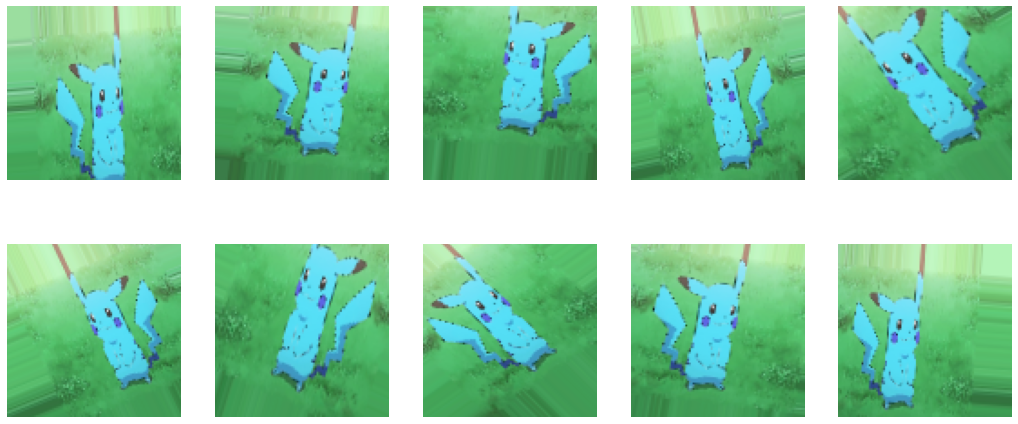

In [11]:
X_train, X_test, y_train, y_test, datagen = getImages(96,96,grayScale=False,datagenEnabled=True)

In [12]:
def train2():
        with wandb.init(config=sweep_config):
            config = wandb.config
            if wandb.run:
                model = Sequential()
                #model.add(GaussianNoise(0,input_shape = (96, 96, 1)))
                model.add(Conv2D(32, 3, padding = 'same', activation = 'relu',input_shape = (96, 96, 3),  kernel_initializer = 'he_normal'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Flatten())
                model.add(Dense(512, activation = 'relu'))
                model.add(BatchNormalization())
                model.add(Dropout(0.5))
                model.add(Dense(256, activation = 'relu'))
                model.add(BatchNormalization())
                model.add(Dropout(0.5))
                model.add(Dense(len(imbalanced), activation = 'softmax'))

                checkpoint = ModelCheckpoint('../working/model_9696_transformation.hdf5', verbose = 1, monitor = 'val_accuracy', save_best_only = True)
                earlyStoppingCallback = EarlyStopping(monitor='loss', patience=3)

                opt = getOpt(config.optimizer, config.learning_rate)
            
                model.compile(optimizer = opt, loss = config.loss, metrics = ['accuracy'])
                history = model.fit(
                    datagen.flow(X_train, y_train, batch_size = config.batch_size),
                    epochs = config.epochs,
                    validation_data = (X_test, y_test),steps_per_epoch=len(X_train) // config.batch_size, 
                    callbacks = [WandbCallback(),earlyStoppingCallback]
                    )   


In [13]:
%%time
wandb.init(project="NN-zadanie2")
sweep_config['name'] = "NN-zadanie2-sweep-9696transformation"
sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id, function=train2, count=20)

wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 5dsiaxco
Sweep URL: https://wandb.ai/ramang/uncategorized/sweeps/5dsiaxco


wandb: Agent Starting Run: rh42j8gr with config:
wandb: 	batch_size: 45
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 70
wandb: 	gauss: 0.15383774413179463
wandb: 	learning_rate: 0.07202454877063418
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adagrad
wandb: 	pooling: 3


Epoch 1/70
26/26 [==============================] - 2s 87ms/step - loss: 2.2063 - accuracy: 0.3363 - val_loss: 13.7488 - val_accuracy: 0.2041
Epoch 2/70
26/26 [==============================] - 2s 81ms/step - loss: 1.3341 - accuracy: 0.5204 - val_loss: 4.8042 - val_accuracy: 0.2857
Epoch 3/70
26/26 [==============================] - 2s 80ms/step - loss: 1.1660 - accuracy: 0.5823 - val_loss: 1.1850 - val_accuracy: 0.5272
Epoch 4/70
26/26 [==============================] - 2s 82ms/step - loss: 0.9910 - accuracy: 0.6363 - val_loss: 0.9695 - val_accuracy: 0.6633
Epoch 5/70
26/26 [==============================] - 2s 79ms/step - loss: 0.9320 - accuracy: 0.6841 - val_loss: 2.0699 - val_accuracy: 0.4286
Epoch 6/70
26/26 [==============================] - 2s 82ms/step - loss: 0.8576 - accuracy: 0.6957 - val_loss: 1.2831 - val_accuracy: 0.6156
Epoch 7/70
26/26 [==============================] - 2s 78ms/step - loss: 0.7736 - accuracy: 0.7150 - val_loss: 1.1989 - val_accuracy: 0.6224
Epoch 8/70
2

epoch,15
loss,0.63081
accuracy,0.78142
val_loss,0.63235
val_accuracy,0.77551
_runtime,41
_timestamp,1618268348
_step,15
best_val_loss,0.63235
best_epoch,15


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▄▅▆▆▆▇▇█▇██████
val_loss,█▃▁▁▂▁▁▁▁▁▂▂▁▁▁▁
val_accuracy,▁▂▅▇▄▆▆▆▇▇▅▅▆█▅█
_runtime,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
_timestamp,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██


wandb: Agent Starting Run: 1suukwzy with config:
wandb: 	batch_size: 33
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 78
wandb: 	gauss: 0.29015179807132957
wandb: 	learning_rate: 0.07724688499992681
wandb: 	loss: poisson
wandb: 	optimizer: SGD
wandb: 	pooling: 3


Epoch 1/78
35/35 [==============================] - 2s 67ms/step - loss: 0.6397 - accuracy: 0.2837 - val_loss: 0.5229 - val_accuracy: 0.3095
Epoch 2/78
35/35 [==============================] - 2s 59ms/step - loss: 0.5064 - accuracy: 0.4764 - val_loss: 0.4381 - val_accuracy: 0.5000
Epoch 3/78
35/35 [==============================] - 2s 58ms/step - loss: 0.4533 - accuracy: 0.5657 - val_loss: 0.4413 - val_accuracy: 0.4694
Epoch 4/78
35/35 [==============================] - 2s 60ms/step - loss: 0.4177 - accuracy: 0.6077 - val_loss: 0.4332 - val_accuracy: 0.4762
Epoch 5/78
35/35 [==============================] - 2s 59ms/step - loss: 0.3879 - accuracy: 0.6576 - val_loss: 0.3895 - val_accuracy: 0.6224
Epoch 6/78
35/35 [==============================] - 2s 60ms/step - loss: 0.3753 - accuracy: 0.6953 - val_loss: 0.3286 - val_accuracy: 0.7823
Epoch 7/78
35/35 [==============================] - 2s 60ms/step - loss: 0.3662 - accuracy: 0.6952 - val_loss: 0.3495 - val_accuracy: 0.6973
Epoch 8/78
35

epoch,20
loss,0.31497
accuracy,0.79772
val_loss,0.2872
val_accuracy,0.86054
_runtime,51
_timestamp,1618268404
_step,20
best_val_loss,0.27753
best_epoch,16


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,▁▄▅▅▆▇▇▇▇▇▇▇▇▇███████
val_loss,█▆▆▅▄▂▃▄▃▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▃▅▇▆▅▆▇▆▆▇██▇█████
_runtime,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: fy3rowh4 with config:
wandb: 	batch_size: 52
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 81
wandb: 	gauss: 0.11004509204641844
wandb: 	learning_rate: 0.09863792001656792
wandb: 	loss: poisson
wandb: 	optimizer: Adam
wandb: 	pooling: 2


Epoch 1/81
22/22 [==============================] - 2s 102ms/step - loss: 1.0392 - accuracy: 0.4025 - val_loss: 2.7548 - val_accuracy: 0.2075
Epoch 2/81
22/22 [==============================] - 2s 87ms/step - loss: 0.6395 - accuracy: 0.5361 - val_loss: 2.7767 - val_accuracy: 0.2007
Epoch 3/81
22/22 [==============================] - 2s 92ms/step - loss: 0.4907 - accuracy: 0.6100 - val_loss: 2.6613 - val_accuracy: 0.2041
Epoch 4/81
22/22 [==============================] - 2s 93ms/step - loss: 0.4559 - accuracy: 0.6358 - val_loss: 2.0802 - val_accuracy: 0.4048
Epoch 5/81
22/22 [==============================] - ETA: 0s - loss: 0.4665 - accuracy: 0.54 - 2s 92ms/step - loss: 0.4665 - accuracy: 0.5405 - val_loss: 1.8009 - val_accuracy: 0.4014
Epoch 6/81
22/22 [==============================] - 2s 88ms/step - loss: 0.4238 - accuracy: 0.6073 - val_loss: 2.0401 - val_accuracy: 0.4048
Epoch 7/81
22/22 [==============================] - 2s 92ms/step - loss: 0.3883 - accuracy: 0.6696 - val_loss: 

epoch,13
loss,0.37272
accuracy,0.70525
val_loss,0.35944
val_accuracy,0.7483
_runtime,35
_timestamp,1618268444
_step,13
best_val_loss,0.30272
best_epoch,10


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▄▂▂▂▂▁▁▁▁▁▁▂▁
accuracy,▁▃▅▅▄▅▆▇▇███▅▇
val_loss,███▆▅▆▅▂▁▁▁▂▃▁
val_accuracy,▁▁▁▃▃▃▂▅▅▆█▃▂▇
_runtime,▁▁▂▃▃▄▄▅▅▆▆▇▇█
_timestamp,▁▁▂▃▃▄▄▅▅▆▆▇▇█
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: vw85ff8n with config:
wandb: 	batch_size: 17
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 62
wandb: 	gauss: 0.27514106561883117
wandb: 	learning_rate: 0.02309289106143916
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: SGD
wandb: 	pooling: 2


Epoch 1/62
69/69 [==============================] - 2s 36ms/step - loss: 1.7752 - accuracy: 0.4076 - val_loss: 3.7928 - val_accuracy: 0.2585
Epoch 2/62
69/69 [==============================] - 2s 33ms/step - loss: 1.2627 - accuracy: 0.5458 - val_loss: 1.4239 - val_accuracy: 0.4932
Epoch 3/62
69/69 [==============================] - 2s 33ms/step - loss: 1.2540 - accuracy: 0.5345 - val_loss: 1.1401 - val_accuracy: 0.5578
Epoch 4/62
69/69 [==============================] - 2s 32ms/step - loss: 1.0892 - accuracy: 0.5794 - val_loss: 1.2633 - val_accuracy: 0.6156
Epoch 5/62
69/69 [==============================] - 2s 32ms/step - loss: 0.9540 - accuracy: 0.6390 - val_loss: 2.0473 - val_accuracy: 0.5952
Epoch 6/62
69/69 [==============================] - 2s 35ms/step - loss: 0.9959 - accuracy: 0.6321 - val_loss: 2.4128 - val_accuracy: 0.3844
Epoch 7/62
69/69 [==============================] - 2s 34ms/step - loss: 0.8104 - accuracy: 0.7107 - val_loss: 1.3450 - val_accuracy: 0.6020
Epoch 8/62
69

epoch,13
loss,0.77493
accuracy,0.70466
val_loss,1.01757
val_accuracy,0.63265
_runtime,38
_timestamp,1618268494
_step,13
best_val_loss,0.75395
best_epoch,8


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▅▅▃▃▃▂▁▁▁▁▂▂▁
accuracy,▁▄▄▅▆▆▇▇▇▇█▇▇▇
val_loss,▆▂▂▂▃▄▂▁▁█▅▃▂▁
val_accuracy,▁▅▆▇▇▃▇██▃▅▄▅▇
_runtime,▁▂▂▃▃▄▄▅▅▆▆▇██
_timestamp,▁▂▂▃▃▄▄▅▅▆▆▇██
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: 2c8g93qc with config:
wandb: 	batch_size: 44
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 43
wandb: 	gauss: 0.485979436470411
wandb: 	learning_rate: 0.022328151081722914
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: RMSprop
wandb: 	pooling: 3


Epoch 1/43
26/26 [==============================] - 2s 89ms/step - loss: 3.0848 - accuracy: 0.2794 - val_loss: 268.1788 - val_accuracy: 0.2007
Epoch 2/43
26/26 [==============================] - 2s 78ms/step - loss: 1.7362 - accuracy: 0.3970 - val_loss: 16.3169 - val_accuracy: 0.3095
Epoch 3/43
26/26 [==============================] - 2s 80ms/step - loss: 1.1969 - accuracy: 0.5623 - val_loss: 4.6072 - val_accuracy: 0.5544
Epoch 4/43
26/26 [==============================] - 2s 80ms/step - loss: 0.9559 - accuracy: 0.6985 - val_loss: 3.1244 - val_accuracy: 0.5884
Epoch 5/43
26/26 [==============================] - 2s 76ms/step - loss: 0.8470 - accuracy: 0.7118 - val_loss: 13.0336 - val_accuracy: 0.2755
Epoch 6/43
26/26 [==============================] - 2s 76ms/step - loss: 0.8172 - accuracy: 0.7286 - val_loss: 4.9812 - val_accuracy: 0.5952
Epoch 7/43
26/26 [==============================] - 2s 80ms/step - loss: 0.6462 - accuracy: 0.7728 - val_loss: 1.3396 - val_accuracy: 0.8197
Epoch 8/4

epoch,24
loss,0.47542
accuracy,0.85052
val_loss,0.8562
val_accuracy,0.7483
_runtime,59
_timestamp,1618268560
_step,24
best_val_loss,0.45754
best_epoch,11


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▄▆▆▆▇▇▇▇▇▇█▇███████████
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▅▅▂▅▇▅▇▇▆█▆▆▇█▆█▆▇▆▇▇▇▇
_runtime,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: umulr04h with config:
wandb: 	batch_size: 34
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 46
wandb: 	gauss: 0.016469780711614257
wandb: 	learning_rate: 0.039336998552246344
wandb: 	loss: poisson
wandb: 	optimizer: Adagrad
wandb: 	pooling: 2


Epoch 1/46
34/34 [==============================] - 2s 70ms/step - loss: 0.5231 - accuracy: 0.4820 - val_loss: 0.4198 - val_accuracy: 0.5646
Epoch 2/46
34/34 [==============================] - 2s 61ms/step - loss: 0.4111 - accuracy: 0.6591 - val_loss: 0.4762 - val_accuracy: 0.4524
Epoch 3/46
34/34 [==============================] - 2s 64ms/step - loss: 0.3791 - accuracy: 0.7020 - val_loss: 0.3881 - val_accuracy: 0.7177
Epoch 4/46
34/34 [==============================] - 2s 62ms/step - loss: 0.3536 - accuracy: 0.7362 - val_loss: 0.3984 - val_accuracy: 0.6361
Epoch 5/46
34/34 [==============================] - 2s 62ms/step - loss: 0.3322 - accuracy: 0.7721 - val_loss: 0.4286 - val_accuracy: 0.6224
Epoch 6/46
34/34 [==============================] - 2s 61ms/step - loss: 0.3326 - accuracy: 0.7835 - val_loss: 0.4150 - val_accuracy: 0.6190
Epoch 7/46
34/34 [==============================] - 2s 61ms/step - loss: 0.3148 - accuracy: 0.7949 - val_loss: 0.4090 - val_accuracy: 0.6395
Epoch 8/46
34

epoch,21
loss,0.2823
accuracy,0.85627
val_loss,0.28799
val_accuracy,0.87075
_runtime,54
_timestamp,1618268618
_step,21
best_val_loss,0.28799
best_epoch,21


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▅▄▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
accuracy,▁▄▅▆▆▇▇▇▇▇█▇▇▇█▇██████
val_loss,▆█▅▅▆▆▆▄▃▃▂▃▃▂▁▁▁▃▁▁▂▁
val_accuracy,▃▁▅▄▄▄▄▅▆▆▇▆▇▇███▇▇█▇█
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 5109gj3f with config:
wandb: 	batch_size: 29
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 39
wandb: 	gauss: 0.1022559691953211
wandb: 	learning_rate: 0.03754221742046531
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: RMSprop
wandb: 	pooling: 2


Epoch 1/39
40/40 [==============================] - 2s 62ms/step - loss: 3.7269 - accuracy: 0.3909 - val_loss: 56.9959 - val_accuracy: 0.2483
Epoch 2/39
40/40 [==============================] - 2s 54ms/step - loss: 1.4431 - accuracy: 0.5986 - val_loss: 432.5552 - val_accuracy: 0.2381
Epoch 3/39
40/40 [==============================] - 2s 54ms/step - loss: 1.1098 - accuracy: 0.6885 - val_loss: 58.7216 - val_accuracy: 0.4048
Epoch 4/39
40/40 [==============================] - 2s 59ms/step - loss: 1.0165 - accuracy: 0.6841 - val_loss: 10.1351 - val_accuracy: 0.4422
Epoch 5/39
40/40 [==============================] - 2s 55ms/step - loss: 0.8075 - accuracy: 0.7443 - val_loss: 13.3451 - val_accuracy: 0.4320
Epoch 6/39
40/40 [==============================] - 2s 58ms/step - loss: 0.8391 - accuracy: 0.7435 - val_loss: 8.1355 - val_accuracy: 0.4354
Epoch 7/39
40/40 [==============================] - 2s 54ms/step - loss: 0.7250 - accuracy: 0.7740 - val_loss: 9.8236 - val_accuracy: 0.4660
Epoch 8

epoch,23
loss,0.51507
accuracy,0.85602
val_loss,1.24206
val_accuracy,0.79932
_runtime,61
_timestamp,1618268687
_step,23
best_val_loss,0.45335
best_epoch,19


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▅▅▆▆▇▇▇▇▇█▇▇▇█▇███████
val_loss,▂█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▃▃▃▃▄▇▄▆██▇█▆▆▅▇█▇█▇▇
_runtime,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: oh5cdg2f with config:
wandb: 	batch_size: 19
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 62
wandb: 	gauss: 0.3335753353727108
wandb: 	learning_rate: 0.06072206151796562
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: SGD
wandb: 	pooling: 2


Epoch 1/62
61/61 [==============================] - 3s 46ms/step - loss: 1.4285 - accuracy: 0.5614 - val_loss: 4.6103 - val_accuracy: 0.2925
Epoch 2/62
61/61 [==============================] - 2s 37ms/step - loss: 0.9529 - accuracy: 0.6869 - val_loss: 1.1240 - val_accuracy: 0.6429
Epoch 3/62
61/61 [==============================] - 2s 36ms/step - loss: 0.7614 - accuracy: 0.7595 - val_loss: 1.0587 - val_accuracy: 0.7075
Epoch 4/62
61/61 [==============================] - 2s 36ms/step - loss: 0.6481 - accuracy: 0.7898 - val_loss: 0.8751 - val_accuracy: 0.7313
Epoch 5/62
61/61 [==============================] - 2s 36ms/step - loss: 0.6672 - accuracy: 0.7794 - val_loss: 0.4662 - val_accuracy: 0.8469
Epoch 6/62
61/61 [==============================] - 2s 35ms/step - loss: 0.7257 - accuracy: 0.7474 - val_loss: 0.9285 - val_accuracy: 0.6769
Epoch 7/62
61/61 [==============================] - 2s 35ms/step - loss: 0.6506 - accuracy: 0.7941 - val_loss: 0.5937 - val_accuracy: 0.7551


epoch,6
loss,0.65057
accuracy,0.79412
val_loss,0.59366
val_accuracy,0.7551
_runtime,21
_timestamp,1618268715
_step,6
best_val_loss,0.46618
best_epoch,4


epoch,▁▂▃▅▆▇█
loss,█▄▂▁▁▂▁
accuracy,▁▅▇██▇█
val_loss,█▂▂▂▁▂▁
val_accuracy,▁▅▆▇█▆▇
_runtime,▁▂▃▄▆▇█
_timestamp,▁▂▃▄▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: 7smtq6h1 with config:
wandb: 	batch_size: 26
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 96
wandb: 	gauss: 0.13163044454488543
wandb: 	learning_rate: 0.023774469789938715
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: SGD
wandb: 	pooling: 3


Epoch 1/96
45/45 [==============================] - 2s 53ms/step - loss: 2.5046 - accuracy: 0.2306 - val_loss: 1.6159 - val_accuracy: 0.2381
Epoch 2/96
45/45 [==============================] - 2s 49ms/step - loss: 1.9867 - accuracy: 0.3003 - val_loss: 1.6833 - val_accuracy: 0.2483
Epoch 3/96
45/45 [==============================] - 2s 47ms/step - loss: 1.5385 - accuracy: 0.4030 - val_loss: 1.5043 - val_accuracy: 0.3810
Epoch 4/96
45/45 [==============================] - 2s 48ms/step - loss: 1.2892 - accuracy: 0.4804 - val_loss: 1.3293 - val_accuracy: 0.4388
Epoch 5/96
45/45 [==============================] - 2s 46ms/step - loss: 1.1035 - accuracy: 0.5631 - val_loss: 1.2409 - val_accuracy: 0.4864
Epoch 6/96
45/45 [==============================] - 2s 47ms/step - loss: 1.0364 - accuracy: 0.5883 - val_loss: 1.1333 - val_accuracy: 0.5408
Epoch 7/96
45/45 [==============================] - 2s 47ms/step - loss: 1.0170 - accuracy: 0.6127 - val_loss: 1.0065 - val_accuracy: 0.5918
Epoch 8/96
45

epoch,19
loss,0.81592
accuracy,0.68668
val_loss,0.89558
val_accuracy,0.68367
_runtime,48
_timestamp,1618268769
_step,19
best_val_loss,0.80355
best_epoch,10


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁
accuracy,▁▂▄▅▆▆▇▇▇▇█▇█████▇▇█
val_loss,▇▇▆▅▄▃▂▂▂▄▁▃▃▂▂▃▃█▁▂
val_accuracy,▁▁▃▄▅▆▇█▇▅█▆▇▇█▇▅▂██
_runtime,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: x3pw1d4l with config:
wandb: 	batch_size: 42
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 27
wandb: 	gauss: 0.28307714650997357
wandb: 	learning_rate: 0.08684205971852303
wandb: 	loss: poisson
wandb: 	optimizer: Adagrad
wandb: 	pooling: 2


Epoch 1/27
27/27 [==============================] - 3s 93ms/step - loss: 0.5653 - accuracy: 0.4210 - val_loss: 0.7376 - val_accuracy: 0.3027
Epoch 2/27
27/27 [==============================] - 2s 80ms/step - loss: 0.4039 - accuracy: 0.6540 - val_loss: 0.4421 - val_accuracy: 0.5476
Epoch 3/27
27/27 [==============================] - 2s 82ms/step - loss: 0.3711 - accuracy: 0.7202 - val_loss: 0.3932 - val_accuracy: 0.5884
Epoch 4/27
27/27 [==============================] - 2s 77ms/step - loss: 0.3577 - accuracy: 0.7326 - val_loss: 0.4216 - val_accuracy: 0.5170
Epoch 5/27
27/27 [==============================] - 2s 81ms/step - loss: 0.3399 - accuracy: 0.7511 - val_loss: 0.3846 - val_accuracy: 0.5884
Epoch 6/27
27/27 [==============================] - 2s 80ms/step - loss: 0.3276 - accuracy: 0.7820 - val_loss: 0.3755 - val_accuracy: 0.6735
Epoch 7/27
27/27 [==============================] - 2s 82ms/step - loss: 0.3245 - accuracy: 0.7899 - val_loss: 0.3203 - val_accuracy: 0.7925
Epoch 8/27
27

epoch,14
loss,0.29818
accuracy,0.83142
val_loss,0.2967
val_accuracy,0.83333
_runtime,39
_timestamp,1618268815
_step,14
best_val_loss,0.2967
best_epoch,14


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁
accuracy,▁▅▆▆▇▇▇▇▇▇█████
val_loss,█▃▃▃▂▂▁▂▂▂▂▂▂▁▁
val_accuracy,▁▄▅▄▅▆▇▆▆▇▆▇▇▇█
_runtime,▁▁▂▃▃▃▄▅▅▆▆▆▇▇█
_timestamp,▁▁▂▃▃▃▄▅▅▆▆▆▇▇█
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: 3sekhc4j with config:
wandb: 	batch_size: 38
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 20
wandb: 	gauss: 0.45988076563935687
wandb: 	learning_rate: 0.055498885134254966
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adam
wandb: 	pooling: 2


Epoch 1/20
30/30 [==============================] - 3s 96ms/step - loss: 2.8152 - accuracy: 0.3947 - val_loss: 721.7974 - val_accuracy: 0.2245
Epoch 2/20
30/30 [==============================] - 2s 74ms/step - loss: 1.4449 - accuracy: 0.5479 - val_loss: 107.1876 - val_accuracy: 0.2007
Epoch 3/20
30/30 [==============================] - 2s 73ms/step - loss: 1.1922 - accuracy: 0.5910 - val_loss: 32.1803 - val_accuracy: 0.2007
Epoch 4/20
30/30 [==============================] - 2s 74ms/step - loss: 0.9153 - accuracy: 0.6869 - val_loss: 17.8969 - val_accuracy: 0.3129
Epoch 5/20
30/30 [==============================] - 2s 74ms/step - loss: 0.8252 - accuracy: 0.7115 - val_loss: 1.7563 - val_accuracy: 0.4660
Epoch 6/20
30/30 [==============================] - 2s 75ms/step - loss: 0.6922 - accuracy: 0.7617 - val_loss: 1.7281 - val_accuracy: 0.5748
Epoch 7/20
30/30 [==============================] - 2s 74ms/step - loss: 0.7847 - accuracy: 0.7318 - val_loss: 1.3377 - val_accuracy: 0.6361
Epoch 8

epoch,15
loss,0.58079
accuracy,0.81442
val_loss,2.0347
val_accuracy,0.62245
_runtime,43
_timestamp,1618268865
_step,15
best_val_loss,0.3669
best_epoch,13


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,▁▃▄▆▆▇▆▇▇▇██████
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▂▄▅▅▇▇▆▇▇▇█▄▅
_runtime,▁▂▂▂▃▃▄▄▅▅▆▆▇▇██
_timestamp,▁▂▂▂▃▃▄▄▅▅▆▆▇▇██
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██


wandb: Agent Starting Run: jk9qoi2r with config:
wandb: 	batch_size: 21
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 39
wandb: 	gauss: 0.459499313242566
wandb: 	learning_rate: 0.09800270947244163
wandb: 	loss: poisson
wandb: 	optimizer: Adagrad
wandb: 	pooling: 2


Epoch 1/39
55/55 [==============================] - 2s 43ms/step - loss: 0.5872 - accuracy: 0.3891 - val_loss: 0.6716 - val_accuracy: 0.3707
Epoch 2/39
55/55 [==============================] - 2s 39ms/step - loss: 0.4325 - accuracy: 0.5945 - val_loss: 1.0395 - val_accuracy: 0.2415
Epoch 3/39
55/55 [==============================] - 2s 40ms/step - loss: 0.3855 - accuracy: 0.6750 - val_loss: 0.3940 - val_accuracy: 0.6327
Epoch 4/39
55/55 [==============================] - 2s 38ms/step - loss: 0.3617 - accuracy: 0.7270 - val_loss: 0.4149 - val_accuracy: 0.6122
Epoch 5/39
55/55 [==============================] - 2s 39ms/step - loss: 0.3423 - accuracy: 0.7617 - val_loss: 0.4583 - val_accuracy: 0.6156
Epoch 6/39
55/55 [==============================] - 2s 41ms/step - loss: 0.3386 - accuracy: 0.7626 - val_loss: 0.3391 - val_accuracy: 0.7449
Epoch 7/39
55/55 [==============================] - 2s 39ms/step - loss: 0.3317 - accuracy: 0.7669 - val_loss: 0.4040 - val_accuracy: 0.6837
Epoch 8/39
55

epoch,24
loss,0.29403
accuracy,0.84835
val_loss,0.64493
val_accuracy,0.65986
_runtime,59
_timestamp,1618268933
_step,24
best_val_loss,0.33913
best_epoch,5


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁
accuracy,▁▄▅▆▇▇▇▇▇▇▇▇██▇██████████
val_loss,▄▇▂▂▂▁▂▂▂▄▂▂▂▄▄▅█▂▃▃▇▆▃▄▄
val_accuracy,▃▁▆▆▆█▇▅█▆▇▆▇▆▆▆▅█▆▇▅▆▇▇▇
_runtime,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: dpc9mnf7 with config:
wandb: 	batch_size: 28
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 82
wandb: 	gauss: 0.3805589277488093
wandb: 	learning_rate: 0.06601357758555397
wandb: 	loss: poisson
wandb: 	optimizer: RMSprop
wandb: 	pooling: 3


Epoch 1/82
41/41 [==============================] - 2s 55ms/step - loss: 1.6889 - accuracy: 0.3406 - val_loss: 2.7657 - val_accuracy: 0.2041
Epoch 2/82
41/41 [==============================] - 2s 54ms/step - loss: 0.7914 - accuracy: 0.4769 - val_loss: 1.8268 - val_accuracy: 0.4830
Epoch 3/82
41/41 [==============================] - 2s 49ms/step - loss: 0.5136 - accuracy: 0.5388 - val_loss: 2.7349 - val_accuracy: 0.2109
Epoch 4/82
41/41 [==============================] - 2s 49ms/step - loss: 0.4864 - accuracy: 0.5920 - val_loss: 2.5199 - val_accuracy: 0.2483
Epoch 5/82
41/41 [==============================] - 2s 50ms/step - loss: 0.4448 - accuracy: 0.6452 - val_loss: 2.7021 - val_accuracy: 0.2177
Epoch 6/82
41/41 [==============================] - 2s 50ms/step - loss: 0.4734 - accuracy: 0.6391 - val_loss: 1.5905 - val_accuracy: 0.3741
Epoch 7/82
41/41 [==============================] - 2s 50ms/step - loss: 0.4426 - accuracy: 0.6783 - val_loss: 1.0652 - val_accuracy: 0.6259
Epoch 8/82
41

epoch,10
loss,0.41601
accuracy,0.71316
val_loss,1.40816
val_accuracy,0.44898
_runtime,29
_timestamp,1618268970
_step,10
best_val_loss,0.63877
best_epoch,8


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,█▃▂▁▁▁▁▁▁▁▁
accuracy,▁▄▅▆▇▇▇████
val_loss,█▅█▇█▄▂▃▁▂▄
val_accuracy,▁▅▁▂▁▄█▆██▅
_runtime,▁▂▂▃▄▄▅▆▇▇█
_timestamp,▁▂▂▃▄▄▅▆▇▇█
_step,▁▂▂▃▄▅▅▆▇▇█


wandb: Agent Starting Run: 27ix1lk2 with config:
wandb: 	batch_size: 39
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 59
wandb: 	gauss: 0.12574563056161459
wandb: 	learning_rate: 0.019831521770821404
wandb: 	loss: poisson
wandb: 	optimizer: RMSprop
wandb: 	pooling: 3


Epoch 1/59
30/30 [==============================] - 2s 74ms/step - loss: 0.7004 - accuracy: 0.4164 - val_loss: 2.7657 - val_accuracy: 0.2041
Epoch 2/59
30/30 [==============================] - 2s 70ms/step - loss: 0.4982 - accuracy: 0.5423 - val_loss: 2.3654 - val_accuracy: 0.2959
Epoch 3/59
30/30 [==============================] - 2s 70ms/step - loss: 0.3965 - accuracy: 0.6769 - val_loss: 2.1774 - val_accuracy: 0.3605
Epoch 4/59
30/30 [==============================] - 2s 71ms/step - loss: 0.3893 - accuracy: 0.6910 - val_loss: 1.6796 - val_accuracy: 0.4388
Epoch 5/59
30/30 [==============================] - 2s 73ms/step - loss: 0.3480 - accuracy: 0.7579 - val_loss: 1.9764 - val_accuracy: 0.3299
Epoch 6/59
30/30 [==============================] - 2s 70ms/step - loss: 0.3540 - accuracy: 0.7606 - val_loss: 1.3365 - val_accuracy: 0.3980
Epoch 7/59
30/30 [==============================] - 2s 69ms/step - loss: 0.3259 - accuracy: 0.7967 - val_loss: 0.7608 - val_accuracy: 0.6803
Epoch 8/59
30

epoch,16
loss,0.28855
accuracy,0.88292
val_loss,0.30266
val_accuracy,0.86395
_runtime,43
_timestamp,1618269020
_step,16
best_val_loss,0.30266
best_epoch,16


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▃▅▅▆▆▇▇▇▇▇▇██▇▇█
val_loss,█▇▆▅▆▄▂▂▂▅▃▂▂▂▂▁▁
val_accuracy,▁▂▃▃▂▃▆▇▆▃▄▆▆▆▆▇█
_runtime,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇▇█
_timestamp,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇▇█
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: tk8rlprb with config:
wandb: 	batch_size: 32
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 32
wandb: 	gauss: 0.09720784795902815
wandb: 	learning_rate: 0.07310472376990772
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: RMSprop
wandb: 	pooling: 3


Epoch 1/32
36/36 [==============================] - 2s 64ms/step - loss: 5.7898 - accuracy: 0.3430 - val_loss: 406.9674 - val_accuracy: 0.2041
Epoch 2/32
36/36 [==============================] - 2s 57ms/step - loss: 1.9992 - accuracy: 0.4156 - val_loss: 9.3093 - val_accuracy: 0.3946
Epoch 3/32
36/36 [==============================] - 2s 58ms/step - loss: 1.6093 - accuracy: 0.4619 - val_loss: 15.5668 - val_accuracy: 0.3912
Epoch 4/32
36/36 [==============================] - 2s 55ms/step - loss: 1.6872 - accuracy: 0.5083 - val_loss: 18.2191 - val_accuracy: 0.2993
Epoch 5/32
36/36 [==============================] - 2s 56ms/step - loss: 1.4500 - accuracy: 0.5879 - val_loss: 17.3962 - val_accuracy: 0.2585
Epoch 6/32
36/36 [==============================] - 2s 58ms/step - loss: 1.2832 - accuracy: 0.6185 - val_loss: 8.1583 - val_accuracy: 0.5408
Epoch 7/32
36/36 [==============================] - 2s 57ms/step - loss: 1.1469 - accuracy: 0.6772 - val_loss: 10.1050 - val_accuracy: 0.5680
Epoch 8

epoch,20
loss,1.0115
accuracy,0.76815
val_loss,0.84012
val_accuracy,0.87415
_runtime,50
_timestamp,1618269074
_step,20
best_val_loss,0.69864
best_epoch,16


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▃▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁
accuracy,▁▂▃▄▅▅▆▆▆▇▇▇▆▇▇▇▇█▇▇█
val_loss,█▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▂▂▄▅▃▄▆▅▇▆▃▆▆█▅▆▅█
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 68qcs35r with config:
wandb: 	batch_size: 49
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 40
wandb: 	gauss: 0.41075524148500725
wandb: 	learning_rate: 0.034305260920837854
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: RMSprop
wandb: 	pooling: 2


Epoch 1/40
23/23 [==============================] - 2s 101ms/step - loss: 3.4045 - accuracy: 0.4272 - val_loss: 504.1342 - val_accuracy: 0.2041
Epoch 2/40
23/23 [==============================] - 2s 85ms/step - loss: 1.3935 - accuracy: 0.6119 - val_loss: 49.2898 - val_accuracy: 0.3163
Epoch 3/40
23/23 [==============================] - 2s 83ms/step - loss: 1.1061 - accuracy: 0.6779 - val_loss: 99.4042 - val_accuracy: 0.2687
Epoch 4/40
23/23 [==============================] - 2s 81ms/step - loss: 0.9292 - accuracy: 0.6918 - val_loss: 102.4949 - val_accuracy: 0.2041
Epoch 5/40
23/23 [==============================] - 2s 82ms/step - loss: 0.7747 - accuracy: 0.7442 - val_loss: 73.7378 - val_accuracy: 0.2279
Epoch 6/40
23/23 [==============================] - 2s 86ms/step - loss: 0.7263 - accuracy: 0.7762 - val_loss: 45.5693 - val_accuracy: 0.2415
Epoch 7/40
23/23 [==============================] - 2s 85ms/step - loss: 0.6688 - accuracy: 0.7966 - val_loss: 13.1023 - val_accuracy: 0.5374
Epo

epoch,24
loss,0.45074
accuracy,0.86234
val_loss,1.88005
val_accuracy,0.59864
_runtime,56
_timestamp,1618269134
_step,24
best_val_loss,0.7148
best_epoch,22


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇████████
val_loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▂▁▁▁▅▅▅▅▃▇▆▃▆▃█▆▇▇▆███▅
_runtime,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 7xxuynq8 with config:
wandb: 	batch_size: 18
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 38
wandb: 	gauss: 0.08992560432775881
wandb: 	learning_rate: 0.07574895503790496
wandb: 	loss: poisson
wandb: 	optimizer: RMSprop
wandb: 	pooling: 3


Epoch 1/38
65/65 [==============================] - 2s 35ms/step - loss: 2.4332 - accuracy: 0.2290 - val_loss: 2.7767 - val_accuracy: 0.2007
Epoch 2/38
65/65 [==============================] - 2s 32ms/step - loss: 2.2056 - accuracy: 0.3526 - val_loss: 1.7622 - val_accuracy: 0.4830
Epoch 3/38
65/65 [==============================] - 2s 31ms/step - loss: 2.4774 - accuracy: 0.2731 - val_loss: 2.2917 - val_accuracy: 0.3265
Epoch 4/38
65/65 [==============================] - 2s 31ms/step - loss: 2.4690 - accuracy: 0.2878 - val_loss: 2.3823 - val_accuracy: 0.3197
Epoch 5/38
65/65 [==============================] - 2s 31ms/step - loss: 2.4321 - accuracy: 0.3051 - val_loss: 2.4478 - val_accuracy: 0.3027


epoch,4
loss,2.43207
accuracy,0.3051
val_loss,2.44776
val_accuracy,0.30272
_runtime,15
_timestamp,1618269157
_step,4
best_val_loss,1.76224
best_epoch,1


epoch,▁▃▅▆█
loss,▇▁██▇
accuracy,▁█▃▄▅
val_loss,█▁▅▅▆
val_accuracy,▁█▄▄▄
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: yhzpobx0 with config:
wandb: 	batch_size: 27
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 73
wandb: 	gauss: 0.044059112097368236
wandb: 	learning_rate: 0.005874855810029312
wandb: 	loss: poisson
wandb: 	optimizer: RMSprop
wandb: 	pooling: 3


Epoch 1/73
43/43 [==============================] - 2s 53ms/step - loss: 0.5445 - accuracy: 0.5035 - val_loss: 1.6812 - val_accuracy: 0.3469
Epoch 2/73
43/43 [==============================] - 2s 47ms/step - loss: 0.3939 - accuracy: 0.7099 - val_loss: 0.8308 - val_accuracy: 0.5612
Epoch 3/73
43/43 [==============================] - 2s 45ms/step - loss: 0.3801 - accuracy: 0.7012 - val_loss: 1.1378 - val_accuracy: 0.5170
Epoch 4/73
43/43 [==============================] - 2s 46ms/step - loss: 0.3352 - accuracy: 0.7840 - val_loss: 0.3223 - val_accuracy: 0.8810
Epoch 5/73
43/43 [==============================] - 2s 46ms/step - loss: 0.3253 - accuracy: 0.7936 - val_loss: 0.2844 - val_accuracy: 0.9048
Epoch 6/73
43/43 [==============================] - 2s 45ms/step - loss: 0.3183 - accuracy: 0.8118 - val_loss: 0.3988 - val_accuracy: 0.7483
Epoch 7/73
43/43 [==============================] - ETA: 0s - loss: 0.3168 - accuracy: 0.81 - 2s 45ms/step - loss: 0.3168 - accuracy: 0.8127 - val_loss: 0

epoch,14
loss,0.2863
accuracy,0.87108
val_loss,0.37827
val_accuracy,0.7449
_runtime,35
_timestamp,1618269197
_step,14
best_val_loss,0.26112
best_epoch,12


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▄▂▂▂▂▂▂▂▁▁▁▁▁
accuracy,▁▅▅▆▆▇▇▇█▇█████
val_loss,█▄▅▁▁▂▁▁▁▂▁▁▁▁▂
val_accuracy,▁▄▃██▆▇▇▇▇▇██▆▆
_runtime,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
_timestamp,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6ml5llvq with config:
wandb: 	batch_size: 43
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 100
wandb: 	gauss: 0.2115180698622468
wandb: 	learning_rate: 0.009388947697807893
wandb: 	loss: poisson
wandb: 	optimizer: SGD
wandb: 	pooling: 3


Epoch 1/100
27/27 [==============================] - 2s 75ms/step - loss: 0.7481 - accuracy: 0.2191 - val_loss: 0.5225 - val_accuracy: 0.2007
Epoch 2/100
27/27 [==============================] - 2s 70ms/step - loss: 0.7268 - accuracy: 0.2341 - val_loss: 0.5246 - val_accuracy: 0.2007
Epoch 3/100
27/27 [==============================] - 2s 70ms/step - loss: 0.7116 - accuracy: 0.2094 - val_loss: 0.5248 - val_accuracy: 0.2143
Epoch 4/100
27/27 [==============================] - 2s 69ms/step - loss: 0.7011 - accuracy: 0.1988 - val_loss: 0.5240 - val_accuracy: 0.2143
Epoch 5/100
27/27 [==============================] - 2s 70ms/step - loss: 0.7079 - accuracy: 0.2182 - val_loss: 0.5257 - val_accuracy: 0.2925
Epoch 6/100
27/27 [==============================] - 2s 69ms/step - loss: 0.6802 - accuracy: 0.2394 - val_loss: 0.5253 - val_accuracy: 0.2993
Epoch 7/100
27/27 [==============================] - 2s 71ms/step - loss: 0.6765 - accuracy: 0.2447 - val_loss: 0.5221 - val_accuracy: 0.2959
Epoch 

27/27 [==============================] - 2s 68ms/step - loss: 0.4069 - accuracy: 0.5830 - val_loss: 0.3526 - val_accuracy: 0.6769
Epoch 59/100
27/27 [==============================] - 2s 71ms/step - loss: 0.4111 - accuracy: 0.5804 - val_loss: 0.3482 - val_accuracy: 0.6905
Epoch 60/100
27/27 [==============================] - 2s 70ms/step - loss: 0.4074 - accuracy: 0.5892 - val_loss: 0.3451 - val_accuracy: 0.7007
Epoch 61/100
27/27 [==============================] - 2s 69ms/step - loss: 0.3930 - accuracy: 0.6352 - val_loss: 0.3520 - val_accuracy: 0.6837
Epoch 62/100
27/27 [==============================] - 2s 69ms/step - loss: 0.4027 - accuracy: 0.5804 - val_loss: 0.3520 - val_accuracy: 0.6735
Epoch 63/100
27/27 [==============================] - 2s 69ms/step - loss: 0.4116 - accuracy: 0.5945 - val_loss: 0.3507 - val_accuracy: 0.6837
Epoch 64/100
27/27 [==============================] - 2s 70ms/step - loss: 0.3983 - accuracy: 0.5989 - val_loss: 0.3518 - val_accuracy: 0.6871


epoch,63
loss,0.39833
accuracy,0.59894
val_loss,0.35184
val_accuracy,0.68707
_runtime,135
_timestamp,1618269347
_step,63
best_val_loss,0.34507
best_epoch,59


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▇▇▇▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
accuracy,▁▂▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▆▇▇▇▇▇▇█▇█████
val_loss,██████▇▇▇▇▆▆▆▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▁▁▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 9iwknams with config:
wandb: 	batch_size: 58
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 84
wandb: 	gauss: 0.2772146866704532
wandb: 	learning_rate: 0.07151301606396128
wandb: 	loss: poisson
wandb: 	optimizer: Adam
wandb: 	pooling: 3


Epoch 1/84
20/20 [==============================] - 2s 97ms/step - loss: 1.0250 - accuracy: 0.2516 - val_loss: 2.8096 - val_accuracy: 0.1905
Epoch 2/84
20/20 [==============================] - 2s 93ms/step - loss: 0.7193 - accuracy: 0.3035 - val_loss: 2.7649 - val_accuracy: 0.2041
Epoch 3/84
20/20 [==============================] - 2s 93ms/step - loss: 0.5360 - accuracy: 0.3688 - val_loss: 2.5975 - val_accuracy: 0.2279
Epoch 4/84
20/20 [==============================] - 2s 97ms/step - loss: 0.4969 - accuracy: 0.3930 - val_loss: 1.3484 - val_accuracy: 0.3163
Epoch 5/84
20/20 [==============================] - 2s 95ms/step - loss: 0.4673 - accuracy: 0.4566 - val_loss: 0.7814 - val_accuracy: 0.4388
Epoch 6/84
20/20 [==============================] - 2s 98ms/step - loss: 0.4283 - accuracy: 0.5175 - val_loss: 0.5074 - val_accuracy: 0.4626
Epoch 7/84
20/20 [==============================] - 2s 94ms/step - loss: 0.4080 - accuracy: 0.5622 - val_loss: 0.3770 - val_accuracy: 0.6531
Epoch 8/84
20

epoch,14
loss,0.35347
accuracy,0.72963
val_loss,0.44047
val_accuracy,0.55102
_runtime,34
_timestamp,1618269386
_step,14
best_val_loss,0.32344
best_epoch,13


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▂▃▃▄▅▅▆▇▇█████
val_loss,██▇▄▂▂▁▁▂▁▁▁▁▁▁
val_accuracy,▁▁▁▂▄▄▆▅▆▇▇▇▇█▅
_runtime,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
_timestamp,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


Wall time: 18min 6s


# RGB 96x96 - benchmark, transformation, greyscale

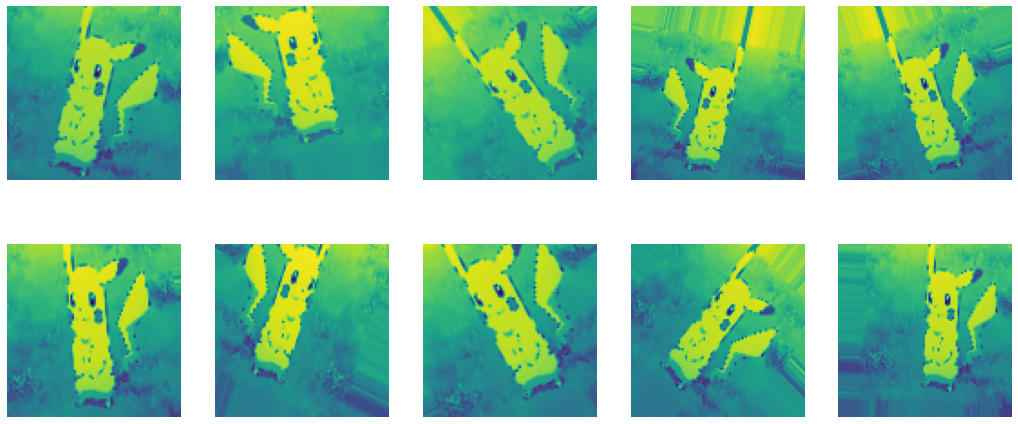

In [14]:
X_train, X_test, y_train, y_test, datagen = getImages(96,96,grayScale=True,datagenEnabled=True)

In [15]:
def train3():
        with wandb.init(config=sweep_config):
            config = wandb.config
            if wandb.run:
                model = Sequential()
                #model.add(GaussianNoise(0,input_shape = (96, 96, 1)))
                model.add(Conv2D(32, 3, padding = 'same', activation = 'relu',input_shape = (96, 96,1),  kernel_initializer = 'he_normal'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Flatten())
                model.add(Dense(512, activation = 'relu'))
                model.add(BatchNormalization())
                model.add(Dropout(0.5))
                model.add(Dense(256, activation = 'relu'))
                model.add(BatchNormalization())
                model.add(Dropout(0.5))
                model.add(Dense(len(imbalanced), activation = 'softmax'))

                checkpoint = ModelCheckpoint('../working/model_9696_transformation_grayscale.hdf5', verbose = 1, monitor = 'val_accuracy', save_best_only = True)
                earlyStoppingCallback = EarlyStopping(monitor='loss', patience=3)

                opt = getOpt(config.optimizer, config.learning_rate)
            
                model.compile(optimizer = opt, loss = config.loss, metrics = ['accuracy'])
                history = model.fit(
                    datagen.flow(X_train, y_train, batch_size = config.batch_size),
                    epochs = config.epochs,
                    validation_data = (X_test, y_test),steps_per_epoch=len(X_train) // config.batch_size, 
                    callbacks = [WandbCallback(),earlyStoppingCallback]
                    )   


In [16]:
%%time
wandb.init(project="NN-zadanie2")
sweep_config['name'] = "NN-zadanie2-sweep-9696transformation-grayscale"
sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id, function=train3, count=20)

wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 2u78s44p
Sweep URL: https://wandb.ai/ramang/uncategorized/sweeps/2u78s44p


wandb: Agent Starting Run: 43b8qf7p with config:
wandb: 	batch_size: 37
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 72
wandb: 	gauss: 0.27747774733500097
wandb: 	learning_rate: 0.07587434361350207
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: SGD
wandb: 	pooling: 3


Epoch 1/72
31/31 [==============================] - 1s 32ms/step - loss: 2.4210 - accuracy: 0.2346 - val_loss: 4.1404 - val_accuracy: 0.2041
Epoch 2/72
31/31 [==============================] - 1s 26ms/step - loss: 2.0103 - accuracy: 0.2406 - val_loss: 2.5932 - val_accuracy: 0.2041
Epoch 3/72
31/31 [==============================] - 1s 26ms/step - loss: 1.8052 - accuracy: 0.2856 - val_loss: 1.8714 - val_accuracy: 0.2721
Epoch 4/72
31/31 [==============================] - 1s 25ms/step - loss: 1.7707 - accuracy: 0.2909 - val_loss: 1.6080 - val_accuracy: 0.3231
Epoch 5/72
31/31 [==============================] - 1s 24ms/step - loss: 1.7624 - accuracy: 0.2821 - val_loss: 1.6820 - val_accuracy: 0.2279
Epoch 6/72
31/31 [==============================] - 1s 25ms/step - loss: 1.7096 - accuracy: 0.3286 - val_loss: 1.6916 - val_accuracy: 0.2449
Epoch 7/72
31/31 [==============================] - 1s 24ms/step - loss: 1.6968 - accuracy: 0.3049 - val_loss: 1.6809 - val_accuracy: 0.2653
Epoch 8/72
31

epoch,17
loss,1.58517
accuracy,0.37083
val_loss,1.44401
val_accuracy,0.39456
_runtime,19
_timestamp,1618269434
_step,17
best_val_loss,1.37333
best_epoch,16


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▅▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
accuracy,▁▁▃▃▃▅▄▅▅▆▆▆▇▇█▆▇▇
val_loss,█▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▁▄▅▂▃▃▁▄▂▂▃▅▄█▆█▇
_runtime,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇█
_timestamp,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇█
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: rpch2swj with config:
wandb: 	batch_size: 21
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 81
wandb: 	gauss: 0.12382960675195126
wandb: 	learning_rate: 0.004132686100242211
wandb: 	loss: poisson
wandb: 	optimizer: RMSprop
wandb: 	pooling: 3


Epoch 1/81
55/55 [==============================] - 1s 19ms/step - loss: 0.6792 - accuracy: 0.2686 - val_loss: 0.8575 - val_accuracy: 0.2925
Epoch 2/81
55/55 [==============================] - 1s 16ms/step - loss: 0.5995 - accuracy: 0.2712 - val_loss: 0.5732 - val_accuracy: 0.2993
Epoch 3/81
55/55 [==============================] - 1s 16ms/step - loss: 0.5563 - accuracy: 0.2894 - val_loss: 0.5201 - val_accuracy: 0.3061
Epoch 4/81
55/55 [==============================] - 1s 15ms/step - loss: 0.5202 - accuracy: 0.3536 - val_loss: 0.8672 - val_accuracy: 0.2177
Epoch 5/81
55/55 [==============================] - 1s 15ms/step - loss: 0.4993 - accuracy: 0.4012 - val_loss: 0.7389 - val_accuracy: 0.2381
Epoch 6/81
55/55 [==============================] - 1s 15ms/step - loss: 0.4871 - accuracy: 0.4203 - val_loss: 0.8398 - val_accuracy: 0.2585
Epoch 7/81
55/55 [==============================] - 1s 15ms/step - loss: 0.4761 - accuracy: 0.4558 - val_loss: 0.5720 - val_accuracy: 0.3571
Epoch 8/81
55

epoch,38
loss,0.35989
accuracy,0.71404
val_loss,0.34415
val_accuracy,0.7517
_runtime,40
_timestamp,1618269479
_step,38
best_val_loss,0.34096
best_epoch,31


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▁▁▂▃▃▄▄▄▄▄▅▅▅▆▅▆▆▇▇▆▇▇▇▇▇▇▇███████████
val_loss,█▄▃█▆█▄▃▃▃▄▃▂▂▂▃▁▁▂▃▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▁▄▁▁
val_accuracy,▂▂▂▁▁▂▃▃▃▄▃▄▅▆▅▅▇▇▆▅▆▆▆▆▆▆▇▇▇▆▆█▆▇▆▇▄▇█
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: wfp9fnpi with config:
wandb: 	batch_size: 51
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 65
wandb: 	gauss: 0.09340727998936577
wandb: 	learning_rate: 0.06920698182619532
wandb: 	loss: poisson
wandb: 	optimizer: Adam
wandb: 	pooling: 2


Epoch 1/65
23/23 [==============================] - 1s 46ms/step - loss: 1.0303 - accuracy: 0.2402 - val_loss: 2.7657 - val_accuracy: 0.2041
Epoch 2/65
23/23 [==============================] - 1s 38ms/step - loss: 0.6754 - accuracy: 0.3238 - val_loss: 2.7456 - val_accuracy: 0.2007
Epoch 3/65
23/23 [==============================] - 1s 40ms/step - loss: 0.6034 - accuracy: 0.2865 - val_loss: 1.3164 - val_accuracy: 0.2347
Epoch 4/65
23/23 [==============================] - 1s 35ms/step - loss: 0.5842 - accuracy: 0.3016 - val_loss: 1.5395 - val_accuracy: 0.2347
Epoch 5/65
23/23 [==============================] - 1s 39ms/step - loss: 0.5216 - accuracy: 0.3416 - val_loss: 1.2439 - val_accuracy: 0.3163
Epoch 6/65
23/23 [==============================] - 1s 39ms/step - loss: 0.5368 - accuracy: 0.3149 - val_loss: 0.8823 - val_accuracy: 0.2041
Epoch 7/65
23/23 [==============================] - 1s 40ms/step - loss: 0.5279 - accuracy: 0.3514 - val_loss: 0.5990 - val_accuracy: 0.2687
Epoch 8/65
23

epoch,14
loss,0.53478
accuracy,0.36477
val_loss,1.18352
val_accuracy,0.33673
_runtime,19
_timestamp,1618269502
_step,14
best_val_loss,0.54924
best_epoch,7


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▂▂▁▂▁▁▁▁▁▁▂▂▁
accuracy,▁▅▃▄▅▄▆▇▇▇██▇▅▆
val_loss,██▃▄▃▂▁▁▁▁▁▁▂▁▃
val_accuracy,▁▁▂▂▆▁▄▁▆▃█▇█▆▇
_runtime,▁▂▂▃▃▄▄▅▅▅▆▆▇▇█
_timestamp,▁▂▂▃▃▄▄▅▅▅▆▆▇▇█
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: omiasryl with config:
wandb: 	batch_size: 36
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 39
wandb: 	gauss: 0.4557208256462488
wandb: 	learning_rate: 0.060625409650083256
wandb: 	loss: poisson
wandb: 	optimizer: RMSprop
wandb: 	pooling: 2


Epoch 1/39
32/32 [==============================] - 1s 33ms/step - loss: 1.6928 - accuracy: 0.2450 - val_loss: 2.6147 - val_accuracy: 0.2415
Epoch 2/39
32/32 [==============================] - 1s 25ms/step - loss: 0.7818 - accuracy: 0.2730 - val_loss: 2.7615 - val_accuracy: 0.2041
Epoch 3/39
32/32 [==============================] - 1s 27ms/step - loss: 0.5733 - accuracy: 0.2564 - val_loss: 1.9396 - val_accuracy: 0.2075
Epoch 4/39
32/32 [==============================] - 1s 24ms/step - loss: 0.5653 - accuracy: 0.2836 - val_loss: 2.1197 - val_accuracy: 0.1395
Epoch 5/39
32/32 [==============================] - 1s 25ms/step - loss: 0.5766 - accuracy: 0.2581 - val_loss: 1.9669 - val_accuracy: 0.2755
Epoch 6/39
32/32 [==============================] - 1s 27ms/step - loss: 0.5602 - accuracy: 0.2757 - val_loss: 1.5405 - val_accuracy: 0.2075
Epoch 7/39
32/32 [==============================] - 1s 27ms/step - loss: 0.5765 - accuracy: 0.2450 - val_loss: 0.7480 - val_accuracy: 0.3197
Epoch 8/39
32

epoch,8
loss,0.56697
accuracy,0.2827
val_loss,0.70749
val_accuracy,0.33333
_runtime,13
_timestamp,1618269525
_step,8
best_val_loss,0.60995
best_epoch,7


epoch,▁▂▃▄▅▅▆▇█
loss,█▂▁▁▁▁▁▁▁
accuracy,▁▅▃▆▃▅▁█▆
val_loss,██▅▆▅▄▁▁▁
val_accuracy,▅▃▃▁▆▃█▄█
_runtime,▁▁▂▃▄▅▆▇█
_timestamp,▁▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▅▆▇█


wandb: Agent Starting Run: fofvzfxf with config:
wandb: 	batch_size: 23
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 62
wandb: 	gauss: 0.08944347809235986
wandb: 	learning_rate: 0.011292449779035941
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adagrad
wandb: 	pooling: 3


Epoch 1/62
51/51 [==============================] - 2s 31ms/step - loss: 2.5109 - accuracy: 0.2240 - val_loss: 1.6962 - val_accuracy: 0.2483
Epoch 2/62
51/51 [==============================] - 1s 16ms/step - loss: 2.2278 - accuracy: 0.2387 - val_loss: 2.1226 - val_accuracy: 0.2075
Epoch 3/62
51/51 [==============================] - 1s 16ms/step - loss: 2.1191 - accuracy: 0.2448 - val_loss: 2.0313 - val_accuracy: 0.2143
Epoch 4/62
51/51 [==============================] - 1s 16ms/step - loss: 2.0356 - accuracy: 0.2569 - val_loss: 2.0224 - val_accuracy: 0.2109
Epoch 5/62
51/51 [==============================] - 1s 16ms/step - loss: 1.9747 - accuracy: 0.2526 - val_loss: 2.1759 - val_accuracy: 0.2177
Epoch 6/62
51/51 [==============================] - 1s 16ms/step - loss: 1.8918 - accuracy: 0.2595 - val_loss: 2.1515 - val_accuracy: 0.2279
Epoch 7/62
51/51 [==============================] - 1s 16ms/step - loss: 1.8063 - accuracy: 0.2812 - val_loss: 2.1677 - val_accuracy: 0.2347
Epoch 8/62
51

epoch,21
loss,1.59029
accuracy,0.31337
val_loss,1.64365
val_accuracy,0.26871
_runtime,24
_timestamp,1618269556
_step,21
best_val_loss,1.6059
best_epoch,19


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▆▅▄▄▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁
accuracy,▁▂▃▃▃▄▅▆▅▅▆▆▆▅▄▇▇▇█▆██
val_loss,▂▆▅▅▇▆▇█▆▇▄▃▂▂▂▂▁▂▂▁▂▁
val_accuracy,▆▃▄▄▄▅▅▃▁▁▂▃▅▅▅▆▇▆▇█▆█
_runtime,▁▁▁▂▂▃▃▃▃▄▄▅▅▅▆▆▆▆▇▇██
_timestamp,▁▁▁▂▂▃▃▃▃▄▄▅▅▅▆▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: nugrdtu0 with config:
wandb: 	batch_size: 55
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 90
wandb: 	gauss: 0.1476123883450025
wandb: 	learning_rate: 0.08806297478326708
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adam
wandb: 	pooling: 3


Epoch 1/90
21/21 [==============================] - 1s 45ms/step - loss: 4.2908 - accuracy: 0.2052 - val_loss: 7435.0015 - val_accuracy: 0.2075
Epoch 2/90
21/21 [==============================] - 1s 37ms/step - loss: 2.4976 - accuracy: 0.2562 - val_loss: 478.9035 - val_accuracy: 0.1905
Epoch 3/90
21/21 [==============================] - 1s 37ms/step - loss: 2.0215 - accuracy: 0.2518 - val_loss: 34.3009 - val_accuracy: 0.1871
Epoch 4/90
21/21 [==============================] - 1s 37ms/step - loss: 1.8056 - accuracy: 0.2518 - val_loss: 10.9505 - val_accuracy: 0.2075
Epoch 5/90
21/21 [==============================] - 1s 37ms/step - loss: 1.7577 - accuracy: 0.2545 - val_loss: 3.0067 - val_accuracy: 0.1973
Epoch 6/90
21/21 [==============================] - 1s 37ms/step - loss: 1.6817 - accuracy: 0.2634 - val_loss: 2.6989 - val_accuracy: 0.2007
Epoch 7/90
21/21 [==============================] - 1s 36ms/step - loss: 1.6555 - accuracy: 0.2795 - val_loss: 2.1557 - val_accuracy: 0.2619
Epoch 

epoch,9
loss,1.67218
accuracy,0.26696
val_loss,1.51995
val_accuracy,0.36395
_runtime,13
_timestamp,1618269573
_step,9
best_val_loss,1.51995
best_epoch,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▁▁▁▁▁▁▁
accuracy,▁▅▅▅▅▆▇▆█▆
val_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▂▁▁▂▁▂▄▂▅█
_runtime,▁▁▂▃▄▅▆▆▇█
_timestamp,▁▁▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: i18kvp4s with config:
wandb: 	batch_size: 20
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 55
wandb: 	gauss: 0.22066176296022239
wandb: 	learning_rate: 0.09952897284777038
wandb: 	loss: poisson
wandb: 	optimizer: SGD
wandb: 	pooling: 2


Epoch 1/55
58/58 [==============================] - 1s 18ms/step - loss: 0.6642 - accuracy: 0.2719 - val_loss: 0.5333 - val_accuracy: 0.2109
Epoch 2/55
58/58 [==============================] - 1s 14ms/step - loss: 0.6062 - accuracy: 0.2615 - val_loss: 0.6834 - val_accuracy: 0.2347
Epoch 3/55
58/58 [==============================] - 1s 14ms/step - loss: 0.5784 - accuracy: 0.2840 - val_loss: 0.6697 - val_accuracy: 0.2041
Epoch 4/55
58/58 [==============================] - 1s 14ms/step - loss: 0.5375 - accuracy: 0.3558 - val_loss: 0.8996 - val_accuracy: 0.2007
Epoch 5/55
58/58 [==============================] - 1s 14ms/step - loss: 0.5295 - accuracy: 0.3264 - val_loss: 0.7524 - val_accuracy: 0.1735
Epoch 6/55
58/58 [==============================] - 1s 14ms/step - loss: 0.5167 - accuracy: 0.3446 - val_loss: 0.6877 - val_accuracy: 0.1701
Epoch 7/55
58/58 [==============================] - 1s 14ms/step - loss: 0.5192 - accuracy: 0.3411 - val_loss: 0.6187 - val_accuracy: 0.2313
Epoch 8/55
58

epoch,15
loss,0.49818
accuracy,0.38268
val_loss,1.05693
val_accuracy,0.27891
_runtime,18
_timestamp,1618269597
_step,15
best_val_loss,0.53327
best_epoch,0


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▆▄▃▂▂▂▂▂▂▂▁▁▁▁▁
accuracy,▂▁▂▆▅▆▅▅▅▆▆▆█▇▇█
val_loss,▁▃▃▆▄▃▂▂▃▃▃▅▇▅▆█
val_accuracy,▄▅▃▃▁▁▅▅▆▂▆▄▁▆▆█
_runtime,▁▂▂▃▃▄▄▄▅▅▆▆▇▇▇█
_timestamp,▁▂▂▃▃▄▄▄▅▅▆▆▇▇▇█
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██


wandb: Agent Starting Run: k5do2q79 with config:
wandb: 	batch_size: 60
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 38
wandb: 	gauss: 0.2506687775755023
wandb: 	learning_rate: 0.03618428960885193
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: RMSprop
wandb: 	pooling: 2


Epoch 1/38
19/19 [==============================] - 1s 53ms/step - loss: 4.4403 - accuracy: 0.2574 - val_loss: 342.5912 - val_accuracy: 0.1973
Epoch 2/38
19/19 [==============================] - 1s 43ms/step - loss: 2.4980 - accuracy: 0.2996 - val_loss: 107.8841 - val_accuracy: 0.1973
Epoch 3/38
19/19 [==============================] - 1s 43ms/step - loss: 1.9042 - accuracy: 0.3148 - val_loss: 28.8724 - val_accuracy: 0.1803
Epoch 4/38
19/19 [==============================] - 1s 43ms/step - loss: 1.6300 - accuracy: 0.3668 - val_loss: 3.9597 - val_accuracy: 0.2483
Epoch 5/38
19/19 [==============================] - 1s 44ms/step - loss: 1.4897 - accuracy: 0.3848 - val_loss: 3.3013 - val_accuracy: 0.2449
Epoch 6/38
19/19 [==============================] - 1s 39ms/step - loss: 1.5081 - accuracy: 0.3713 - val_loss: 5.8298 - val_accuracy: 0.2415
Epoch 7/38
19/19 [==============================] - 1s 38ms/step - loss: 1.4002 - accuracy: 0.4188 - val_loss: 4.6365 - val_accuracy: 0.2177
Epoch 8/

epoch,37
loss,0.9077
accuracy,0.66996
val_loss,1.55028
val_accuracy,0.53741
_runtime,37
_timestamp,1618269638
_step,37
best_val_loss,1.1546
best_epoch,30


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▅▆▆▆▆▇▆▆▇▇▇▇▇█▇████
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▂▂▂▂▁▃▃▃▃▃▄▆▆▂▂▄▅▃▃▆▄▃▅▇▆▄▆▇▆▄▂▅▄█▆
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: dmkj6lpg with config:
wandb: 	batch_size: 22
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 41
wandb: 	gauss: 0.43264826261694866
wandb: 	learning_rate: 0.024009054560943002
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adagrad
wandb: 	pooling: 2


Epoch 1/41
53/53 [==============================] - 1s 22ms/step - loss: 2.2458 - accuracy: 0.2767 - val_loss: 3.9577 - val_accuracy: 0.2245
Epoch 2/41
53/53 [==============================] - 1s 17ms/step - loss: 1.8924 - accuracy: 0.3183 - val_loss: 1.7900 - val_accuracy: 0.2143
Epoch 3/41
53/53 [==============================] - 1s 16ms/step - loss: 1.7774 - accuracy: 0.3053 - val_loss: 1.7984 - val_accuracy: 0.2551
Epoch 4/41
53/53 [==============================] - 1s 17ms/step - loss: 1.7075 - accuracy: 0.3252 - val_loss: 1.4908 - val_accuracy: 0.3435
Epoch 5/41
53/53 [==============================] - 1s 15ms/step - loss: 1.6192 - accuracy: 0.3495 - val_loss: 1.5094 - val_accuracy: 0.3095
Epoch 6/41
53/53 [==============================] - 1s 17ms/step - loss: 1.5795 - accuracy: 0.3461 - val_loss: 1.4352 - val_accuracy: 0.3435
Epoch 7/41
53/53 [==============================] - 1s 16ms/step - loss: 1.5448 - accuracy: 0.3582 - val_loss: 1.4596 - val_accuracy: 0.4082
Epoch 8/41
53

epoch,21
loss,1.33158
accuracy,0.44753
val_loss,1.35894
val_accuracy,0.4966
_runtime,25
_timestamp,1618269672
_step,21
best_val_loss,1.26903
best_epoch,19


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
accuracy,▁▃▂▃▄▄▄▅▄▅▆▅▆▆▆▆▇▇█▇▇█
val_loss,█▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▄▃▄▆▆▆▅▄▅▆▅▇▆▇▇▇▇██
_runtime,▁▁▂▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: qt1m4xvi with config:
wandb: 	batch_size: 33
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 72
wandb: 	gauss: 0.22330742039315193
wandb: 	learning_rate: 0.04298195462686706
wandb: 	loss: poisson
wandb: 	optimizer: Adam
wandb: 	pooling: 2


Epoch 1/72
35/35 [==============================] - 1s 30ms/step - loss: 0.8776 - accuracy: 0.2496 - val_loss: 2.7548 - val_accuracy: 0.2075
Epoch 2/72
35/35 [==============================] - 1s 22ms/step - loss: 0.6429 - accuracy: 0.2609 - val_loss: 2.7841 - val_accuracy: 0.1973
Epoch 3/72
35/35 [==============================] - 1s 26ms/step - loss: 0.5383 - accuracy: 0.3231 - val_loss: 0.5688 - val_accuracy: 0.3163
Epoch 4/72
35/35 [==============================] - 1s 22ms/step - loss: 0.5125 - accuracy: 0.3371 - val_loss: 0.7501 - val_accuracy: 0.3129
Epoch 5/72
35/35 [==============================] - 1s 25ms/step - loss: 0.5123 - accuracy: 0.3476 - val_loss: 0.5671 - val_accuracy: 0.3435
Epoch 6/72
35/35 [==============================] - 1s 25ms/step - loss: 0.5018 - accuracy: 0.3695 - val_loss: 0.5249 - val_accuracy: 0.3231
Epoch 7/72
35/35 [==============================] - 1s 22ms/step - loss: 0.5028 - accuracy: 0.3643 - val_loss: 0.6242 - val_accuracy: 0.3095
Epoch 8/72
35

epoch,10
loss,0.49951
accuracy,0.35902
val_loss,0.49034
val_accuracy,0.35714
_runtime,14
_timestamp,1618269693
_step,10
best_val_loss,0.49034
best_epoch,10


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,█▄▂▁▁▁▁▁▁▁▁
accuracy,▁▂▅▆▇███▇▇▇
val_loss,██▁▂▁▁▁▁▁▁▁
val_accuracy,▁▁▆▅▇▆▅▆▃█▇
_runtime,▁▂▃▃▄▅▆▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▆▇█
_step,▁▂▂▃▄▅▅▆▇▇█


wandb: Agent Starting Run: 0w5j5jy8 with config:
wandb: 	batch_size: 20
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 40
wandb: 	gauss: 0.24921293553214463
wandb: 	learning_rate: 0.035369206377734864
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: SGD
wandb: 	pooling: 2


Epoch 1/40
58/58 [==============================] - 1s 18ms/step - loss: 2.2530 - accuracy: 0.2519 - val_loss: 4.4055 - val_accuracy: 0.2245
Epoch 2/40
58/58 [==============================] - 1s 15ms/step - loss: 1.9232 - accuracy: 0.2961 - val_loss: 1.7307 - val_accuracy: 0.3163
Epoch 3/40
58/58 [==============================] - 1s 15ms/step - loss: 1.7510 - accuracy: 0.3255 - val_loss: 1.5878 - val_accuracy: 0.2857
Epoch 4/40
58/58 [==============================] - 1s 14ms/step - loss: 1.6583 - accuracy: 0.3351 - val_loss: 1.6119 - val_accuracy: 0.3095
Epoch 5/40
58/58 [==============================] - 1s 15ms/step - loss: 1.6418 - accuracy: 0.3359 - val_loss: 1.3897 - val_accuracy: 0.4422
Epoch 6/40
58/58 [==============================] - 1s 14ms/step - loss: 1.5466 - accuracy: 0.3740 - val_loss: 1.4321 - val_accuracy: 0.3401
Epoch 7/40
58/58 [==============================] - 1s 14ms/step - loss: 1.5571 - accuracy: 0.3775 - val_loss: 1.4798 - val_accuracy: 0.3912
Epoch 8/40
58

epoch,30
loss,1.16831
accuracy,0.55931
val_loss,1.11729
val_accuracy,0.54422
_runtime,31
_timestamp,1618269736
_step,30
best_val_loss,0.89612
best_epoch,28


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▄▄▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▃▃▄▄▄▄▅▄▅▅▆▅▆▆▆▆▆▆▆▇▇▇▇██▇██
val_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▁▂▁▁▁▂▁▁▁▁
val_accuracy,▁▃▂▂▅▃▄▅▆▅▆▆▆▆▆▇▇▇▆▄▇▇▆▇▇█▅▇█▇▆
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: kraeautz with config:
wandb: 	batch_size: 28
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 84
wandb: 	gauss: 0.4239426275106585
wandb: 	learning_rate: 0.006581486407620319
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: RMSprop
wandb: 	pooling: 2


Epoch 1/84
41/41 [==============================] - 1s 29ms/step - loss: 2.3679 - accuracy: 0.2895 - val_loss: 69.7587 - val_accuracy: 0.2211
Epoch 2/84
41/41 [==============================] - 1s 21ms/step - loss: 1.8529 - accuracy: 0.3156 - val_loss: 15.9230 - val_accuracy: 0.2381
Epoch 3/84
41/41 [==============================] - 1s 21ms/step - loss: 1.7177 - accuracy: 0.3531 - val_loss: 3.2788 - val_accuracy: 0.3163
Epoch 4/84
41/41 [==============================] - 1s 19ms/step - loss: 1.5188 - accuracy: 0.4098 - val_loss: 13.3268 - val_accuracy: 0.2279
Epoch 5/84
41/41 [==============================] - 1s 21ms/step - loss: 1.4120 - accuracy: 0.4350 - val_loss: 2.2063 - val_accuracy: 0.3231
Epoch 6/84
41/41 [==============================] - 1s 19ms/step - loss: 1.3496 - accuracy: 0.4839 - val_loss: 3.7996 - val_accuracy: 0.2857
Epoch 7/84
41/41 [==============================] - 1s 22ms/step - loss: 1.2768 - accuracy: 0.4778 - val_loss: 1.6683 - val_accuracy: 0.4558
Epoch 8/84

epoch,35
loss,0.59979
accuracy,0.78901
val_loss,1.87107
val_accuracy,0.59524
_runtime,36
_timestamp,1618269778
_step,35
best_val_loss,0.60776
best_epoch,24


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▆▆▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,▁▁▂▃▃▄▄▄▅▅▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇███▇████
val_loss,█▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▁▂▂▄▄▅▅▄▄▅▆▃▇▆▆▇▇▇▆▇▆██▆▅▆█▄▆▆▆▇▆
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 794xq70x with config:
wandb: 	batch_size: 31
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 51
wandb: 	gauss: 0.1218442094374308
wandb: 	learning_rate: 0.04145734878383406
wandb: 	loss: poisson
wandb: 	optimizer: SGD
wandb: 	pooling: 3


Epoch 1/51
37/37 [==============================] - 1s 26ms/step - loss: 0.7254 - accuracy: 0.1862 - val_loss: 0.5255 - val_accuracy: 0.1837
Epoch 2/51
37/37 [==============================] - 1s 21ms/step - loss: 0.6980 - accuracy: 0.2107 - val_loss: 0.5291 - val_accuracy: 0.2041
Epoch 3/51
37/37 [==============================] - 1s 21ms/step - loss: 0.6548 - accuracy: 0.2273 - val_loss: 0.5339 - val_accuracy: 0.2075
Epoch 4/51
37/37 [==============================] - 1s 21ms/step - loss: 0.6335 - accuracy: 0.2544 - val_loss: 0.5355 - val_accuracy: 0.2143
Epoch 5/51
37/37 [==============================] - 1s 21ms/step - loss: 0.6162 - accuracy: 0.2491 - val_loss: 0.5279 - val_accuracy: 0.2755
Epoch 6/51
37/37 [==============================] - 1s 21ms/step - loss: 0.6115 - accuracy: 0.2430 - val_loss: 0.5380 - val_accuracy: 0.2075
Epoch 7/51
37/37 [==============================] - 1s 21ms/step - loss: 0.5886 - accuracy: 0.2509 - val_loss: 0.5400 - val_accuracy: 0.2687
Epoch 8/51
37

epoch,24
loss,0.51478
accuracy,0.30682
val_loss,0.50539
val_accuracy,0.32993
_runtime,25
_timestamp,1618269821
_step,24
best_val_loss,0.50539
best_epoch,24


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▇▆▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▅▄▄▅▄▆▄▅▅▆▆▆▄▇▇▇▇▆▇▇██
val_loss,▄▅▅▆▅▆▆██▇▅▆▅▅▄▃▄▃▃▂▂▂▂▂▁
val_accuracy,▁▂▂▂▅▂▅▃▄▄▇▆▇▇█▆▇▇▇▇▇▇███
_runtime,▁▁▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇███
_timestamp,▁▁▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: dndeps35 with config:
wandb: 	batch_size: 28
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 30
wandb: 	gauss: 0.16804144713244368
wandb: 	learning_rate: 0.002316453857712464
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: RMSprop
wandb: 	pooling: 3


Epoch 1/30
41/41 [==============================] - 1s 24ms/step - loss: 2.6217 - accuracy: 0.2188 - val_loss: 1.6600 - val_accuracy: 0.2279
Epoch 2/30
41/41 [==============================] - 1s 19ms/step - loss: 2.2905 - accuracy: 0.2180 - val_loss: 1.6916 - val_accuracy: 0.1973
Epoch 3/30
41/41 [==============================] - 1s 19ms/step - loss: 2.0218 - accuracy: 0.2389 - val_loss: 1.7570 - val_accuracy: 0.2007
Epoch 4/30
41/41 [==============================] - 1s 19ms/step - loss: 1.8409 - accuracy: 0.2502 - val_loss: 2.0139 - val_accuracy: 0.2245
Epoch 5/30
41/41 [==============================] - 1s 19ms/step - loss: 1.7871 - accuracy: 0.2633 - val_loss: 1.9314 - val_accuracy: 0.2109
Epoch 6/30
41/41 [==============================] - 1s 19ms/step - loss: 1.6371 - accuracy: 0.3008 - val_loss: 1.9736 - val_accuracy: 0.2687
Epoch 7/30
41/41 [==============================] - 1s 20ms/step - loss: 1.6623 - accuracy: 0.3217 - val_loss: 1.6558 - val_accuracy: 0.3197
Epoch 8/30
41

epoch,29
loss,1.23793
accuracy,0.49172
val_loss,1.38203
val_accuracy,0.44218
_runtime,30
_timestamp,1618269856
_step,29
best_val_loss,1.2379
best_epoch,22


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
accuracy,▁▁▂▂▂▃▄▄▄▄▄▄▅▅▅▆▆▆▅▆▆▆▆▇▇▇▇███
val_loss,▅▅▆█▇█▅▆▇▄▃▃▃▂▂▂▁▁▂▅▂▂▁▁▂▂▂▆▃▂
val_accuracy,▂▁▁▂▁▃▄▂▁▃▄▆▅▆▆▆▇▇▆▅▇▆▇█▆▆█▅▆▆
_runtime,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 6f2wtovc with config:
wandb: 	batch_size: 18
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 26
wandb: 	gauss: 0.30994577610431545
wandb: 	learning_rate: 0.03111261141624784
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: RMSprop
wandb: 	pooling: 3


Epoch 1/26
65/65 [==============================] - 1s 16ms/step - loss: 3.6322 - accuracy: 0.2282 - val_loss: 32.6331 - val_accuracy: 0.1905
Epoch 2/26
65/65 [==============================] - 1s 13ms/step - loss: 2.1708 - accuracy: 0.2264 - val_loss: 2.1991 - val_accuracy: 0.2143
Epoch 3/26
65/65 [==============================] - 1s 12ms/step - loss: 1.8100 - accuracy: 0.2619 - val_loss: 3.5009 - val_accuracy: 0.2041
Epoch 4/26
65/65 [==============================] - 1s 13ms/step - loss: 1.7392 - accuracy: 0.2489 - val_loss: 4.4331 - val_accuracy: 0.2279
Epoch 5/26
65/65 [==============================] - 1s 13ms/step - loss: 1.7579 - accuracy: 0.2602 - val_loss: 2.0255 - val_accuracy: 0.2619
Epoch 6/26
65/65 [==============================] - 1s 13ms/step - loss: 1.7479 - accuracy: 0.2455 - val_loss: 1.7725 - val_accuracy: 0.3129
Epoch 7/26
65/65 [==============================] - 1s 13ms/step - loss: 1.7324 - accuracy: 0.2705 - val_loss: 1.5909 - val_accuracy: 0.3503
Epoch 8/26
6

epoch,12
loss,1.69996
accuracy,0.30424
val_loss,1.6467
val_accuracy,0.33673
_runtime,16
_timestamp,1618269877
_step,12
best_val_loss,1.54481
best_epoch,9


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▃▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▁▄▃▄▃▅▆▆▇█▇█
val_loss,█▁▁▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▁▂▄▅▇▃▃█▂▃▆
_runtime,▁▂▂▃▄▄▄▅▅▆▇▇█
_timestamp,▁▂▂▃▄▄▄▅▅▆▇▇█
_step,▁▂▂▃▃▄▅▅▆▆▇▇█


wandb: Agent Starting Run: homv09y4 with config:
wandb: 	batch_size: 31
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 66
wandb: 	gauss: 0.02403717757172319
wandb: 	learning_rate: 0.06478755475443061
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adam
wandb: 	pooling: 2


Epoch 1/66
37/37 [==============================] - 1s 30ms/step - loss: 4.0082 - accuracy: 0.2570 - val_loss: 3895.4009 - val_accuracy: 0.2041
Epoch 2/66
37/37 [==============================] - 1s 25ms/step - loss: 2.3943 - accuracy: 0.2351 - val_loss: 76.9675 - val_accuracy: 0.2075
Epoch 3/66
37/37 [==============================] - 1s 24ms/step - loss: 1.8010 - accuracy: 0.2701 - val_loss: 15.1379 - val_accuracy: 0.2279
Epoch 4/66
37/37 [==============================] - 1s 25ms/step - loss: 1.6703 - accuracy: 0.2911 - val_loss: 5.3893 - val_accuracy: 0.2075
Epoch 5/66
37/37 [==============================] - 1s 25ms/step - loss: 1.6075 - accuracy: 0.3007 - val_loss: 2.0648 - val_accuracy: 0.2381
Epoch 6/66
37/37 [==============================] - 1s 25ms/step - loss: 1.5857 - accuracy: 0.3086 - val_loss: 1.5739 - val_accuracy: 0.3129
Epoch 7/66
37/37 [==============================] - 1s 24ms/step - loss: 1.5840 - accuracy: 0.3392 - val_loss: 1.4474 - val_accuracy: 0.3095
Epoch 8/

epoch,9
loss,1.63573
accuracy,0.33042
val_loss,1.46856
val_accuracy,0.41837
_runtime,14
_timestamp,1618269896
_step,9
best_val_loss,1.44738
best_epoch,6


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▁▁▁▁▁▁▁
accuracy,▂▁▃▅▅▆██▆▇
val_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▁▂▅▄▆▅█
_runtime,▁▂▃▄▅▅▆▆▇█
_timestamp,▁▂▃▄▅▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 9izax5a0 with config:
wandb: 	batch_size: 18
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 89
wandb: 	gauss: 0.1766131614561498
wandb: 	learning_rate: 0.0901969468820956
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: RMSprop
wandb: 	pooling: 3


Epoch 1/89
65/65 [==============================] - 1s 16ms/step - loss: 6.9851 - accuracy: 0.2178 - val_loss: 165.6788 - val_accuracy: 0.2075
Epoch 2/89
65/65 [==============================] - 1s 13ms/step - loss: 2.9338 - accuracy: 0.2377 - val_loss: 67.9621 - val_accuracy: 0.2075
Epoch 3/89
65/65 [==============================] - 1s 13ms/step - loss: 2.8417 - accuracy: 0.2334 - val_loss: 5.2494 - val_accuracy: 0.1905
Epoch 4/89
65/65 [==============================] - 1s 12ms/step - loss: 2.8186 - accuracy: 0.2316 - val_loss: 7.4615 - val_accuracy: 0.2279
Epoch 5/89
65/65 [==============================] - 1s 13ms/step - loss: 2.8126 - accuracy: 0.2152 - val_loss: 4.5203 - val_accuracy: 0.1973
Epoch 6/89
65/65 [==============================] - 1s 13ms/step - loss: 2.8479 - accuracy: 0.1997 - val_loss: 6.1430 - val_accuracy: 0.2007
Epoch 7/89
65/65 [==============================] - 1s 12ms/step - loss: 2.7255 - accuracy: 0.2351 - val_loss: 6.1946 - val_accuracy: 0.2551
Epoch 8/89

epoch,14
loss,2.73036
accuracy,0.22385
val_loss,2.49286
val_accuracy,0.2483
_runtime,17
_timestamp,1618269926
_step,14
best_val_loss,2.49286
best_epoch,14


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▁▁▁▁▁▂▁▁▁▁▁▁▁
accuracy,▄█▇▇▄▁█▆▂▆▂▃▇▆▅
val_loss,█▄▁▁▁▁▁▁▁▂▁▂▁▄▁
val_accuracy,▅▅▄▆▄▄█▂█▂▁▂▅▇▇
_runtime,▁▂▂▃▃▄▅▅▅▆▆▇▇██
_timestamp,▁▂▂▃▃▄▅▅▅▆▆▇▇██
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: guqwuka3 with config:
wandb: 	batch_size: 26
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 71
wandb: 	gauss: 0.14016409446968936
wandb: 	learning_rate: 0.09005025297783445
wandb: 	loss: poisson
wandb: 	optimizer: RMSprop
wandb: 	pooling: 3


Epoch 1/71
45/45 [==============================] - 1s 22ms/step - loss: 2.5138 - accuracy: 0.2245 - val_loss: 2.7548 - val_accuracy: 0.2075
Epoch 2/71
45/45 [==============================] - 1s 18ms/step - loss: 2.5676 - accuracy: 0.2393 - val_loss: 2.7657 - val_accuracy: 0.2041
Epoch 3/71
45/45 [==============================] - 1s 18ms/step - loss: 2.5490 - accuracy: 0.2602 - val_loss: 2.8388 - val_accuracy: 0.1701
Epoch 4/71
45/45 [==============================] - 1s 18ms/step - loss: 2.5142 - accuracy: 0.2663 - val_loss: 2.4151 - val_accuracy: 0.3095


epoch,3
loss,2.51415
accuracy,0.26632
val_loss,2.4151
val_accuracy,0.30952
_runtime,8
_timestamp,1618269939
_step,3
best_val_loss,2.4151
best_epoch,3


epoch,▁▃▆█
loss,▁█▆▁
accuracy,▁▃▇█
val_loss,▇▇█▁
val_accuracy,▃▃▁█
_runtime,▁▃▆█
_timestamp,▁▃▆█
_step,▁▃▆█


wandb: Agent Starting Run: 24zeoasq with config:
wandb: 	batch_size: 37
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 53
wandb: 	gauss: 0.1312741615227897
wandb: 	learning_rate: 0.004652874518096673
wandb: 	loss: poisson
wandb: 	optimizer: SGD
wandb: 	pooling: 2


Epoch 1/53
31/31 [==============================] - 1s 37ms/step - loss: 0.7276 - accuracy: 0.2390 - val_loss: 0.5270 - val_accuracy: 0.2143
Epoch 2/53
31/31 [==============================] - 1s 27ms/step - loss: 0.7266 - accuracy: 0.2592 - val_loss: 0.5237 - val_accuracy: 0.2483
Epoch 3/53
31/31 [==============================] - 1s 27ms/step - loss: 0.7138 - accuracy: 0.2373 - val_loss: 0.5170 - val_accuracy: 0.2959
Epoch 4/53
31/31 [==============================] - 1s 28ms/step - loss: 0.7022 - accuracy: 0.2408 - val_loss: 0.5119 - val_accuracy: 0.3163
Epoch 5/53
31/31 [==============================] - 1s 27ms/step - loss: 0.7029 - accuracy: 0.2469 - val_loss: 0.5079 - val_accuracy: 0.3333
Epoch 6/53
31/31 [==============================] - 1s 25ms/step - loss: 0.6848 - accuracy: 0.2513 - val_loss: 0.5107 - val_accuracy: 0.3163
Epoch 7/53
31/31 [==============================] - 1s 25ms/step - loss: 0.6898 - accuracy: 0.2575 - val_loss: 0.5113 - val_accuracy: 0.3197
Epoch 8/53
31

epoch,12
loss,0.65263
accuracy,0.27241
val_loss,0.49703
val_accuracy,0.36735
_runtime,16
_timestamp,1618269959
_step,12
best_val_loss,0.49703
best_epoch,12


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,██▇▆▆▄▅▃▃▁▁▁▁
accuracy,▁▃▁▁▂▂▃▃▁█▆▇▅
val_loss,█▇▆▄▄▄▄▃▃▃▂▂▁
val_accuracy,▁▃▅▆▆▆▆▇▇▇▇▇█
_runtime,▁▁▂▂▃▄▅▅▆▇▇▇█
_timestamp,▁▁▂▂▃▄▅▅▆▇▇▇█
_step,▁▂▂▃▃▄▅▅▆▆▇▇█


wandb: Agent Starting Run: 10znjztt with config:
wandb: 	batch_size: 51
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 88
wandb: 	gauss: 0.49816571393953296
wandb: 	learning_rate: 0.011509454879700698
wandb: 	loss: poisson
wandb: 	optimizer: SGD
wandb: 	pooling: 2


Epoch 1/88
23/23 [==============================] - 1s 42ms/step - loss: 0.7386 - accuracy: 0.2028 - val_loss: 0.5596 - val_accuracy: 0.2653
Epoch 2/88
23/23 [==============================] - 1s 37ms/step - loss: 0.7165 - accuracy: 0.2276 - val_loss: 0.5179 - val_accuracy: 0.2993
Epoch 3/88
23/23 [==============================] - 1s 34ms/step - loss: 0.7038 - accuracy: 0.2215 - val_loss: 0.5520 - val_accuracy: 0.2585
Epoch 4/88
23/23 [==============================] - 1s 34ms/step - loss: 0.6870 - accuracy: 0.2633 - val_loss: 0.5332 - val_accuracy: 0.1939
Epoch 5/88
23/23 [==============================] - 1s 34ms/step - loss: 0.6744 - accuracy: 0.2651 - val_loss: 0.5424 - val_accuracy: 0.2075
Epoch 6/88
23/23 [==============================] - 1s 34ms/step - loss: 0.6678 - accuracy: 0.2633 - val_loss: 0.5252 - val_accuracy: 0.2687
Epoch 7/88
23/23 [==============================] - 1s 34ms/step - loss: 0.6544 - accuracy: 0.2865 - val_loss: 0.5449 - val_accuracy: 0.2483
Epoch 8/88
23

epoch,17
loss,0.60032
accuracy,0.31495
val_loss,0.56085
val_accuracy,0.35714
_runtime,20
_timestamp,1618269985
_step,17
best_val_loss,0.49995
best_epoch,9


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▇▆▆▅▅▄▃▃▄▃▂▂▂▁▂▁▁
accuracy,▁▂▂▄▄▄▅▅▅▅▆▇▇▇▇▇█▇
val_loss,▆▃▅▄▅▃▅▄▁▁▂▆▃█▆▆▇▆
val_accuracy,▃▄▃▁▁▃▃▃▇██▄▆▆▅▆▆▆
_runtime,▁▁▂▂▃▃▄▄▄▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▃▃▄▄▄▅▅▆▆▇▇▇██
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


Wall time: 9min 39s


# RGB 96x96 - benchmark, notransformation, gauss

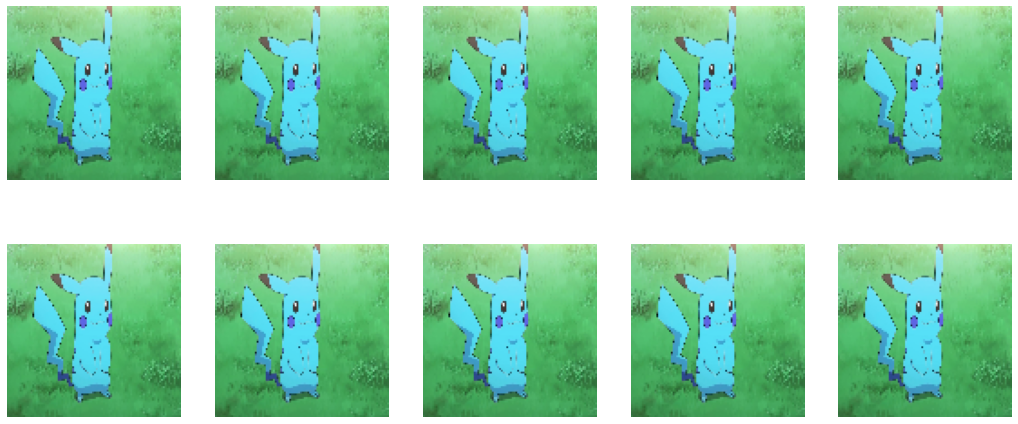

In [17]:
X_train, X_test, y_train, y_test, datagen = getImages(96,96,grayScale=False,datagenEnabled=False)

In [18]:
def train4():
        with wandb.init(config=sweep_config):
            config = wandb.config
            if wandb.run:
                model = Sequential()
                model.add(GaussianNoise(config.gauss,input_shape = (96, 96, 3)))
                model.add(Conv2D(32, 3, padding = 'same', activation = 'relu',  kernel_initializer = 'he_normal'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Flatten())
                model.add(Dense(512, activation = 'relu'))
                model.add(BatchNormalization())
                model.add(Dropout(0.5))
                model.add(Dense(256, activation = 'relu'))
                model.add(BatchNormalization())
                model.add(Dropout(0.5))
                model.add(Dense(len(imbalanced), activation = 'softmax'))

                checkpoint = ModelCheckpoint('../working/model_9696_notransformation_gauss.hdf5', verbose = 1, monitor = 'val_accuracy', save_best_only = True)
                earlyStoppingCallback = EarlyStopping(monitor='loss', patience=3)

                opt = getOpt(config.optimizer, config.learning_rate)
            
                model.compile(optimizer = opt, loss = config.loss, metrics = ['accuracy'])
                history = model.fit(
                    datagen.flow(X_train, y_train, batch_size = config.batch_size),
                    epochs = config.epochs,
                    validation_data = (X_test, y_test),steps_per_epoch=len(X_train) // config.batch_size, 
                    callbacks = [WandbCallback(),earlyStoppingCallback]
                    )   


In [19]:
%%time
wandb.init(project="NN-zadanie2")
sweep_config['name'] = "NN-zadanie2-sweep-9696notransformation-gauss"
sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id, function=train4, count=20)

wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 3qa3zebm
Sweep URL: https://wandb.ai/ramang/uncategorized/sweeps/3qa3zebm


wandb: Agent Starting Run: 7y6hj6y8 with config:
wandb: 	batch_size: 22
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 91
wandb: 	gauss: 0.35715183927767447
wandb: 	learning_rate: 0.07420780194471663
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adagrad
wandb: 	pooling: 3


Epoch 1/91
53/53 [==============================] - 1s 15ms/step - loss: 2.3006 - accuracy: 0.3348 - val_loss: 1.9422 - val_accuracy: 0.4082
Epoch 2/91
53/53 [==============================] - 0s 9ms/step - loss: 1.4311 - accuracy: 0.4493 - val_loss: 5.2528 - val_accuracy: 0.2075
Epoch 3/91
53/53 [==============================] - 0s 9ms/step - loss: 1.2397 - accuracy: 0.4944 - val_loss: 6.3090 - val_accuracy: 0.2075
Epoch 4/91
53/53 [==============================] - 0s 9ms/step - loss: 1.0980 - accuracy: 0.5559 - val_loss: 3.7594 - val_accuracy: 0.2075
Epoch 5/91
53/53 [==============================] - 0s 9ms/step - loss: 0.9940 - accuracy: 0.6193 - val_loss: 3.3734 - val_accuracy: 0.2415
Epoch 6/91
53/53 [==============================] - 0s 9ms/step - loss: 0.8873 - accuracy: 0.6678 - val_loss: 3.2169 - val_accuracy: 0.2993
Epoch 7/91
53/53 [==============================] - 0s 9ms/step - loss: 0.8537 - accuracy: 0.6852 - val_loss: 2.9903 - val_accuracy: 0.2517
Epoch 8/91
53/53 [=

epoch,25
loss,0.57631
accuracy,0.80833
val_loss,7.1754
val_accuracy,0.2551
_runtime,17
_timestamp,1618270032
_step,25
best_val_loss,1.94217
best_epoch,0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▃▄▅▆▆▇▇▇▇▇▇▇█▇▇█████████
val_loss,▁▃▃▂▂▂▂▃▂▃▃▆▅▆▇█▅▄▃▄▃▄▄▄▅▄
val_accuracy,█▁▁▁▂▄▃▃▇▅▂▁▁▁▁▁▁▆▂▁▄▅▄▂▁▃
_runtime,▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇██
_timestamp,▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: z2ei09kd with config:
wandb: 	batch_size: 18
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 54
wandb: 	gauss: 0.2999626490673119
wandb: 	learning_rate: 0.027744389647707403
wandb: 	loss: poisson
wandb: 	optimizer: Adam
wandb: 	pooling: 2


Epoch 1/54
65/65 [==============================] - 1s 18ms/step - loss: 0.7051 - accuracy: 0.4105 - val_loss: 1.7438 - val_accuracy: 0.3537
Epoch 2/54
65/65 [==============================] - 1s 15ms/step - loss: 0.4646 - accuracy: 0.6007 - val_loss: 1.1971 - val_accuracy: 0.5374
Epoch 3/54
65/65 [==============================] - 1s 15ms/step - loss: 0.3644 - accuracy: 0.7303 - val_loss: 0.9926 - val_accuracy: 0.4660
Epoch 4/54
65/65 [==============================] - 1s 15ms/step - loss: 0.3451 - accuracy: 0.7554 - val_loss: 0.3965 - val_accuracy: 0.6939
Epoch 5/54
65/65 [==============================] - 1s 15ms/step - loss: 0.3214 - accuracy: 0.7969 - val_loss: 0.3747 - val_accuracy: 0.7211
Epoch 6/54
65/65 [==============================] - 1s 15ms/step - loss: 0.3354 - accuracy: 0.7744 - val_loss: 0.2727 - val_accuracy: 0.8912
Epoch 7/54
65/65 [==============================] - 1s 13ms/step - loss: 0.3085 - accuracy: 0.8202 - val_loss: 0.4426 - val_accuracy: 0.6224
Epoch 8/54
65

epoch,9
loss,0.31644
accuracy,0.80985
val_loss,0.64629
val_accuracy,0.57483
_runtime,14
_timestamp,1618270051
_step,9
best_val_loss,0.27266
best_epoch,5


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▂▂▁▁▁▁▁▁
accuracy,▁▄▆▇█▇██▇█
val_loss,█▅▄▂▁▁▂▁▁▃
val_accuracy,▁▃▂▅▆█▅▇▇▄
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 79axi3zm with config:
wandb: 	batch_size: 18
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 59
wandb: 	gauss: 0.44085753668826677
wandb: 	learning_rate: 0.08495175612403633
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: RMSprop
wandb: 	pooling: 3


Epoch 1/59
65/65 [==============================] - 1s 13ms/step - loss: 6.3415 - accuracy: 0.3034 - val_loss: 50.0571 - val_accuracy: 0.1973
Epoch 2/59
65/65 [==============================] - 1s 9ms/step - loss: 2.4670 - accuracy: 0.3794 - val_loss: 88.3025 - val_accuracy: 0.2041
Epoch 3/59
65/65 [==============================] - 1s 9ms/step - loss: 2.2809 - accuracy: 0.4054 - val_loss: 151.0219 - val_accuracy: 0.2075
Epoch 4/59
65/65 [==============================] - 1s 10ms/step - loss: 2.0665 - accuracy: 0.4685 - val_loss: 12.4932 - val_accuracy: 0.4728
Epoch 5/59
65/65 [==============================] - 1s 10ms/step - loss: 2.0379 - accuracy: 0.5264 - val_loss: 5.3179 - val_accuracy: 0.4626
Epoch 6/59
65/65 [==============================] - 1s 10ms/step - loss: 1.8603 - accuracy: 0.5730 - val_loss: 5.0148 - val_accuracy: 0.4966
Epoch 7/59
65/65 [==============================] - 1s 9ms/step - loss: 1.6887 - accuracy: 0.6291 - val_loss: 11.7640 - val_accuracy: 0.4830
Epoch 8/59

epoch,9
loss,1.76182
accuracy,0.6707
val_loss,3.19338
val_accuracy,0.46599
_runtime,11
_timestamp,1618270071
_step,9
best_val_loss,2.67658
best_epoch,7


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▂▁▁▁▁▁
accuracy,▁▂▃▄▅▆▇███
val_loss,▃▅█▁▁▁▁▁▁▁
val_accuracy,▁▁▁▅▄▅▅█▅▄
_runtime,▁▂▃▃▅▆▆▇██
_timestamp,▁▂▃▃▅▆▆▇██
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: lrdfaj1a with config:
wandb: 	batch_size: 21
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 70
wandb: 	gauss: 0.39028772631244885
wandb: 	learning_rate: 0.06190346843976549
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adagrad
wandb: 	pooling: 2


Epoch 1/70
55/55 [==============================] - 1s 19ms/step - loss: 1.9361 - accuracy: 0.4428 - val_loss: 3.3967 - val_accuracy: 0.4422
Epoch 2/70
55/55 [==============================] - 1s 14ms/step - loss: 1.0394 - accuracy: 0.6568 - val_loss: 4.1125 - val_accuracy: 0.2857
Epoch 3/70
55/55 [==============================] - 1s 14ms/step - loss: 0.8291 - accuracy: 0.7184 - val_loss: 6.7423 - val_accuracy: 0.2041
Epoch 4/70
55/55 [==============================] - 1s 14ms/step - loss: 0.6568 - accuracy: 0.7808 - val_loss: 3.6377 - val_accuracy: 0.2789
Epoch 5/70
55/55 [==============================] - 1s 15ms/step - loss: 0.6344 - accuracy: 0.7834 - val_loss: 2.4813 - val_accuracy: 0.3367
Epoch 6/70
55/55 [==============================] - 1s 14ms/step - loss: 0.5783 - accuracy: 0.8050 - val_loss: 3.7553 - val_accuracy: 0.2041
Epoch 7/70
55/55 [==============================] - 1s 13ms/step - loss: 0.5258 - accuracy: 0.8276 - val_loss: 5.4050 - val_accuracy: 0.1973
Epoch 8/70
55

epoch,23
loss,0.33319
accuracy,0.87868
val_loss,22.77104
val_accuracy,0.22449
_runtime,24
_timestamp,1618270100
_step,23
best_val_loss,2.48126
best_epoch,4


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇█████████
val_loss,▁▂▂▁▁▁▂▂▂▂▃▄▄▄▄▄▅▅▇▇▅▅▇█
val_accuracy,█▄▁▃▅▁▁▂▂▅▅▃▃▄▂▂▃▁▂▁▃▂▂▂
_runtime,▁▁▁▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇██
_timestamp,▁▁▁▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: n7cne9j6 with config:
wandb: 	batch_size: 31
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 68
wandb: 	gauss: 0.02766263011506631
wandb: 	learning_rate: 0.01052140357322392
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adam
wandb: 	pooling: 2


Epoch 1/68
37/37 [==============================] - 1s 26ms/step - loss: 1.6492 - accuracy: 0.5245 - val_loss: 151.0542 - val_accuracy: 0.2313
Epoch 2/68
37/37 [==============================] - 1s 21ms/step - loss: 0.8021 - accuracy: 0.7605 - val_loss: 20.7950 - val_accuracy: 0.3333
Epoch 3/68
37/37 [==============================] - 1s 21ms/step - loss: 0.5277 - accuracy: 0.8365 - val_loss: 1.7323 - val_accuracy: 0.6599
Epoch 4/68
37/37 [==============================] - 1s 18ms/step - loss: 0.5413 - accuracy: 0.8138 - val_loss: 1.7651 - val_accuracy: 0.5850
Epoch 5/68
37/37 [==============================] - 1s 21ms/step - loss: 0.4302 - accuracy: 0.8584 - val_loss: 0.6092 - val_accuracy: 0.8095
Epoch 6/68
37/37 [==============================] - 1s 18ms/step - loss: 0.4879 - accuracy: 0.8488 - val_loss: 0.9211 - val_accuracy: 0.7449
Epoch 7/68
37/37 [==============================] - 1s 18ms/step - loss: 0.4385 - accuracy: 0.8706 - val_loss: 0.8015 - val_accuracy: 0.7925
Epoch 8/68

epoch,18
loss,0.28427
accuracy,0.90822
val_loss,0.33208
val_accuracy,0.90816
_runtime,19
_timestamp,1618270126
_step,18
best_val_loss,0.26078
best_epoch,15


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▄▃▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁
accuracy,▁▅▆▆▇▇▇▇▇█▇▇███████
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▅▅▇▆▇█▆█▇███▇█▇██
_runtime,▁▁▂▃▃▃▃▃▄▅▅▅▅▆▇▇▇▇█
_timestamp,▁▁▂▃▃▃▃▃▄▅▅▅▅▆▇▇▇▇█
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: abr1o905 with config:
wandb: 	batch_size: 17
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 39
wandb: 	gauss: 0.3413312191471614
wandb: 	learning_rate: 0.06372226506179628
wandb: 	loss: poisson
wandb: 	optimizer: Adagrad
wandb: 	pooling: 3


Epoch 1/39
69/69 [==============================] - 1s 11ms/step - loss: 0.6202 - accuracy: 0.3307 - val_loss: 0.6079 - val_accuracy: 0.2687
Epoch 2/39
69/69 [==============================] - 1s 8ms/step - loss: 0.5114 - accuracy: 0.4111 - val_loss: 0.9723 - val_accuracy: 0.2551
Epoch 3/39
69/69 [==============================] - 1s 8ms/step - loss: 0.4748 - accuracy: 0.4465 - val_loss: 1.1528 - val_accuracy: 0.2653
Epoch 4/39
69/69 [==============================] - 1s 8ms/step - loss: 0.4714 - accuracy: 0.4491 - val_loss: 1.2272 - val_accuracy: 0.2517
Epoch 5/39
69/69 [==============================] - 1s 8ms/step - loss: 0.4674 - accuracy: 0.4560 - val_loss: 1.2434 - val_accuracy: 0.2857
Epoch 6/39
69/69 [==============================] - 1s 8ms/step - loss: 0.4494 - accuracy: 0.4732 - val_loss: 0.9651 - val_accuracy: 0.2687
Epoch 7/39
69/69 [==============================] - 1s 8ms/step - loss: 0.4432 - accuracy: 0.4940 - val_loss: 0.8792 - val_accuracy: 0.3333
Epoch 8/39
69/69 [=

epoch,30
loss,0.33764
accuracy,0.75907
val_loss,0.83388
val_accuracy,0.32313
_runtime,22
_timestamp,1618270158
_step,30
best_val_loss,0.60785
best_epoch,0


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁
accuracy,▁▂▃▃▃▃▄▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇█▇███████
val_loss,▁▂▃▃▄▂▂▂▄▆▆██▄▃▃▃▂▃▃▃▅▂▃▃▄▄▃▂▂▂
val_accuracy,▄▃▄▃▄▄▆▅▇▄█▂▂▄▂▃▁▁▆▂▄▃█▃▅▄▅▇▄▆▆
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 5x2rcuwg with config:
wandb: 	batch_size: 24
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 31
wandb: 	gauss: 0.3064625864684967
wandb: 	learning_rate: 0.009567823470286618
wandb: 	loss: poisson
wandb: 	optimizer: Adagrad
wandb: 	pooling: 3


Epoch 1/31
48/48 [==============================] - 1s 14ms/step - loss: 0.6785 - accuracy: 0.2624 - val_loss: 0.4924 - val_accuracy: 0.4558
Epoch 2/31
48/48 [==============================] - 0s 10ms/step - loss: 0.5643 - accuracy: 0.3901 - val_loss: 0.4691 - val_accuracy: 0.4422
Epoch 3/31
48/48 [==============================] - 1s 10ms/step - loss: 0.4967 - accuracy: 0.4909 - val_loss: 0.4625 - val_accuracy: 0.4286
Epoch 4/31
48/48 [==============================] - 0s 9ms/step - loss: 0.4647 - accuracy: 0.5352 - val_loss: 0.5268 - val_accuracy: 0.3401
Epoch 5/31
48/48 [==============================] - 0s 9ms/step - loss: 0.4565 - accuracy: 0.5717 - val_loss: 0.5933 - val_accuracy: 0.3027
Epoch 6/31
48/48 [==============================] - 0s 9ms/step - loss: 0.4362 - accuracy: 0.6108 - val_loss: 0.6213 - val_accuracy: 0.3231
Epoch 7/31
48/48 [==============================] - 0s 9ms/step - loss: 0.4309 - accuracy: 0.6377 - val_loss: 0.7175 - val_accuracy: 0.3333
Epoch 8/31
48/48 

epoch,30
loss,0.33913
accuracy,0.7689
val_loss,2.62453
val_accuracy,0.21429
_runtime,20
_timestamp,1618270182
_step,30
best_val_loss,0.46251
best_epoch,2


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███▇████
val_loss,▁▁▁▁▁▂▂▂▂▂▂▃▃▅▇████████████████
val_accuracy,██▇▅▄▄▅▆▇▇▆▇▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 2u44fec3 with config:
wandb: 	batch_size: 55
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 77
wandb: 	gauss: 0.08021368158612002
wandb: 	learning_rate: 0.06941091849389856
wandb: 	loss: poisson
wandb: 	optimizer: RMSprop
wandb: 	pooling: 2


Epoch 1/77
21/21 [==============================] - 1s 44ms/step - loss: 1.6111 - accuracy: 0.3562 - val_loss: 2.7657 - val_accuracy: 0.2041
Epoch 2/77
21/21 [==============================] - 1s 35ms/step - loss: 0.8547 - accuracy: 0.5866 - val_loss: 2.4362 - val_accuracy: 0.2925
Epoch 3/77
21/21 [==============================] - 1s 36ms/step - loss: 0.5270 - accuracy: 0.6562 - val_loss: 2.0306 - val_accuracy: 0.3810
Epoch 4/77
21/21 [==============================] - 1s 31ms/step - loss: 0.4868 - accuracy: 0.6205 - val_loss: 2.7343 - val_accuracy: 0.2109
Epoch 5/77
21/21 [==============================] - 1s 37ms/step - loss: 0.4013 - accuracy: 0.6562 - val_loss: 1.5977 - val_accuracy: 0.4286
Epoch 6/77
21/21 [==============================] - 1s 36ms/step - loss: 0.3888 - accuracy: 0.6982 - val_loss: 1.4229 - val_accuracy: 0.5544
Epoch 7/77
21/21 [==============================] - 1s 31ms/step - loss: 0.3779 - accuracy: 0.7554 - val_loss: 2.5127 - val_accuracy: 0.2619
Epoch 8/77
21

epoch,15
loss,0.34516
accuracy,0.82143
val_loss,2.07187
val_accuracy,0.35714
_runtime,18
_timestamp,1618270204
_step,15
best_val_loss,0.50447
best_epoch,12


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▅▅▅▆▇▇▇▇██████
val_loss,█▇▆█▄▄▇▄█▃▁▄▁▁▂▆
val_accuracy,▁▂▃▁▄▅▂▅▁▆▇▅██▇▃
_runtime,▁▁▂▂▃▃▄▄▅▅▅▆▇▇▇█
_timestamp,▁▁▂▂▃▃▄▄▅▅▅▆▇▇▇█
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██


wandb: Agent Starting Run: 88xe75pc with config:
wandb: 	batch_size: 34
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 67
wandb: 	gauss: 0.304398644474205
wandb: 	learning_rate: 0.0319903803083317
wandb: 	loss: poisson
wandb: 	optimizer: RMSprop
wandb: 	pooling: 3


Epoch 1/67
34/34 [==============================] - 1s 24ms/step - loss: 0.8894 - accuracy: 0.3865 - val_loss: 2.2732 - val_accuracy: 0.3231
Epoch 2/67
34/34 [==============================] - 1s 16ms/step - loss: 0.5203 - accuracy: 0.5425 - val_loss: 1.6186 - val_accuracy: 0.4184
Epoch 3/67
34/34 [==============================] - 1s 16ms/step - loss: 0.4303 - accuracy: 0.6459 - val_loss: 1.4165 - val_accuracy: 0.5102
Epoch 4/67
34/34 [==============================] - 1s 16ms/step - loss: 0.3959 - accuracy: 0.6705 - val_loss: 0.5812 - val_accuracy: 0.7279
Epoch 5/67
34/34 [==============================] - 0s 14ms/step - loss: 0.3708 - accuracy: 0.7160 - val_loss: 1.0970 - val_accuracy: 0.4796
Epoch 6/67
34/34 [==============================] - 0s 14ms/step - loss: 0.3555 - accuracy: 0.7415 - val_loss: 0.6597 - val_accuracy: 0.7041
Epoch 7/67
34/34 [==============================] - 1s 16ms/step - loss: 0.3497 - accuracy: 0.7739 - val_loss: 0.5233 - val_accuracy: 0.7075
Epoch 8/67
34

epoch,15
loss,0.30707
accuracy,0.85451
val_loss,0.56962
val_accuracy,0.66667
_runtime,14
_timestamp,1618270229
_step,15
best_val_loss,0.36097
best_epoch,11


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,▁▃▅▅▆▆▇▇▇▇▇▇████
val_loss,█▆▅▂▄▂▂▂▁▄▄▁▁▂▂▂
val_accuracy,▁▂▄▇▃▆▆▅▇▂▃██▄▇▆
_runtime,▁▁▂▃▃▄▄▅▅▅▅▆▆▇▇█
_timestamp,▁▁▂▃▃▄▄▅▅▅▅▆▆▇▇█
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██


wandb: Agent Starting Run: nm1w250v with config:
wandb: 	batch_size: 38
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 59
wandb: 	gauss: 0.21688177916799928
wandb: 	learning_rate: 0.08699822100471538
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adagrad
wandb: 	pooling: 2


Epoch 1/59
30/30 [==============================] - 1s 30ms/step - loss: 1.8551 - accuracy: 0.5224 - val_loss: 9.7964 - val_accuracy: 0.2993
Epoch 2/59
30/30 [==============================] - 1s 24ms/step - loss: 0.7972 - accuracy: 0.7625 - val_loss: 2.0933 - val_accuracy: 0.5510
Epoch 3/59
30/30 [==============================] - 1s 24ms/step - loss: 0.5763 - accuracy: 0.8259 - val_loss: 1.1698 - val_accuracy: 0.7585
Epoch 4/59
30/30 [==============================] - 1s 24ms/step - loss: 0.5199 - accuracy: 0.8329 - val_loss: 0.6075 - val_accuracy: 0.8401
Epoch 5/59
30/30 [==============================] - 1s 24ms/step - loss: 0.4358 - accuracy: 0.8619 - val_loss: 0.5496 - val_accuracy: 0.8333
Epoch 6/59
30/30 [==============================] - 1s 21ms/step - loss: 0.3803 - accuracy: 0.8734 - val_loss: 0.5639 - val_accuracy: 0.8401
Epoch 7/59
30/30 [==============================] - 1s 21ms/step - loss: 0.3947 - accuracy: 0.8672 - val_loss: 0.9241 - val_accuracy: 0.7143
Epoch 8/59
30

epoch,19
loss,0.21763
accuracy,0.9226
val_loss,0.54851
val_accuracy,0.84014
_runtime,18
_timestamp,1618270252
_step,19
best_val_loss,0.51152
best_epoch,10


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▅▆▆▇▇▇▇█▇██████████
val_loss,█▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▇███▆▆▆▇█▇▇█▆█████
_runtime,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: jptyjor3 with config:
wandb: 	batch_size: 60
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 27
wandb: 	gauss: 0.214033434687657
wandb: 	learning_rate: 0.0653713479456661
wandb: 	loss: poisson
wandb: 	optimizer: Adagrad
wandb: 	pooling: 2


Epoch 1/27
19/19 [==============================] - 1s 43ms/step - loss: 0.6363 - accuracy: 0.2816 - val_loss: 0.4860 - val_accuracy: 0.3367
Epoch 2/27
19/19 [==============================] - 1s 34ms/step - loss: 0.4701 - accuracy: 0.5094 - val_loss: 0.4471 - val_accuracy: 0.4558
Epoch 3/27
19/19 [==============================] - 1s 29ms/step - loss: 0.3972 - accuracy: 0.6341 - val_loss: 0.5253 - val_accuracy: 0.4150
Epoch 4/27
19/19 [==============================] - 1s 29ms/step - loss: 0.3748 - accuracy: 0.6682 - val_loss: 0.7091 - val_accuracy: 0.4014
Epoch 5/27
19/19 [==============================] - 1s 30ms/step - loss: 0.3553 - accuracy: 0.7363 - val_loss: 0.7520 - val_accuracy: 0.4082
Epoch 6/27
19/19 [==============================] - 1s 29ms/step - loss: 0.3457 - accuracy: 0.7453 - val_loss: 0.7596 - val_accuracy: 0.3980
Epoch 7/27
19/19 [==============================] - 1s 29ms/step - loss: 0.3271 - accuracy: 0.7839 - val_loss: 0.7904 - val_accuracy: 0.3946
Epoch 8/27
19

epoch,16
loss,0.29639
accuracy,0.84649
val_loss,0.81445
val_accuracy,0.40816
_runtime,15
_timestamp,1618270275
_step,16
best_val_loss,0.44711
best_epoch,1


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▄▅▆▇▇▇▇▇▇███████
val_loss,▂▁▂▆▆▇▇▇▇▇▇██████
val_accuracy,▁█▆▅▅▅▄▄▄▅▅▅▆▅▅▅▅
_runtime,▁▂▂▂▃▃▄▅▅▅▅▆▇▇▇██
_timestamp,▁▂▂▂▃▃▄▅▅▅▅▆▇▇▇██
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: 1tpts9wd with config:
wandb: 	batch_size: 46
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 37
wandb: 	gauss: 0.17681046266615874
wandb: 	learning_rate: 0.01923626597272028
wandb: 	loss: poisson
wandb: 	optimizer: Adam
wandb: 	pooling: 3


Epoch 1/37
25/25 [==============================] - 1s 24ms/step - loss: 0.6503 - accuracy: 0.3694 - val_loss: 2.7657 - val_accuracy: 0.2041
Epoch 2/37
25/25 [==============================] - 0s 17ms/step - loss: 0.4521 - accuracy: 0.5527 - val_loss: 1.8732 - val_accuracy: 0.3061
Epoch 3/37
25/25 [==============================] - 0s 17ms/step - loss: 0.3828 - accuracy: 0.6687 - val_loss: 1.1641 - val_accuracy: 0.4422
Epoch 4/37
25/25 [==============================] - 0s 17ms/step - loss: 0.3628 - accuracy: 0.7165 - val_loss: 0.4206 - val_accuracy: 0.6871
Epoch 5/37
25/25 [==============================] - 0s 15ms/step - loss: 0.3522 - accuracy: 0.7387 - val_loss: 0.4292 - val_accuracy: 0.6735
Epoch 6/37
25/25 [==============================] - 0s 15ms/step - loss: 0.3339 - accuracy: 0.7750 - val_loss: 0.4224 - val_accuracy: 0.7143
Epoch 7/37
25/25 [==============================] - 0s 18ms/step - loss: 0.3125 - accuracy: 0.8061 - val_loss: 0.3658 - val_accuracy: 0.7347
Epoch 8/37
25

epoch,14
loss,0.28389
accuracy,0.86609
val_loss,0.41096
val_accuracy,0.65306
_runtime,11
_timestamp,1618270293
_step,14
best_val_loss,0.36584
best_epoch,6


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▃▃▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▄▅▆▆▇▇▇███████
val_loss,█▅▃▁▁▁▁▁▁▂▁▁▂▁▁
val_accuracy,▁▂▄▇▇██▇█▇▇█▆▆▇
_runtime,▁▁▂▂▃▃▅▅▅▆▆▇▇▇█
_timestamp,▁▁▂▂▃▃▅▅▅▆▆▇▇▇█
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: j1tthk8w with config:
wandb: 	batch_size: 19
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 94
wandb: 	gauss: 0.08209996929704566
wandb: 	learning_rate: 0.022218132165951823
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adam
wandb: 	pooling: 2


Epoch 1/94
61/61 [==============================] - 1s 20ms/step - loss: 2.3347 - accuracy: 0.4031 - val_loss: 312.1727 - val_accuracy: 0.1973
Epoch 2/94
61/61 [==============================] - 1s 17ms/step - loss: 1.2633 - accuracy: 0.6073 - val_loss: 12.7735 - val_accuracy: 0.4082
Epoch 3/94
61/61 [==============================] - 1s 17ms/step - loss: 0.9286 - accuracy: 0.6877 - val_loss: 1.4645 - val_accuracy: 0.6531
Epoch 4/94
61/61 [==============================] - 1s 17ms/step - loss: 0.7238 - accuracy: 0.7509 - val_loss: 0.6434 - val_accuracy: 0.7857
Epoch 5/94
61/61 [==============================] - 1s 15ms/step - loss: 0.6257 - accuracy: 0.7820 - val_loss: 1.1972 - val_accuracy: 0.5408
Epoch 6/94
61/61 [==============================] - 1s 17ms/step - loss: 0.6160 - accuracy: 0.7984 - val_loss: 0.6254 - val_accuracy: 0.8197
Epoch 7/94
61/61 [==============================] - 1s 17ms/step - loss: 0.5149 - accuracy: 0.8313 - val_loss: 0.4099 - val_accuracy: 0.8639
Epoch 8/94

epoch,13
loss,0.43923
accuracy,0.86592
val_loss,0.42337
val_accuracy,0.89116
_runtime,19
_timestamp,1618270317
_step,13
best_val_loss,0.40986
best_epoch,6


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁
accuracy,▁▄▅▆▆▇▇▇▇▇████
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▆▇▄▇█▆▇▇██▇█
_runtime,▁▂▂▃▃▄▄▅▅▆▆▇▇█
_timestamp,▁▂▂▃▃▄▄▅▅▆▆▇▇█
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: ysildik4 with config:
wandb: 	batch_size: 28
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 53
wandb: 	gauss: 0.4424315420842871
wandb: 	learning_rate: 0.017245441790504478
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: RMSprop
wandb: 	pooling: 3


Epoch 1/53
41/41 [==============================] - 1s 17ms/step - loss: 2.6810 - accuracy: 0.3514 - val_loss: 82.0200 - val_accuracy: 0.2041
Epoch 2/53
41/41 [==============================] - 0s 12ms/step - loss: 1.4486 - accuracy: 0.5397 - val_loss: 13.9939 - val_accuracy: 0.3912
Epoch 3/53
41/41 [==============================] - 0s 12ms/step - loss: 1.1076 - accuracy: 0.6173 - val_loss: 7.2718 - val_accuracy: 0.4456
Epoch 4/53
41/41 [==============================] - 0s 11ms/step - loss: 0.9296 - accuracy: 0.6896 - val_loss: 9.1325 - val_accuracy: 0.4286
Epoch 5/53
41/41 [==============================] - 0s 12ms/step - loss: 0.7744 - accuracy: 0.7369 - val_loss: 4.2678 - val_accuracy: 0.5340
Epoch 6/53
41/41 [==============================] - 0s 12ms/step - loss: 0.7704 - accuracy: 0.7515 - val_loss: 3.8396 - val_accuracy: 0.5578
Epoch 7/53
41/41 [==============================] - 0s 12ms/step - loss: 0.6614 - accuracy: 0.7838 - val_loss: 1.5731 - val_accuracy: 0.7041
Epoch 8/53


epoch,15
loss,0.50035
accuracy,0.84743
val_loss,1.09484
val_accuracy,0.69048
_runtime,13
_timestamp,1618270339
_step,15
best_val_loss,0.50492
best_epoch,10


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▄▅▆▆▆▇▇▇███████
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▃▄▅▆▇▆██▅▅▅▅▆
_runtime,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
_timestamp,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██


wandb: Agent Starting Run: 5tgo4z29 with config:
wandb: 	batch_size: 25
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 87
wandb: 	gauss: 0.16261658164583304
wandb: 	learning_rate: 0.09797089808152531
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adagrad
wandb: 	pooling: 2


Epoch 1/87
47/47 [==============================] - 1s 22ms/step - loss: 2.1758 - accuracy: 0.4553 - val_loss: 24.8052 - val_accuracy: 0.2245
Epoch 2/87
47/47 [==============================] - 1s 18ms/step - loss: 1.0510 - accuracy: 0.6723 - val_loss: 5.5700 - val_accuracy: 0.4524
Epoch 3/87
47/47 [==============================] - 1s 18ms/step - loss: 0.8406 - accuracy: 0.7370 - val_loss: 3.7413 - val_accuracy: 0.4388
Epoch 4/87
47/47 [==============================] - 1s 18ms/step - loss: 0.6210 - accuracy: 0.7957 - val_loss: 2.6570 - val_accuracy: 0.5102
Epoch 5/87
47/47 [==============================] - 1s 18ms/step - loss: 0.5884 - accuracy: 0.8187 - val_loss: 1.8661 - val_accuracy: 0.5306
Epoch 6/87
47/47 [==============================] - 1s 18ms/step - loss: 0.5321 - accuracy: 0.8374 - val_loss: 1.6537 - val_accuracy: 0.5000
Epoch 7/87
47/47 [==============================] - 1s 18ms/step - loss: 0.4811 - accuracy: 0.8255 - val_loss: 1.2335 - val_accuracy: 0.6361
Epoch 8/87
4

epoch,19
loss,0.31541
accuracy,0.88426
val_loss,0.93284
val_accuracy,0.72449
_runtime,22
_timestamp,1618270366
_step,19
best_val_loss,0.65234
best_epoch,11


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁
accuracy,▁▄▅▆▇▇▇▇▇▇███▇██████
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▅▅▄▆█▆▆▆█▆▇██▇▇█▇
_runtime,▁▁▁▂▂▃▃▄▄▅▅▅▅▆▆▆▇▇██
_timestamp,▁▁▁▂▂▃▃▄▄▅▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: vy46rvrp with config:
wandb: 	batch_size: 54
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 46
wandb: 	gauss: 0.4557869126560343
wandb: 	learning_rate: 0.09526920783739337
wandb: 	loss: poisson
wandb: 	optimizer: Adam
wandb: 	pooling: 3


Epoch 1/46
21/21 [==============================] - 1s 32ms/step - loss: 1.2250 - accuracy: 0.2132 - val_loss: 2.7767 - val_accuracy: 0.2007
Epoch 2/46
21/21 [==============================] - 0s 19ms/step - loss: 0.8933 - accuracy: 0.2346 - val_loss: 2.7548 - val_accuracy: 0.2075
Epoch 3/46
21/21 [==============================] - 0s 20ms/step - loss: 0.6826 - accuracy: 0.2462 - val_loss: 1.1289 - val_accuracy: 0.1973
Epoch 4/46
21/21 [==============================] - 0s 20ms/step - loss: 0.5855 - accuracy: 0.2899 - val_loss: 0.7735 - val_accuracy: 0.2483
Epoch 5/46
21/21 [==============================] - 0s 17ms/step - loss: 0.5794 - accuracy: 0.2828 - val_loss: 0.9961 - val_accuracy: 0.2415
Epoch 6/46
21/21 [==============================] - 0s 20ms/step - loss: 0.5522 - accuracy: 0.3336 - val_loss: 0.6625 - val_accuracy: 0.2517
Epoch 7/46
21/21 [==============================] - 0s 17ms/step - loss: 0.5192 - accuracy: 0.3666 - val_loss: 0.8359 - val_accuracy: 0.2551
Epoch 8/46
21

epoch,9
loss,0.53616
accuracy,0.34612
val_loss,0.57407
val_accuracy,0.30612
_runtime,9
_timestamp,1618270385
_step,9
best_val_loss,0.57066
best_epoch,8


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▂▂▁▁▁▁▁
accuracy,▁▂▃▄▄▆█▇▆▇
val_loss,██▃▂▂▁▂▂▁▁
val_accuracy,▁▂▁▄▄▄▅▃▃█
_runtime,▁▁▃▃▅▅▆▆▆█
_timestamp,▁▁▃▃▅▅▆▆▆█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: vjk6utcw with config:
wandb: 	batch_size: 19
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 56
wandb: 	gauss: 0.17885175161835365
wandb: 	learning_rate: 0.012902987555596114
wandb: 	loss: poisson
wandb: 	optimizer: RMSprop
wandb: 	pooling: 2


Epoch 1/56
61/61 [==============================] - 1s 21ms/step - loss: 0.6172 - accuracy: 0.4827 - val_loss: 1.8466 - val_accuracy: 0.3946
Epoch 2/56
61/61 [==============================] - 1s 18ms/step - loss: 0.4234 - accuracy: 0.6574 - val_loss: 1.2656 - val_accuracy: 0.5714
Epoch 3/56
61/61 [==============================] - 1s 18ms/step - loss: 0.3603 - accuracy: 0.7664 - val_loss: 0.9578 - val_accuracy: 0.6259
Epoch 4/56
61/61 [==============================] - 1s 18ms/step - loss: 0.3691 - accuracy: 0.7552 - val_loss: 0.4744 - val_accuracy: 0.7755
Epoch 5/56
61/61 [==============================] - 1s 18ms/step - loss: 0.3296 - accuracy: 0.8036 - val_loss: 0.4054 - val_accuracy: 0.7653
Epoch 6/56
61/61 [==============================] - 1s 16ms/step - loss: 0.3133 - accuracy: 0.8365 - val_loss: 0.5694 - val_accuracy: 0.6429
Epoch 7/56
61/61 [==============================] - 1s 18ms/step - loss: 0.3028 - accuracy: 0.8478 - val_loss: 0.3123 - val_accuracy: 0.8435
Epoch 8/56
61

epoch,20
loss,0.25091
accuracy,0.92734
val_loss,0.36508
val_accuracy,0.77211
_runtime,28
_timestamp,1618270419
_step,20
best_val_loss,0.25764
best_epoch,18


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁
accuracy,▁▄▅▅▆▇▇▇▇▇▇▇▇▇█▇█████
val_loss,█▅▄▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▆▆▄▇▄▇▅▆▇▇▆▇▇▇▇██▆
_runtime,▁▁▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: jb69zh7r with config:
wandb: 	batch_size: 59
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 38
wandb: 	gauss: 0.27690340638209887
wandb: 	learning_rate: 0.08048274291289814
wandb: 	loss: poisson
wandb: 	optimizer: Adagrad
wandb: 	pooling: 3


Epoch 1/38
19/19 [==============================] - 1s 29ms/step - loss: 0.6858 - accuracy: 0.2410 - val_loss: 0.5153 - val_accuracy: 0.3027
Epoch 2/38
19/19 [==============================] - 0s 21ms/step - loss: 0.5441 - accuracy: 0.3916 - val_loss: 0.4938 - val_accuracy: 0.3027
Epoch 3/38
19/19 [==============================] - 0s 18ms/step - loss: 0.5134 - accuracy: 0.3880 - val_loss: 0.5357 - val_accuracy: 0.2279
Epoch 4/38
19/19 [==============================] - 0s 18ms/step - loss: 0.4866 - accuracy: 0.4077 - val_loss: 0.5487 - val_accuracy: 0.2483
Epoch 5/38
19/19 [==============================] - 0s 19ms/step - loss: 0.4571 - accuracy: 0.4588 - val_loss: 0.5323 - val_accuracy: 0.2517
Epoch 6/38
19/19 [==============================] - 0s 18ms/step - loss: 0.4463 - accuracy: 0.4794 - val_loss: 0.5560 - val_accuracy: 0.2347
Epoch 7/38
19/19 [==============================] - 0s 18ms/step - loss: 0.4184 - accuracy: 0.5224 - val_loss: 0.5806 - val_accuracy: 0.2007
Epoch 8/38
19

epoch,34
loss,0.30606
accuracy,0.80914
val_loss,0.84199
val_accuracy,0.44898
_runtime,20
_timestamp,1618270447
_step,34
best_val_loss,0.3996
best_epoch,22


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▃▃▄▄▄▅▆▆▇▇▇▇▇▇▇▇▇▇███████████████
val_loss,▃▂▃▃▃▃▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▅▄▅▆▆█
val_accuracy,▃▃▁▂▂▂▁▃▂▅▅▅▆▆▇▇▆▇▇█▇███▇██▇▆▆▆▆▆▆▅
_runtime,▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: hkhwwe29 with config:
wandb: 	batch_size: 18
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 25
wandb: 	gauss: 0.45001801525180574
wandb: 	learning_rate: 0.008900141417714535
wandb: 	loss: poisson
wandb: 	optimizer: SGD
wandb: 	pooling: 3


Epoch 1/25
65/65 [==============================] - 1s 12ms/step - loss: 0.7538 - accuracy: 0.2022 - val_loss: 0.5532 - val_accuracy: 0.2075
Epoch 2/25
65/65 [==============================] - 1s 9ms/step - loss: 0.7260 - accuracy: 0.2143 - val_loss: 0.5746 - val_accuracy: 0.2007
Epoch 3/25
65/65 [==============================] - 1s 9ms/step - loss: 0.7271 - accuracy: 0.2178 - val_loss: 0.5954 - val_accuracy: 0.1905
Epoch 4/25
65/65 [==============================] - 1s 9ms/step - loss: 0.6753 - accuracy: 0.2446 - val_loss: 0.6058 - val_accuracy: 0.1769
Epoch 5/25
65/65 [==============================] - 1s 9ms/step - loss: 0.6615 - accuracy: 0.2411 - val_loss: 0.6170 - val_accuracy: 0.1667
Epoch 6/25
65/65 [==============================] - 1s 9ms/step - loss: 0.6369 - accuracy: 0.2714 - val_loss: 0.6628 - val_accuracy: 0.1905
Epoch 7/25
65/65 [==============================] - 1s 9ms/step - loss: 0.6162 - accuracy: 0.2861 - val_loss: 0.7428 - val_accuracy: 0.2041
Epoch 8/25
65/65 [=

epoch,24
loss,0.4441
accuracy,0.51253
val_loss,2.0447
val_accuracy,0.2483
_runtime,19
_timestamp,1618270473
_step,24
best_val_loss,0.55316
best_epoch,0


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▇▇▆▆▅▅▅▄▄▄▃▃▃▂▃▂▂▂▂▂▁▁▁▁
accuracy,▁▁▁▂▂▃▃▃▄▄▄▄▅▅▆▆▆▆▇▆▆▇▇██
val_loss,▁▁▁▁▁▁▂▂▂▃▆▇▇▇███▇▇▇█▇▆▇▇
val_accuracy,▄▃▃▂▁▃▄█▆▃▆██▅▄▄▆▆▇▆▄▆▅▃▇
_runtime,▁▁▁▂▂▃▃▃▃▃▄▄▅▅▅▅▅▆▆▇▇▇▇▇█
_timestamp,▁▁▁▂▂▃▃▃▃▃▄▄▅▅▅▅▅▆▆▇▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: t0jn4x8c with config:
wandb: 	batch_size: 27
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 68
wandb: 	gauss: 0.14483109254348403
wandb: 	learning_rate: 0.0836800152834491
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adam
wandb: 	pooling: 3


Epoch 1/68
43/43 [==============================] - 1s 16ms/step - loss: 4.1730 - accuracy: 0.3615 - val_loss: 1002.0754 - val_accuracy: 0.2041
Epoch 2/68
43/43 [==============================] - 0s 11ms/step - loss: 1.9061 - accuracy: 0.4120 - val_loss: 49.8567 - val_accuracy: 0.2075
Epoch 3/68
43/43 [==============================] - 0s 11ms/step - loss: 1.5026 - accuracy: 0.4469 - val_loss: 2.1127 - val_accuracy: 0.4082
Epoch 4/68
43/43 [==============================] - 0s 11ms/step - loss: 1.3114 - accuracy: 0.5017 - val_loss: 1.2752 - val_accuracy: 0.5748
Epoch 5/68
43/43 [==============================] - 0s 11ms/step - loss: 1.2308 - accuracy: 0.5218 - val_loss: 1.1639 - val_accuracy: 0.5680
Epoch 6/68
43/43 [==============================] - 0s 11ms/step - loss: 1.0891 - accuracy: 0.5627 - val_loss: 0.9713 - val_accuracy: 0.6667
Epoch 7/68
43/43 [==============================] - 0s 10ms/step - loss: 1.0113 - accuracy: 0.6411 - val_loss: 3.0454 - val_accuracy: 0.3741
Epoch 8/6

epoch,14
loss,0.83124
accuracy,0.78223
val_loss,1.15331
val_accuracy,0.72109
_runtime,12
_timestamp,1618270492
_step,14
best_val_loss,0.48875
best_epoch,13


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁
accuracy,▁▂▂▃▄▄▆▆▆▇▇█▇██
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▅▅▆▃▅▆▄▆▆▇█▇
_runtime,▁▁▂▂▃▄▄▄▅▅▆▆▇▇█
_timestamp,▁▁▂▂▃▄▄▄▅▅▆▆▇▇█
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


Wall time: 8min 4s


# RGB 128x128 - notransformation, bigger

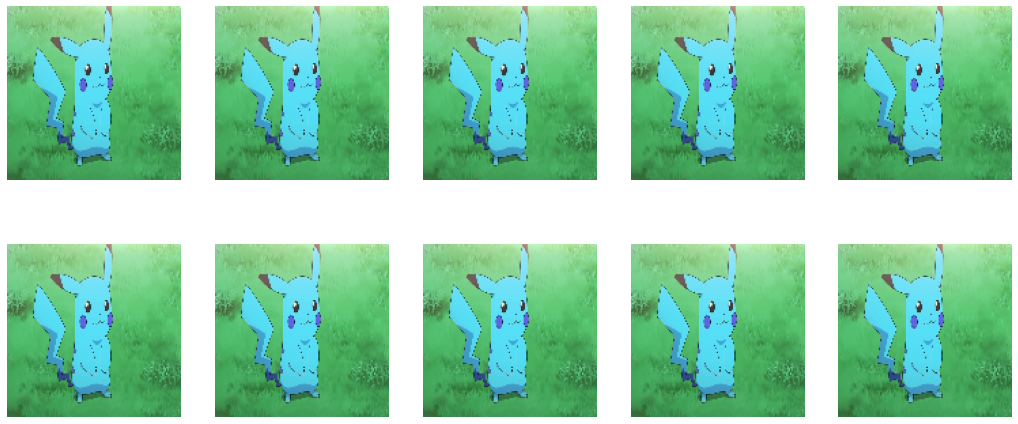

In [20]:
X_train, X_test, y_train, y_test, datagen = getImages(128,128,grayScale=False,datagenEnabled=False)

In [21]:
def train5():
        with wandb.init(config=sweep_config):
            config = wandb.config
            if wandb.run:
                model = Sequential()
                model.add(Conv2D(32, 3, padding = 'same', activation = 'relu',input_shape = (128, 128, 3),  kernel_initializer = 'he_normal'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Flatten())
                model.add(Dense(512, activation = 'relu'))
                model.add(BatchNormalization())
                model.add(Dropout(0.5))
                model.add(Dense(256, activation = 'relu'))
                model.add(BatchNormalization())
                model.add(Dropout(0.5))
                model.add(Dense(len(imbalanced), activation = 'softmax'))

                checkpoint = ModelCheckpoint('../working/model_9696_notransformation_bigger.hdf5', verbose = 1, monitor = 'val_accuracy', save_best_only = True)
                earlyStoppingCallback = EarlyStopping(monitor='loss', patience=3)

                opt = getOpt(config.optimizer, config.learning_rate)
            
                model.compile(optimizer = opt, loss = config.loss, metrics = ['accuracy'])
                history = model.fit(
                    datagen.flow(X_train, y_train, batch_size = config.batch_size),
                    epochs = config.epochs,
                    validation_data = (X_test, y_test),steps_per_epoch=len(X_train) // config.batch_size, 
                    callbacks = [WandbCallback(),earlyStoppingCallback]
                    )   


In [22]:
%%time
wandb.init(project="NN-zadanie2")
sweep_config['name'] = "NN-zadanie2-sweep-9696notransformation-bigger"
sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id, function=train5, count=20)

wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: u18epykk
Sweep URL: https://wandb.ai/ramang/uncategorized/sweeps/u18epykk


wandb: Agent Starting Run: gaotnfma with config:
wandb: 	batch_size: 17
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 84
wandb: 	gauss: 0.25520256947126996
wandb: 	learning_rate: 0.018351843337278184
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adagrad
wandb: 	pooling: 3


Epoch 1/84
69/69 [==============================] - 1s 17ms/step - loss: 2.1162 - accuracy: 0.3247 - val_loss: 1.3667 - val_accuracy: 0.4184
Epoch 2/84
69/69 [==============================] - 1s 10ms/step - loss: 1.5914 - accuracy: 0.4162 - val_loss: 1.7984 - val_accuracy: 0.3027
Epoch 3/84
69/69 [==============================] - 1s 10ms/step - loss: 1.3862 - accuracy: 0.4801 - val_loss: 1.8999 - val_accuracy: 0.3707
Epoch 4/84
69/69 [==============================] - 1s 10ms/step - loss: 1.1914 - accuracy: 0.5259 - val_loss: 2.2658 - val_accuracy: 0.3980
Epoch 5/84
69/69 [==============================] - 1s 10ms/step - loss: 1.0938 - accuracy: 0.5786 - val_loss: 2.1309 - val_accuracy: 0.3571
Epoch 6/84
69/69 [==============================] - 1s 10ms/step - loss: 1.0478 - accuracy: 0.6071 - val_loss: 1.6071 - val_accuracy: 0.4660
Epoch 7/84
69/69 [==============================] - 1s 10ms/step - loss: 0.9342 - accuracy: 0.6373 - val_loss: 1.7846 - val_accuracy: 0.4762
Epoch 8/84
69

epoch,23
loss,0.67676
accuracy,0.75734
val_loss,1.19525
val_accuracy,0.65986
_runtime,23
_timestamp,1618270545
_step,23
best_val_loss,1.02453
best_epoch,11


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▅▄▄▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
accuracy,▁▂▄▄▅▆▆▆▆▇▇▇▇▇▇▇████████
val_loss,▃▅▆█▇▄▅▆▃▂▂▁▃▃▃▂▃▂▂▂▄▃▂▂
val_accuracy,▃▁▂▃▂▄▄▃▅▅▆▇▆▅▅▇▆▇▇▇▇▇██
_runtime,▁▁▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: pj3mymlu with config:
wandb: 	batch_size: 19
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 29
wandb: 	gauss: 0.4785135912666063
wandb: 	learning_rate: 0.06794067422596076
wandb: 	loss: poisson
wandb: 	optimizer: Adagrad
wandb: 	pooling: 3


Epoch 1/29
61/61 [==============================] - 1s 17ms/step - loss: 0.6262 - accuracy: 0.3028 - val_loss: 0.5205 - val_accuracy: 0.3061
Epoch 2/29
61/61 [==============================] - 1s 12ms/step - loss: 0.4841 - accuracy: 0.4533 - val_loss: 0.4476 - val_accuracy: 0.4456
Epoch 3/29
61/61 [==============================] - 1s 12ms/step - loss: 0.4324 - accuracy: 0.5398 - val_loss: 0.4458 - val_accuracy: 0.4830
Epoch 4/29
61/61 [==============================] - 1s 12ms/step - loss: 0.4062 - accuracy: 0.5926 - val_loss: 0.4363 - val_accuracy: 0.5170
Epoch 5/29
61/61 [==============================] - 1s 12ms/step - loss: 0.3875 - accuracy: 0.6462 - val_loss: 0.4359 - val_accuracy: 0.6088
Epoch 6/29
61/61 [==============================] - 1s 12ms/step - loss: 0.3737 - accuracy: 0.6696 - val_loss: 0.4180 - val_accuracy: 0.5884
Epoch 7/29
61/61 [==============================] - 1s 11ms/step - loss: 0.3736 - accuracy: 0.6791 - val_loss: 0.4630 - val_accuracy: 0.5782
Epoch 8/29
61

epoch,26
loss,0.31152
accuracy,0.80882
val_loss,0.35238
val_accuracy,0.73129
_runtime,25
_timestamp,1618270574
_step,26
best_val_loss,0.35238
best_epoch,26


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇█▇██████████
val_loss,▆▄▄▃▃▃▄▃▅▅▆█▅▇▄▇▅▇▅▇▃▃▃▂▂▁▁
val_accuracy,▁▃▄▄▆▅▅▅▅▅▅▅▅▅▆▅▆▆▆▅▆▇▆▆▇██
_runtime,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: dle23azm with config:
wandb: 	batch_size: 40
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 83
wandb: 	gauss: 0.45921808684643933
wandb: 	learning_rate: 0.02638192942575787
wandb: 	loss: poisson
wandb: 	optimizer: Adagrad
wandb: 	pooling: 2


Epoch 1/83
29/29 [==============================] - 2s 55ms/step - loss: 0.5114 - accuracy: 0.4969 - val_loss: 0.4690 - val_accuracy: 0.4320
Epoch 2/83
29/29 [==============================] - 1s 39ms/step - loss: 0.3520 - accuracy: 0.7410 - val_loss: 0.4221 - val_accuracy: 0.6088
Epoch 3/83
29/29 [==============================] - 1s 40ms/step - loss: 0.3258 - accuracy: 0.7824 - val_loss: 0.3737 - val_accuracy: 0.7245
Epoch 4/83
29/29 [==============================] - 1s 40ms/step - loss: 0.2948 - accuracy: 0.8405 - val_loss: 0.3404 - val_accuracy: 0.7789
Epoch 5/83
29/29 [==============================] - 1s 35ms/step - loss: 0.2861 - accuracy: 0.8617 - val_loss: 0.3603 - val_accuracy: 0.6905
Epoch 6/83
29/29 [==============================] - 1s 35ms/step - loss: 0.2697 - accuracy: 0.8740 - val_loss: 0.3627 - val_accuracy: 0.7381
Epoch 7/83
29/29 [==============================] - 1s 39ms/step - loss: 0.2693 - accuracy: 0.8899 - val_loss: 0.3323 - val_accuracy: 0.7211
Epoch 8/83
29

epoch,36
loss,0.21702
accuracy,0.96828
val_loss,0.25609
val_accuracy,0.90816
_runtime,47
_timestamp,1618270626
_step,36
best_val_loss,0.24902
best_epoch,26


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████████
val_loss,█▇▅▄▅▅▄▄▄▃▃▃▁▂▁▁▁▁▂▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▂▁▁
val_accuracy,▁▄▅▆▅▅▅▄▅▆▆▇█▇██████████▇▇█▇▇████▇▇██
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: l621t4u0 with config:
wandb: 	batch_size: 20
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 76
wandb: 	gauss: 0.036163558430681086
wandb: 	learning_rate: 0.05997565156891661
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: RMSprop
wandb: 	pooling: 3


Epoch 1/76
58/58 [==============================] - 1s 18ms/step - loss: 4.5355 - accuracy: 0.3290 - val_loss: 189.1273 - val_accuracy: 0.2007
Epoch 2/76
58/58 [==============================] - 1s 13ms/step - loss: 1.9088 - accuracy: 0.4372 - val_loss: 57.6136 - val_accuracy: 0.2041
Epoch 3/76
58/58 [==============================] - 1s 13ms/step - loss: 1.4411 - accuracy: 0.5758 - val_loss: 15.9038 - val_accuracy: 0.4320
Epoch 4/76
58/58 [==============================] - 1s 13ms/step - loss: 1.3259 - accuracy: 0.6242 - val_loss: 5.5217 - val_accuracy: 0.5612
Epoch 5/76
58/58 [==============================] - 1s 12ms/step - loss: 1.2404 - accuracy: 0.6597 - val_loss: 5.6734 - val_accuracy: 0.4456
Epoch 6/76
58/58 [==============================] - 1s 12ms/step - loss: 1.2656 - accuracy: 0.6667 - val_loss: 6.5111 - val_accuracy: 0.4524
Epoch 7/76
58/58 [==============================] - 1s 12ms/step - loss: 1.1452 - accuracy: 0.6883 - val_loss: 7.1687 - val_accuracy: 0.4966
Epoch 8/7

epoch,18
loss,1.0282
accuracy,0.7697
val_loss,1.1312
val_accuracy,0.77551
_runtime,19
_timestamp,1618270655
_step,18
best_val_loss,0.53015
best_epoch,12


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▃▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁
accuracy,▁▃▅▆▆▆▇▆▇▇█▇▇█▇████
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▅▃▄▄▆▇▃▆▆█▇▇▇▇▇▇
_runtime,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: tlrn1yh6 with config:
wandb: 	batch_size: 18
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 65
wandb: 	gauss: 0.10381893972270889
wandb: 	learning_rate: 0.009781245512990278
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adam
wandb: 	pooling: 3


Epoch 1/65
65/65 [==============================] - 1s 17ms/step - loss: 1.6892 - accuracy: 0.4849 - val_loss: 23.5577 - val_accuracy: 0.2109
Epoch 2/65
65/65 [==============================] - 1s 12ms/step - loss: 1.0008 - accuracy: 0.6889 - val_loss: 1.6960 - val_accuracy: 0.5714
Epoch 3/65
65/65 [==============================] - 1s 12ms/step - loss: 0.8308 - accuracy: 0.7433 - val_loss: 0.5714 - val_accuracy: 0.7993
Epoch 4/65
65/65 [==============================] - 1s 12ms/step - loss: 0.6692 - accuracy: 0.7891 - val_loss: 0.4613 - val_accuracy: 0.8503
Epoch 5/65
65/65 [==============================] - 1s 11ms/step - loss: 0.6260 - accuracy: 0.7978 - val_loss: 1.6746 - val_accuracy: 0.4592
Epoch 6/65
65/65 [==============================] - 1s 11ms/step - loss: 0.5438 - accuracy: 0.8116 - val_loss: 0.5491 - val_accuracy: 0.8265
Epoch 7/65
65/65 [==============================] - 1s 11ms/step - loss: 0.5804 - accuracy: 0.8090 - val_loss: 1.0641 - val_accuracy: 0.6871
Epoch 8/65
6

epoch,16
loss,0.38668
accuracy,0.8764
val_loss,0.29884
val_accuracy,0.91837
_runtime,18
_timestamp,1618270678
_step,16
best_val_loss,0.19113
best_epoch,12


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▂▂
accuracy,▁▄▅▆▆▇▇▇▇▇▇▇█████
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▇▇▃▇▆▇▆▇▅▇█▇█▅█
_runtime,▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇█
_timestamp,▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇█
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: xht887tm with config:
wandb: 	batch_size: 51
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 100
wandb: 	gauss: 0.015112394210396951
wandb: 	learning_rate: 0.028874531770738135
wandb: 	loss: poisson
wandb: 	optimizer: SGD
wandb: 	pooling: 2


Epoch 1/100
23/23 [==============================] - 1s 57ms/step - loss: 0.6337 - accuracy: 0.3123 - val_loss: 1.5704 - val_accuracy: 0.2823
Epoch 2/100
23/23 [==============================] - 1s 45ms/step - loss: 0.5455 - accuracy: 0.4146 - val_loss: 0.9598 - val_accuracy: 0.3061
Epoch 3/100
23/23 [==============================] - 1s 44ms/step - loss: 0.4978 - accuracy: 0.4813 - val_loss: 0.6973 - val_accuracy: 0.3639
Epoch 4/100
23/23 [==============================] - 1s 44ms/step - loss: 0.4913 - accuracy: 0.4902 - val_loss: 0.5346 - val_accuracy: 0.4150
Epoch 5/100
23/23 [==============================] - 1s 44ms/step - loss: 0.4569 - accuracy: 0.5578 - val_loss: 0.4930 - val_accuracy: 0.4762
Epoch 6/100
23/23 [==============================] - 1s 45ms/step - loss: 0.4470 - accuracy: 0.5627 - val_loss: 0.3951 - val_accuracy: 0.6224
Epoch 7/100
23/23 [==============================] - 1s 44ms/step - loss: 0.3985 - accuracy: 0.6415 - val_loss: 0.3611 - val_accuracy: 0.7041
Epoch 

epoch,13
loss,0.36972
accuracy,0.6895
val_loss,0.39067
val_accuracy,0.64286
_runtime,20
_timestamp,1618270702
_step,13
best_val_loss,0.3347
best_epoch,10


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▆▄▄▃▃▂▂▁▁▁▁▁▁
accuracy,▁▃▄▄▅▆▇▇████▇█
val_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▃▄▆██▇▇█▇▇▇
_runtime,▁▁▂▃▃▃▄▅▅▆▇▇▇█
_timestamp,▁▁▂▃▃▃▄▅▅▆▇▇▇█
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: hh1rq55y with config:
wandb: 	batch_size: 23
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 93
wandb: 	gauss: 0.16470074377117616
wandb: 	learning_rate: 0.04105620156680456
wandb: 	loss: poisson
wandb: 	optimizer: Adagrad
wandb: 	pooling: 3


Epoch 1/93
51/51 [==============================] - 1s 17ms/step - loss: 0.5909 - accuracy: 0.3568 - val_loss: 0.4781 - val_accuracy: 0.3367
Epoch 2/93
51/51 [==============================] - 1s 14ms/step - loss: 0.5084 - accuracy: 0.4531 - val_loss: 0.4323 - val_accuracy: 0.4660
Epoch 3/93
51/51 [==============================] - 1s 14ms/step - loss: 0.4504 - accuracy: 0.5234 - val_loss: 0.3931 - val_accuracy: 0.5850
Epoch 4/93
51/51 [==============================] - 1s 13ms/step - loss: 0.4216 - accuracy: 0.5964 - val_loss: 0.3956 - val_accuracy: 0.6259
Epoch 5/93
51/51 [==============================] - 1s 13ms/step - loss: 0.4031 - accuracy: 0.6302 - val_loss: 0.3957 - val_accuracy: 0.5680
Epoch 6/93
51/51 [==============================] - 1s 14ms/step - loss: 0.3867 - accuracy: 0.6632 - val_loss: 0.3386 - val_accuracy: 0.7517
Epoch 7/93
51/51 [==============================] - 1s 14ms/step - loss: 0.3745 - accuracy: 0.6901 - val_loss: 0.3379 - val_accuracy: 0.7313
Epoch 8/93
51

epoch,26
loss,0.29629
accuracy,0.8342
val_loss,0.28042
val_accuracy,0.85374
_runtime,24
_timestamp,1618270733
_step,26
best_val_loss,0.26218
best_epoch,20


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▂▃▄▅▅▆▅▆▆▆▆▇▇▇▆▇▇▇▇▇▇██▇██
val_loss,█▇▅▅▅▃▃▃▄▃▃▂▃▂▃▂▂▂▁▁▁▂▁▂▁▁▂
val_accuracy,▁▃▄▅▄▆▆▆▆▆▆▇▆▇▇▇▇▇█████▇██▇
_runtime,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 4hqj2vr5 with config:
wandb: 	batch_size: 22
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 76
wandb: 	gauss: 0.32136041753174566
wandb: 	learning_rate: 0.09141752236797324
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adam
wandb: 	pooling: 2


Epoch 1/76
53/53 [==============================] - 2s 31ms/step - loss: 5.0381 - accuracy: 0.3469 - val_loss: 1202.8577 - val_accuracy: 0.2857
Epoch 2/76
53/53 [==============================] - 1s 25ms/step - loss: 1.9739 - accuracy: 0.4258 - val_loss: 105.4846 - val_accuracy: 0.2143
Epoch 3/76
53/53 [==============================] - 1s 25ms/step - loss: 1.9555 - accuracy: 0.3261 - val_loss: 4.8632 - val_accuracy: 0.3095
Epoch 4/76
53/53 [==============================] - 1s 25ms/step - loss: 1.6763 - accuracy: 0.4137 - val_loss: 3.1224 - val_accuracy: 0.3435
Epoch 5/76
53/53 [==============================] - 1s 21ms/step - loss: 1.6222 - accuracy: 0.3946 - val_loss: 6.5155 - val_accuracy: 0.2449
Epoch 6/76
53/53 [==============================] - 1s 21ms/step - loss: 1.6500 - accuracy: 0.4016 - val_loss: 7.5521 - val_accuracy: 0.2313
Epoch 7/76
53/53 [==============================] - 1s 25ms/step - loss: 1.8640 - accuracy: 0.3981 - val_loss: 2.9474 - val_accuracy: 0.3810
Epoch 8/

epoch,7
loss,1.91476
accuracy,0.43365
val_loss,3.58276
val_accuracy,0.35034
_runtime,16
_timestamp,1618270753
_step,7
best_val_loss,2.94737
best_epoch,6


epoch,▁▂▃▄▅▆▇█
loss,█▂▂▁▁▁▁▂
accuracy,▂▇▁▇▅▆▆█
val_loss,█▂▁▁▁▁▁▁
val_accuracy,▄▁▅▆▂▂█▇
_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█


wandb: Agent Starting Run: fkxzo8vy with config:
wandb: 	batch_size: 40
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 89
wandb: 	gauss: 0.4850808902644675
wandb: 	learning_rate: 0.04559824085044936
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: RMSprop
wandb: 	pooling: 2


Epoch 1/89
29/29 [==============================] - 1s 49ms/step - loss: 4.7499 - accuracy: 0.3833 - val_loss: 51.5110 - val_accuracy: 0.1837
Epoch 2/89
29/29 [==============================] - 1s 37ms/step - loss: 1.8433 - accuracy: 0.5198 - val_loss: 62.7552 - val_accuracy: 0.2993
Epoch 3/89
29/29 [==============================] - 1s 37ms/step - loss: 1.1854 - accuracy: 0.6485 - val_loss: 255.7972 - val_accuracy: 0.2041
Epoch 4/89
29/29 [==============================] - 1s 42ms/step - loss: 0.9220 - accuracy: 0.6846 - val_loss: 42.1981 - val_accuracy: 0.2687
Epoch 5/89
29/29 [==============================] - 1s 42ms/step - loss: 0.6874 - accuracy: 0.7806 - val_loss: 4.9353 - val_accuracy: 0.5204
Epoch 6/89
29/29 [==============================] - 1s 37ms/step - loss: 0.7595 - accuracy: 0.7797 - val_loss: 46.8820 - val_accuracy: 0.3912
Epoch 7/89
29/29 [==============================] - 1s 37ms/step - loss: 0.6264 - accuracy: 0.8079 - val_loss: 17.2364 - val_accuracy: 0.4286
Epoch 

epoch,16
loss,0.54113
accuracy,0.86784
val_loss,0.6704
val_accuracy,0.84694
_runtime,24
_timestamp,1618270791
_step,16
best_val_loss,0.6704
best_epoch,16


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▅▅▇▇▇▇▇▇███████
val_loss,▂▃█▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▁▂▄▃▃▅▅▆▅▇▄█▇▅█
_runtime,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
_timestamp,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: 19psi4l6 with config:
wandb: 	batch_size: 29
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 38
wandb: 	gauss: 0.04891367401802171
wandb: 	learning_rate: 0.06554462879754243
wandb: 	loss: poisson
wandb: 	optimizer: Adam
wandb: 	pooling: 3


Epoch 1/38
40/40 [==============================] - 1s 22ms/step - loss: 1.0020 - accuracy: 0.3185 - val_loss: 2.7657 - val_accuracy: 0.2041
Epoch 2/38
40/40 [==============================] - 1s 17ms/step - loss: 0.6350 - accuracy: 0.4110 - val_loss: 1.5601 - val_accuracy: 0.2755
Epoch 3/38
40/40 [==============================] - 1s 17ms/step - loss: 0.4822 - accuracy: 0.5262 - val_loss: 1.2227 - val_accuracy: 0.2415
Epoch 4/38
40/40 [==============================] - 1s 17ms/step - loss: 0.4203 - accuracy: 0.5995 - val_loss: 0.7273 - val_accuracy: 0.4014
Epoch 5/38
40/40 [==============================] - 1s 17ms/step - loss: 0.3728 - accuracy: 0.7042 - val_loss: 0.3226 - val_accuracy: 0.7891
Epoch 6/38
40/40 [==============================] - 1s 16ms/step - loss: 0.3517 - accuracy: 0.7469 - val_loss: 0.4348 - val_accuracy: 0.7075
Epoch 7/38
40/40 [==============================] - 1s 17ms/step - loss: 0.3496 - accuracy: 0.7321 - val_loss: 0.3089 - val_accuracy: 0.8401
Epoch 8/38
40

epoch,17
loss,0.33363
accuracy,0.80716
val_loss,0.29947
val_accuracy,0.85034
_runtime,16
_timestamp,1618270818
_step,17
best_val_loss,0.29947
best_epoch,17


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▄▅▆▇▇▇▇▇█████▇██
val_loss,█▅▄▂▁▁▁▂▃▂▁▁▂▁▁▁▃▁
val_accuracy,▁▂▁▃▇▆█▄▂▄▇▆▅█▇▇▃█
_runtime,▁▂▂▂▃▃▄▄▄▅▅▅▆▇▇▇██
_timestamp,▁▂▂▂▃▃▄▄▄▅▅▅▆▇▇▇██
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: ivshq37z with config:
wandb: 	batch_size: 20
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 24
wandb: 	gauss: 0.1466228984866616
wandb: 	learning_rate: 0.025171213286559392
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adam
wandb: 	pooling: 3


Epoch 1/24
58/58 [==============================] - 1s 17ms/step - loss: 2.4176 - accuracy: 0.3740 - val_loss: 54.8186 - val_accuracy: 0.2347
Epoch 2/24
58/58 [==============================] - 1s 13ms/step - loss: 1.1801 - accuracy: 0.5905 - val_loss: 14.1764 - val_accuracy: 0.3061
Epoch 3/24
58/58 [==============================] - 1s 13ms/step - loss: 0.9765 - accuracy: 0.7030 - val_loss: 6.2655 - val_accuracy: 0.4354
Epoch 4/24
58/58 [==============================] - 1s 13ms/step - loss: 0.7702 - accuracy: 0.7489 - val_loss: 3.2896 - val_accuracy: 0.3946
Epoch 5/24
58/58 [==============================] - 1s 13ms/step - loss: 0.6213 - accuracy: 0.7887 - val_loss: 2.0609 - val_accuracy: 0.4830
Epoch 6/24
58/58 [==============================] - 1s 13ms/step - loss: 0.5746 - accuracy: 0.8251 - val_loss: 1.0785 - val_accuracy: 0.6701
Epoch 7/24
58/58 [==============================] - 1s 12ms/step - loss: 0.5458 - accuracy: 0.8268 - val_loss: 1.6367 - val_accuracy: 0.5918
Epoch 8/24


epoch,22
loss,0.40588
accuracy,0.87879
val_loss,0.39671
val_accuracy,0.88095
_runtime,21
_timestamp,1618270844
_step,22
best_val_loss,0.36168
best_epoch,18


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▅▆▆▇▇▇▇▇█▇▇██████████
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▃▄▆▅▇▇█▆▇▆▇▇▄▆██▆▇▄█
_runtime,▁▁▁▂▂▃▃▃▄▄▅▅▅▅▅▆▆▇▇▇███
_timestamp,▁▁▁▂▂▃▃▃▄▄▅▅▅▅▅▆▆▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: j62ml19j with config:
wandb: 	batch_size: 38
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 21
wandb: 	gauss: 0.1340727259422258
wandb: 	learning_rate: 0.03105420015132552
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adagrad
wandb: 	pooling: 3


Epoch 1/21
30/30 [==============================] - 1s 34ms/step - loss: 2.1961 - accuracy: 0.2770 - val_loss: 1.7770 - val_accuracy: 0.2245
Epoch 2/21
30/30 [==============================] - 1s 21ms/step - loss: 1.4714 - accuracy: 0.4362 - val_loss: 1.1637 - val_accuracy: 0.4184
Epoch 3/21
30/30 [==============================] - 1s 21ms/step - loss: 1.1402 - accuracy: 0.5400 - val_loss: 0.9700 - val_accuracy: 0.6224
Epoch 4/21
30/30 [==============================] - 1s 21ms/step - loss: 0.9184 - accuracy: 0.6429 - val_loss: 0.9103 - val_accuracy: 0.6122
Epoch 5/21
30/30 [==============================] - 1s 19ms/step - loss: 0.8002 - accuracy: 0.7062 - val_loss: 1.1665 - val_accuracy: 0.5646
Epoch 6/21
30/30 [==============================] - 1s 19ms/step - loss: 0.7688 - accuracy: 0.7142 - val_loss: 1.0451 - val_accuracy: 0.5918
Epoch 7/21
30/30 [==============================] - 1s 20ms/step - loss: 0.7331 - accuracy: 0.7405 - val_loss: 1.3156 - val_accuracy: 0.4966
Epoch 8/21
30

epoch,20
loss,0.48752
accuracy,0.83201
val_loss,0.87256
val_accuracy,0.69388
_runtime,18
_timestamp,1618270867
_step,20
best_val_loss,0.78188
best_epoch,18


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▅▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,▁▃▄▆▆▇▇▇▇▇█▇█████████
val_loss,█▄▂▂▄▃▅▄▄▄▄▂▄▃▃▄▁▃▁▂▂
val_accuracy,▁▄▆▆▆▆▅▅▆▆▆▇▆▇▇▇█▇█▇▇
_runtime,▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_timestamp,▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6h3d3tkl with config:
wandb: 	batch_size: 37
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 91
wandb: 	gauss: 0.4935915122540885
wandb: 	learning_rate: 0.05668264031521802
wandb: 	loss: poisson
wandb: 	optimizer: Adagrad
wandb: 	pooling: 3


Epoch 1/91
31/31 [==============================] - 1s 33ms/step - loss: 0.6474 - accuracy: 0.2812 - val_loss: 0.4638 - val_accuracy: 0.4388
Epoch 2/91
31/31 [==============================] - 1s 21ms/step - loss: 0.5108 - accuracy: 0.4517 - val_loss: 0.4179 - val_accuracy: 0.5544
Epoch 3/91
31/31 [==============================] - 1s 21ms/step - loss: 0.4473 - accuracy: 0.5624 - val_loss: 0.3974 - val_accuracy: 0.5340
Epoch 4/91
31/31 [==============================] - 1s 21ms/step - loss: 0.4103 - accuracy: 0.6142 - val_loss: 0.3722 - val_accuracy: 0.6327
Epoch 5/91
31/31 [==============================] - 1s 21ms/step - loss: 0.3819 - accuracy: 0.6740 - val_loss: 0.3581 - val_accuracy: 0.6735
Epoch 6/91
31/31 [==============================] - 1s 20ms/step - loss: 0.3638 - accuracy: 0.6933 - val_loss: 0.3615 - val_accuracy: 0.7551
Epoch 7/91
31/31 [==============================] - 1s 21ms/step - loss: 0.3489 - accuracy: 0.7311 - val_loss: 0.3529 - val_accuracy: 0.7687
Epoch 8/91
31

epoch,24
loss,0.29715
accuracy,0.83304
val_loss,0.30381
val_accuracy,0.82653
_runtime,21
_timestamp,1618270903
_step,24
best_val_loss,0.30381
best_epoch,24


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▅▄▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▅▅▆▆▇▇▇▇▇▇▇▇███████████
val_loss,█▆▅▄▃▄▃▃▄▄▇▃▂▃▂▄▂▂▂▂▂▂▂▂▁
val_accuracy,▁▃▃▄▅▇▇▆▅▅▃▇█▇▇▅▇▇█▇▇▇▇██
_runtime,▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_timestamp,▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: xymvzl4j with config:
wandb: 	batch_size: 52
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 37
wandb: 	gauss: 0.05942032091973937
wandb: 	learning_rate: 0.09798124250289693
wandb: 	loss: poisson
wandb: 	optimizer: Adam
wandb: 	pooling: 3


Epoch 1/37
22/22 [==============================] - 1s 43ms/step - loss: 1.4717 - accuracy: 0.2342 - val_loss: 2.7657 - val_accuracy: 0.2041
Epoch 2/37
22/22 [==============================] - 1s 28ms/step - loss: 0.9435 - accuracy: 0.2796 - val_loss: 2.2498 - val_accuracy: 0.2585
Epoch 3/37
22/22 [==============================] - 1s 25ms/step - loss: 0.5614 - accuracy: 0.4274 - val_loss: 2.7746 - val_accuracy: 0.2007
Epoch 4/37
22/22 [==============================] - 1s 25ms/step - loss: 0.5025 - accuracy: 0.4568 - val_loss: 2.7403 - val_accuracy: 0.2075
Epoch 5/37
22/22 [==============================] - 1s 25ms/step - loss: 0.4391 - accuracy: 0.5467 - val_loss: 2.3677 - val_accuracy: 0.2245
Epoch 6/37
22/22 [==============================] - 1s 27ms/step - loss: 0.4004 - accuracy: 0.6046 - val_loss: 1.1223 - val_accuracy: 0.4082
Epoch 7/37
22/22 [==============================] - 1s 28ms/step - loss: 0.3873 - accuracy: 0.6607 - val_loss: 0.5830 - val_accuracy: 0.6599
Epoch 8/37
22

epoch,19
loss,0.33697
accuracy,0.78362
val_loss,0.51989
val_accuracy,0.69388
_runtime,18
_timestamp,1618270926
_step,19
best_val_loss,0.31669
best_epoch,16


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▄▅▆▆▇▇▇▇▇▇█▇█████
val_loss,█▇██▇▃▂▁▃▁▁▁▁▁▂▁▁▁▂▂
val_accuracy,▁▂▁▁▁▃▆▇▃▅▇▇▆▆▅▆█▇▅▆
_runtime,▁▂▂▂▂▃▃▃▄▅▅▅▅▆▆▆▇▇▇█
_timestamp,▁▂▂▂▂▃▃▃▄▅▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: y5ymi3d8 with config:
wandb: 	batch_size: 33
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 80
wandb: 	gauss: 0.006617532339868393
wandb: 	learning_rate: 0.023697782471697116
wandb: 	loss: poisson
wandb: 	optimizer: SGD
wandb: 	pooling: 2


Epoch 1/80
35/35 [==============================] - 1s 42ms/step - loss: 0.5166 - accuracy: 0.4755 - val_loss: 0.4379 - val_accuracy: 0.5850
Epoch 2/80
35/35 [==============================] - 1s 32ms/step - loss: 0.3960 - accuracy: 0.6515 - val_loss: 0.3898 - val_accuracy: 0.6939
Epoch 3/80
35/35 [==============================] - 1s 33ms/step - loss: 0.3478 - accuracy: 0.7487 - val_loss: 0.3637 - val_accuracy: 0.7381
Epoch 4/80
35/35 [==============================] - 1s 32ms/step - loss: 0.3270 - accuracy: 0.7855 - val_loss: 0.3326 - val_accuracy: 0.7959
Epoch 5/80
35/35 [==============================] - 1s 32ms/step - loss: 0.3085 - accuracy: 0.7986 - val_loss: 0.3281 - val_accuracy: 0.7993
Epoch 6/80
35/35 [==============================] - 1s 32ms/step - loss: 0.3004 - accuracy: 0.8319 - val_loss: 0.3073 - val_accuracy: 0.8197
Epoch 7/80
35/35 [==============================] - 1s 29ms/step - loss: 0.2944 - accuracy: 0.8389 - val_loss: 0.3079 - val_accuracy: 0.8095
Epoch 8/80
35

epoch,19
loss,0.24569
accuracy,0.92907
val_loss,0.26378
val_accuracy,0.90816
_runtime,27
_timestamp,1618270957
_step,19
best_val_loss,0.25888
best_epoch,18


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▄▅▆▆▇▇▇▇▇▇▇▇█▇█████
val_loss,█▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▆▆▆▆▆▇▇▇█████████
_runtime,▁▂▂▂▃▃▃▄▄▅▅▅▅▆▆▆▇▇██
_timestamp,▁▂▂▂▃▃▃▄▄▅▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: nwi4oa2z with config:
wandb: 	batch_size: 33
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 32
wandb: 	gauss: 0.3863499109295755
wandb: 	learning_rate: 0.01884222659766507
wandb: 	loss: poisson
wandb: 	optimizer: RMSprop
wandb: 	pooling: 2


Epoch 1/32
35/35 [==============================] - 1s 42ms/step - loss: 0.6455 - accuracy: 0.4755 - val_loss: 2.5755 - val_accuracy: 0.2551
Epoch 2/32
35/35 [==============================] - 1s 33ms/step - loss: 0.4245 - accuracy: 0.6699 - val_loss: 2.7131 - val_accuracy: 0.2143
Epoch 3/32
35/35 [==============================] - 1s 36ms/step - loss: 0.3573 - accuracy: 0.7662 - val_loss: 1.3134 - val_accuracy: 0.5952
Epoch 4/32
35/35 [==============================] - 1s 36ms/step - loss: 0.3223 - accuracy: 0.8327 - val_loss: 1.1301 - val_accuracy: 0.5884
Epoch 5/32
35/35 [==============================] - 1s 36ms/step - loss: 0.3101 - accuracy: 0.8424 - val_loss: 0.9250 - val_accuracy: 0.6429
Epoch 6/32
35/35 [==============================] - 1s 32ms/step - loss: 0.3005 - accuracy: 0.8476 - val_loss: 0.9538 - val_accuracy: 0.6156
Epoch 7/32
35/35 [==============================] - 1s 32ms/step - loss: 0.3003 - accuracy: 0.8415 - val_loss: 1.0276 - val_accuracy: 0.5884
Epoch 8/32
35

epoch,18
loss,0.24579
accuracy,0.94133
val_loss,0.66273
val_accuracy,0.65986
_runtime,28
_timestamp,1618270992
_step,18
best_val_loss,0.27459
best_epoch,13


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▅▆▇▇▇▇▇▇█████████
val_loss,██▄▃▃▃▃▄▁▁▂▁▁▁▁▂▁▂▂
val_accuracy,▁▁▅▅▅▅▅▃▇▇▅▇▇█▇▆▇▆▅
_runtime,▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: nvo346l7 with config:
wandb: 	batch_size: 26
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 71
wandb: 	gauss: 0.22828661585408894
wandb: 	learning_rate: 0.002309836463111259
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: SGD
wandb: 	pooling: 2


Epoch 1/71
45/45 [==============================] - 1s 32ms/step - loss: 2.3844 - accuracy: 0.2515 - val_loss: 1.4415 - val_accuracy: 0.3810
Epoch 2/71
45/45 [==============================] - 1s 23ms/step - loss: 1.8241 - accuracy: 0.3882 - val_loss: 1.4472 - val_accuracy: 0.3639
Epoch 3/71
45/45 [==============================] - 1s 23ms/step - loss: 1.5330 - accuracy: 0.4656 - val_loss: 1.8511 - val_accuracy: 0.2959
Epoch 4/71
45/45 [==============================] - 1s 23ms/step - loss: 1.2554 - accuracy: 0.5718 - val_loss: 1.9877 - val_accuracy: 0.2619
Epoch 5/71
45/45 [==============================] - 1s 23ms/step - loss: 1.1751 - accuracy: 0.5962 - val_loss: 2.2038 - val_accuracy: 0.2551
Epoch 6/71
45/45 [==============================] - 1s 23ms/step - loss: 1.0724 - accuracy: 0.6301 - val_loss: 2.3273 - val_accuracy: 0.3231
Epoch 7/71
45/45 [==============================] - 1s 23ms/step - loss: 0.9713 - accuracy: 0.6649 - val_loss: 2.2020 - val_accuracy: 0.4184
Epoch 8/71
45

epoch,35
loss,0.45628
accuracy,0.84682
val_loss,3.56667
val_accuracy,0.58503
_runtime,44
_timestamp,1618271046
_step,35
best_val_loss,1.44148
best_epoch,0


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▃▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇██████████████
val_loss,▁▁▂▂▃▃▃▂▅▃▄▄▄▅▅▆▅▅▆▆▄▅▅▅▅▅▆▇▇██▇▇▇▇▇
val_accuracy,▃▃▂▁▁▂▄▅▄▅▅▆▇▆▆▇▇▇▇▇█▇█████▇▇▆▆▇▇▇▇▇
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xa1s06lq with config:
wandb: 	batch_size: 21
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 25
wandb: 	gauss: 0.4116437972572397
wandb: 	learning_rate: 0.05997918523021045
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adagrad
wandb: 	pooling: 2


Epoch 1/25
55/55 [==============================] - 1s 27ms/step - loss: 1.8044 - accuracy: 0.4645 - val_loss: 6.0928 - val_accuracy: 0.4422
Epoch 2/25
55/55 [==============================] - 1s 23ms/step - loss: 0.8812 - accuracy: 0.7210 - val_loss: 1.2421 - val_accuracy: 0.6633
Epoch 3/25
55/55 [==============================] - 1s 23ms/step - loss: 0.7315 - accuracy: 0.7487 - val_loss: 0.6165 - val_accuracy: 0.7653
Epoch 4/25
55/55 [==============================] - 1s 21ms/step - loss: 0.6253 - accuracy: 0.7877 - val_loss: 0.8410 - val_accuracy: 0.6871
Epoch 5/25
55/55 [==============================] - 1s 21ms/step - loss: 0.5304 - accuracy: 0.8198 - val_loss: 0.8282 - val_accuracy: 0.7109
Epoch 6/25
55/55 [==============================] - 1s 24ms/step - loss: 0.4737 - accuracy: 0.8527 - val_loss: 0.5121 - val_accuracy: 0.8333
Epoch 7/25
55/55 [==============================] - 1s 21ms/step - loss: 0.4594 - accuracy: 0.8501 - val_loss: 0.5381 - val_accuracy: 0.8095
Epoch 8/25
55

epoch,24
loss,0.16871
accuracy,0.93847
val_loss,0.69415
val_accuracy,0.77891
_runtime,35
_timestamp,1618271085
_step,24
best_val_loss,0.48297
best_epoch,10


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁
accuracy,▁▅▅▆▆▇▇▇▇▇▇▇▇▇▇█▇▇███████
val_loss,█▂▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▃▁▁▁
val_accuracy,▁▅▇▅▆██▆▆▆█▆▆▇▇▆█▇█▅█▂▆█▇
_runtime,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: gkn7vrqv with config:
wandb: 	batch_size: 50
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 93
wandb: 	gauss: 0.24330795728838311
wandb: 	learning_rate: 0.05299767444402467
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adam
wandb: 	pooling: 3


Epoch 1/93
23/23 [==============================] - 1s 36ms/step - loss: 2.9437 - accuracy: 0.3765 - val_loss: 5167.3940 - val_accuracy: 0.2041
Epoch 2/93
23/23 [==============================] - 1s 33ms/step - loss: 1.6383 - accuracy: 0.5351 - val_loss: 481.9545 - val_accuracy: 0.2041
Epoch 3/93
23/23 [==============================] - 1s 27ms/step - loss: 0.9874 - accuracy: 0.6836 - val_loss: 10.9282 - val_accuracy: 0.3503
Epoch 4/93
23/23 [==============================] - 1s 27ms/step - loss: 0.7245 - accuracy: 0.7698 - val_loss: 9.3030 - val_accuracy: 0.4490
Epoch 5/93
23/23 [==============================] - 1s 27ms/step - loss: 0.6111 - accuracy: 0.8062 - val_loss: 4.8205 - val_accuracy: 0.5204
Epoch 6/93
23/23 [==============================] - 1s 27ms/step - loss: 0.5235 - accuracy: 0.8409 - val_loss: 4.1223 - val_accuracy: 0.4694
Epoch 7/93
23/23 [==============================] - 1s 24ms/step - loss: 0.4980 - accuracy: 0.8400 - val_loss: 4.7938 - val_accuracy: 0.4864
Epoch 8

epoch,12
loss,0.34254
accuracy,0.89067
val_loss,0.62609
val_accuracy,0.82313
_runtime,14
_timestamp,1618271109
_step,12
best_val_loss,0.37732
best_epoch,10


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▅▃▂▂▂▁▁▁▁▁▁▁
accuracy,▁▃▅▆▇▇▇▇▇████
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▄▄▄▄▇▇▇█▇▇
_runtime,▁▁▂▃▃▄▅▅▅▆▆▇█
_timestamp,▁▁▂▃▃▄▅▅▅▆▆▇█
_step,▁▂▂▃▃▄▅▅▆▆▇▇█


wandb: Agent Starting Run: xms8pza3 with config:
wandb: 	batch_size: 48
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 64
wandb: 	gauss: 0.18790614666368333
wandb: 	learning_rate: 0.08529292255199417
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: SGD
wandb: 	pooling: 2


Epoch 1/64
24/24 [==============================] - 2s 104ms/step - loss: 1.3570 - accuracy: 0.5803 - val_loss: 2.6467 - val_accuracy: 0.4966
Epoch 2/64
24/24 [==============================] - 1s 43ms/step - loss: 0.7254 - accuracy: 0.7436 - val_loss: 1.5517 - val_accuracy: 0.5850
Epoch 3/64
24/24 [==============================] - 1s 43ms/step - loss: 0.6149 - accuracy: 0.8012 - val_loss: 1.3342 - val_accuracy: 0.5884
Epoch 4/64
24/24 [==============================] - 1s 43ms/step - loss: 0.5545 - accuracy: 0.8261 - val_loss: 1.2205 - val_accuracy: 0.6293
Epoch 5/64
24/24 [==============================] - 1s 39ms/step - loss: 0.4678 - accuracy: 0.8403 - val_loss: 1.6668 - val_accuracy: 0.5816
Epoch 6/64
24/24 [==============================] - 1s 40ms/step - loss: 0.4338 - accuracy: 0.8456 - val_loss: 1.3612 - val_accuracy: 0.6224
Epoch 7/64
24/24 [==============================] - 1s 40ms/step - loss: 0.3255 - accuracy: 0.8873 - val_loss: 1.3281 - val_accuracy: 0.6293
Epoch 8/64
2

epoch,35
loss,0.10251
accuracy,0.96451
val_loss,0.82546
val_accuracy,0.79932
_runtime,43
_timestamp,1618271157
_step,35
best_val_loss,0.31921
best_epoch,27


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▅▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_loss,▇▄▄▃▅▄▄▃▃▃▂█▄▂▂▃▂▅▆▃▃▃▂▂▁▁▂▁▁▂▂▁▁▁▁▂
val_accuracy,▁▂▃▃▂▃▃▄▅▄▆▂▄▇▆▅▇▃▂▅▅▅▆▇█▇▇██▇▆██▇█▆
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


Wall time: 10min 45s


# RGB 32x32 - notransformation, smoller

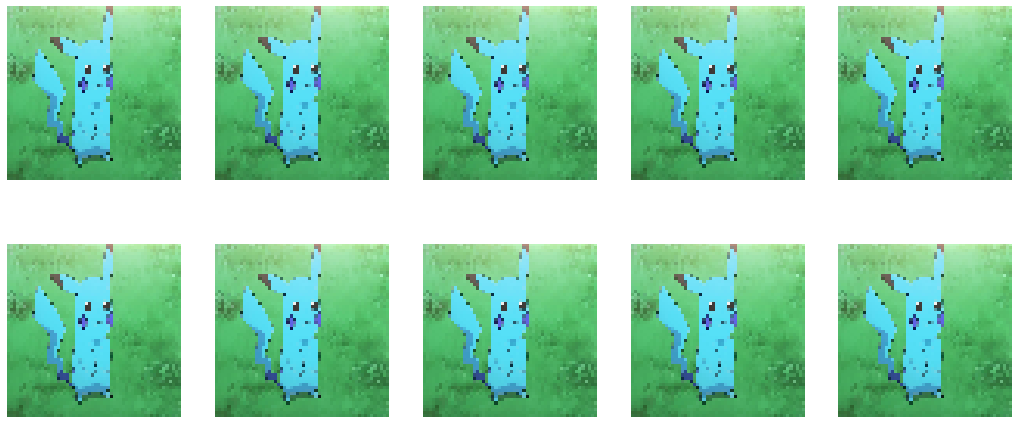

In [23]:
X_train, X_test, y_train, y_test, datagen = getImages(56,56,grayScale=False,datagenEnabled=False)

In [24]:
def train6():
        with wandb.init(config=sweep_config):
            config = wandb.config
            if wandb.run:
                model = Sequential()
                model.add(Conv2D(32, 3, padding = 'same', activation = 'relu',input_shape = (56, 56, 3),  kernel_initializer = 'he_normal'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((config.pooling, config.pooling)))
                model.add(Dropout(config.dropout_layers))

                model.add(Flatten())
                model.add(Dense(512, activation = 'relu'))
                model.add(BatchNormalization())
                model.add(Dropout(0.5))
                model.add(Dense(256, activation = 'relu'))
                model.add(BatchNormalization())
                model.add(Dropout(0.5))
                model.add(Dense(len(imbalanced), activation = 'softmax'))

                checkpoint = ModelCheckpoint('../working/model_9696_notransformation_smoller.hdf5', verbose = 1, monitor = 'val_accuracy', save_best_only = True)
                earlyStoppingCallback = EarlyStopping(monitor='loss', patience=3)

                opt = getOpt(config.optimizer, config.learning_rate)
            
                model.compile(optimizer = opt, loss = config.loss, metrics = ['accuracy'])
                history = model.fit(
                    datagen.flow(X_train, y_train, batch_size = config.batch_size),
                    epochs = config.epochs,
                    validation_data = (X_test, y_test),steps_per_epoch=len(X_train) // config.batch_size, 
                    callbacks = [WandbCallback(),earlyStoppingCallback]
                    )   


In [26]:
%%time
wandb.init(project="NN-zadanie2")
sweep_config['name'] = "NN-zadanie2-sweep-9696notransformation-smoller"
sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id, function=train6, count=20
           )

wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: yiwigbbe
Sweep URL: https://wandb.ai/ramang/uncategorized/sweeps/yiwigbbe


wandb: Agent Starting Run: 85wernmp with config:
wandb: 	batch_size: 57
wandb: 	dropout_layers: 0.25
wandb: 	epochs: 24
wandb: 	gauss: 0.3858461964420213
wandb: 	learning_rate: 0.047694524358372584
wandb: 	loss: poisson
wandb: 	optimizer: Adagrad
wandb: 	pooling: 2


Epoch 1/24
20/20 [==============================] - 1s 29ms/step - loss: 0.5746 - accuracy: 0.3980 - val_loss: 0.5085 - val_accuracy: 0.2687
Epoch 2/24
20/20 [==============================] - 0s 15ms/step - loss: 0.4319 - accuracy: 0.5796 - val_loss: 0.4759 - val_accuracy: 0.4014
Epoch 3/24
20/20 [==============================] - 0s 15ms/step - loss: 0.3845 - accuracy: 0.6798 - val_loss: 0.3672 - val_accuracy: 0.6599
Epoch 4/24
20/20 [==============================] - 0s 15ms/step - loss: 0.3559 - accuracy: 0.7245 - val_loss: 0.3437 - val_accuracy: 0.7041
Epoch 5/24
20/20 [==============================] - 0s 15ms/step - loss: 0.3368 - accuracy: 0.7826 - val_loss: 0.3348 - val_accuracy: 0.7585
Epoch 6/24
20/20 [==============================] - 0s 16ms/step - loss: 0.3205 - accuracy: 0.7853 - val_loss: 0.3309 - val_accuracy: 0.7517
Epoch 7/24
20/20 [==============================] - 0s 15ms/step - loss: 0.3212 - accuracy: 0.7952 - val_loss: 0.3138 - val_accuracy: 0.7789
Epoch 8/24
20

epoch,23
loss,0.25829
accuracy,0.89356
val_loss,0.29525
val_accuracy,0.85374
_runtime,12
_timestamp,1618298899
_step,23
best_val_loss,0.29328
best_epoch,16


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇███████████
val_loss,█▇▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▂▂▃▁
val_accuracy,▁▃▆▆▇▇▇▇▇▇▇▇▇██▇██████▇█
_runtime,▁▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇███
_timestamp,▁▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇███
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: k3kx9mzo with config:
wandb: 	batch_size: 47
wandb: 	dropout_layers: 0.5
wandb: 	epochs: 62
wandb: 	gauss: 0.41235276274060295
wandb: 	learning_rate: 0.08171222629179586
wandb: 	loss: poisson
wandb: 	optimizer: SGD
wandb: 	pooling: 2


Epoch 1/62
25/25 [==============================] - 1s 21ms/step - loss: 0.6746 - accuracy: 0.2613 - val_loss: 0.5127 - val_accuracy: 0.2585
Epoch 2/62
25/25 [==============================] - 0s 14ms/step - loss: 0.5538 - accuracy: 0.4026 - val_loss: 0.4453 - val_accuracy: 0.5408
Epoch 3/62
25/25 [==============================] - 0s 14ms/step - loss: 0.4789 - accuracy: 0.5123 - val_loss: 0.4276 - val_accuracy: 0.4966
Epoch 4/62
25/25 [==============================] - 0s 14ms/step - loss: 0.4325 - accuracy: 0.5898 - val_loss: 0.4082 - val_accuracy: 0.6122
Epoch 5/62
25/25 [==============================] - 0s 14ms/step - loss: 0.3960 - accuracy: 0.6477 - val_loss: 0.3893 - val_accuracy: 0.5952
Epoch 6/62
25/25 [==============================] - 0s 12ms/step - loss: 0.3884 - accuracy: 0.6579 - val_loss: 0.3896 - val_accuracy: 0.5952
Epoch 7/62
25/25 [==============================] - 0s 14ms/step - loss: 0.3769 - accuracy: 0.6834 - val_loss: 0.3819 - val_accuracy: 0.6122
Epoch 8/62
25

epoch,23
loss,0.31149
accuracy,0.8034
val_loss,0.30809
val_accuracy,0.80272
_runtime,13
_timestamp,1618298917
_step,23
best_val_loss,0.30478
best_epoch,21


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▆▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇███████████
val_loss,█▆▅▄▄▄▄▄▃▃▃▂▃▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▅▄▅▅▅▅▆▇▆▆▇▆▇▇▇████████
_runtime,▁▁▁▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▁▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: fq4pegqr with config:
wandb: 	batch_size: 21
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 68
wandb: 	gauss: 0.24632644889704486
wandb: 	learning_rate: 0.015866034530858976
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: RMSprop
wandb: 	pooling: 3


wandb: ERROR Run fq4pegqr errored: ValueError('Negative dimension size caused by subtracting 3 from 2 for \'{{node max_pooling2d_3/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 3, 3, 1], padding="VALID", strides=[1, 3, 3, 1]](batch_normalization_3/cond/Identity)\' with input shapes: [?,2,2,256].')
wandb: Agent Starting Run: jb1cn7re with config:
wandb: 	batch_size: 43
wandb: 	dropout_layers: 0.1
wandb: 	epochs: 66
wandb: 	gauss: 0.2797123797626439
wandb: 	learning_rate: 0.006900948985624733
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: RMSprop
wandb: 	pooling: 3


wandb: ERROR Run jb1cn7re errored: ValueError('Negative dimension size caused by subtracting 3 from 2 for \'{{node max_pooling2d_3/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 3, 3, 1], padding="VALID", strides=[1, 3, 3, 1]](batch_normalization_3/cond/Identity)\' with input shapes: [?,2,2,256].')
wandb: Agent Starting Run: qo4wvld9 with config:
wandb: 	batch_size: 22
wandb: 	dropout_layers: 0.4
wandb: 	epochs: 66
wandb: 	gauss: 0.3877325814208885
wandb: 	learning_rate: 0.04721463262642461
wandb: 	loss: poisson
wandb: 	optimizer: Adam
wandb: 	pooling: 3


wandb: ERROR Run qo4wvld9 errored: ValueError('Negative dimension size caused by subtracting 3 from 2 for \'{{node max_pooling2d_3/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 3, 3, 1], padding="VALID", strides=[1, 3, 3, 1]](batch_normalization_3/cond/Identity)\' with input shapes: [?,2,2,256].')
wandb: ERROR Detected 3 failed runs in the first 60 seconds, killing sweep.
wandb: To disable this check set WANDB_AGENT_DISABLE_FLAPPING=true


Wall time: 60 s
